In [1]:
%load_ext autoreload
%autoreload 2

Dataset Params:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (613 > 512). Running this sequence through the model will result in indexing errors
Dataset Params: 100%|██████████| 1/1 [02:21<00:00, 141.00s/it]


,ticker,date,title,text,id
0,DUK,2020-10-01 16:11:00,"Duke Energy to host virtual Environmental, Soc...","CHARLOTTE, N.C., Oct. 1, 2020 /PRNewswire/ --D...",2
1,XOM,2021-02-19 18:55:00,INVESTOR ACTION ALERT: The Schall Law Firm Ann...,"LOS ANGELES, Feb. 19, 2021 /PRNewswire/ --The ...",12
2,MSFT,2020-12-09 16:02:00,"NComputing Delivers Secure, Affordable, High-p...","SAN MATEO, Calif., Dec. 9, 2020 /PRNewswire/ -...",15
3,AMGN,2020-12-16 21:30:00,Amgen Announces 10% Increase In 2021 First Qua...,"THOUSAND OAKS, Calif., Dec. 16, 2020 /PRNewswi...",25
4,NVDA,2021-02-24 15:00:00,Global Visualization and 3D Rendering Software...,"DUBLIN, Feb. 24, 2021 /PRNewswire/ -- The ""Vis...",34
...,...,...,...,...,...
12670,AMZN,2021-03-24 14:11:00,Outlook on the Online Music Streaming Global M...,"DUBLIN--(BUSINESS WIRE)--The ""Online Music Str...",290716
12671,MSFT,2020-12-11 03:06:00,I Squared Capital,--(BUSINESS WIRE)--()--I Squared CapitalISQ Gl...,290724
12672,V,2021-02-03 12:00:00,Visa Expands Digital Currency Roadmap with Fir...,SAN FRANCISCO--(BUSINESS WIRE)--Visa (NYSE:V) ...,290783
12673,CAT,2020-11-17 10:49:00,2020 Insights on the Mining Equipment Global M...,"DUBLIN--(BUSINESS WIRE)--The ""Mining Equipment...",290830


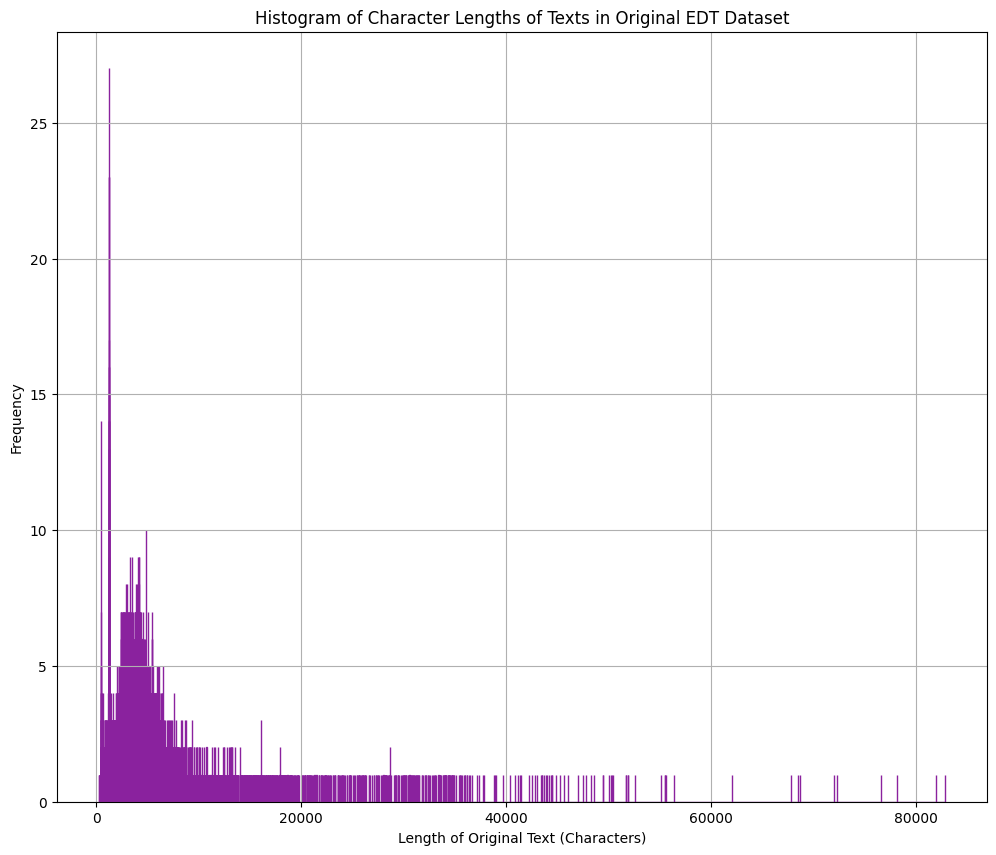

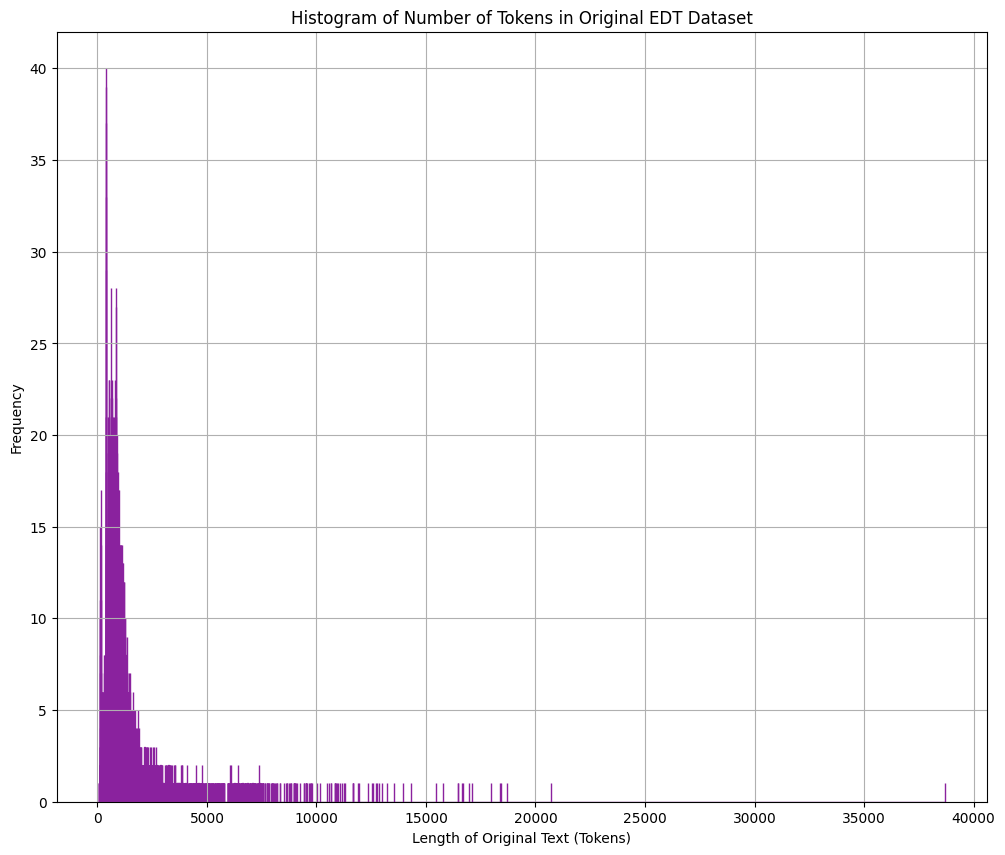

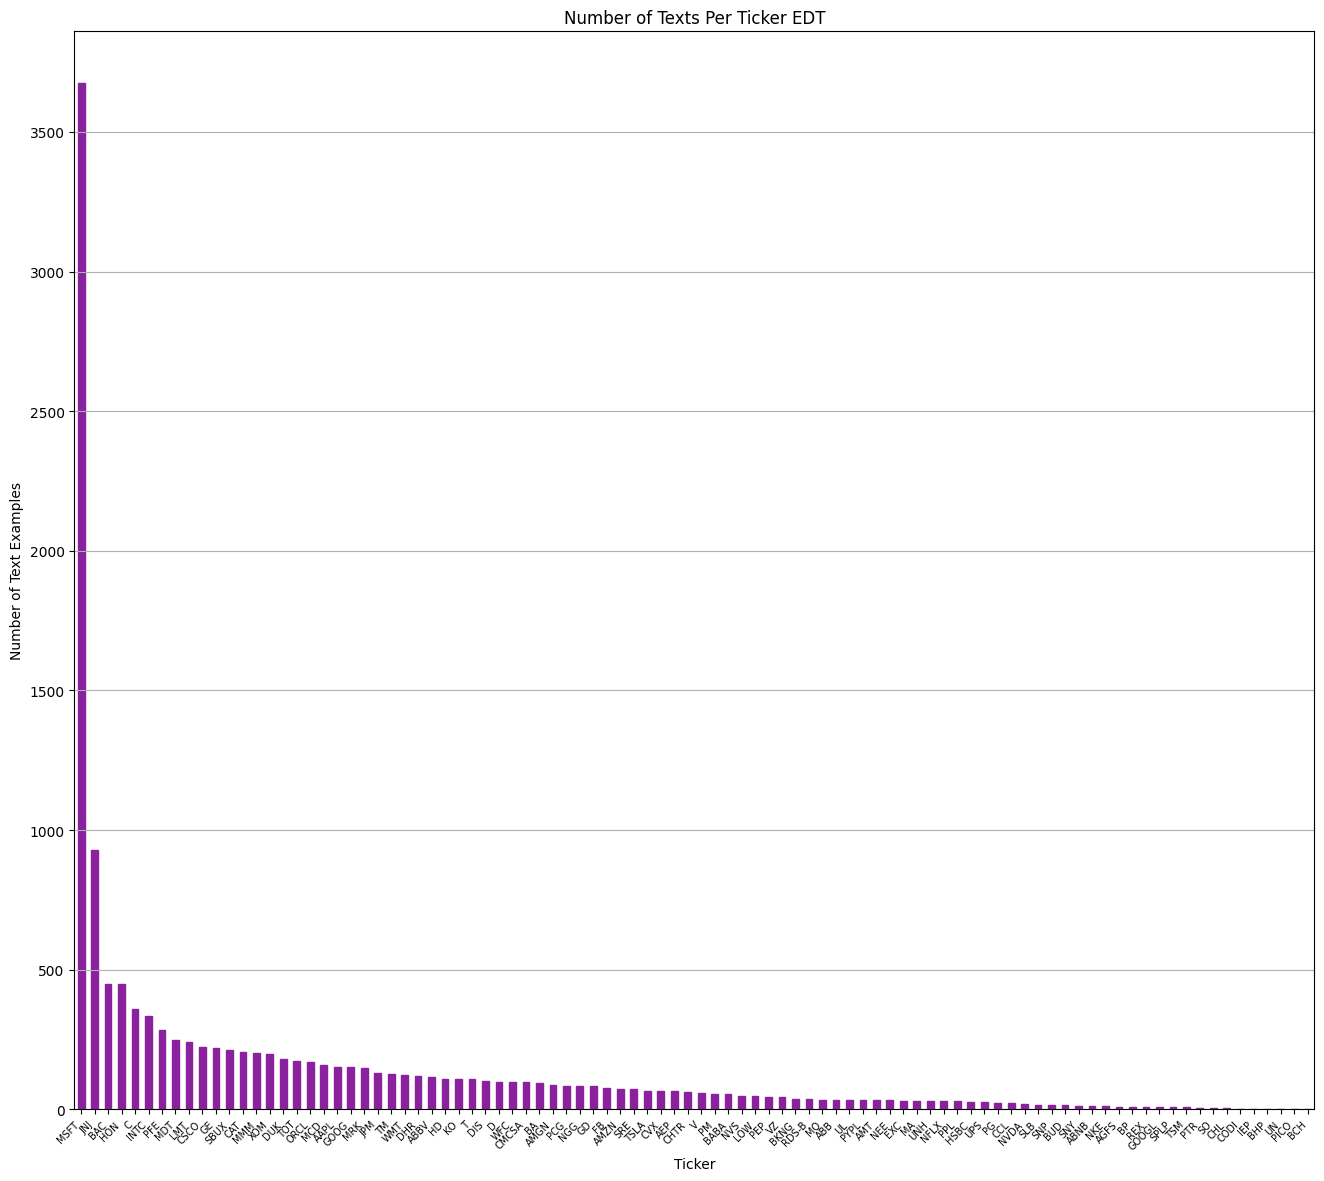

In [22]:
import data_helper_v3 as dh3
import itertools
from tqdm import tqdm
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import model_helper as mh
from transformers import TimeSeriesTransformerModel, TimeSeriesTransformerConfig
import time
from transformers import AutoTokenizer
import pdb
import matplotlib.dates as mdates

SAVE_PATH = './images/'

def set_seed(seed, device):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device != 'cpu' and device != None:        
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def plot_original_ts(ts_df, save_file, mode='ticker', date_pairs=None, font_size=20):
    ts_df['Date'] = pd.to_datetime(ts_df['Date'])

    if mode == 'ticker':
        # Plot each ticker with a unique color
        plt.figure(figsize=(20, 6))
        for ticker in ts_df['ticker'].unique():
            ticker_df = ts_df[ts_df['ticker'] == ticker]
            if ticker == 'DIS': colour = 'orange'
            elif ticker == "AAPL": colour = None
            plt.plot(ticker_df['Date'], ticker_df['Close'], label=ticker)#, linewidth=14)

        plt.legend(title='Ticker', loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2, 
                   bbox_transform=plt.gcf().transFigure, fontsize=font_size)
        plt.xlabel('Date')#, fontsize=font_size)
        plt.ylabel('Close Price', fontsize=font_size)
        plt.title('Close Price Over Time by Ticker', fontsize=font_size+10)
        plt.grid(True)
        
        #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30)) # Set major ticks to daily intervals
        #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))  # Format date as day-month-year

        # Rotate x-axis labels for better readability
        plt.gcf().autofmt_xdate()
        plt.xticks(fontsize=font_size)  # Larger font for x-axis ticks
        plt.yticks(fontsize=font_size)  # Larger font for y-axis ticks
        if date_pairs:
            ymin, ymax = plt.gca().get_ylim()  # Get the current y-axis limits
            for start_date, end_date in date_pairs:
                # Highlight the range between start_date and end_date, and span the full y-axis range
                plt.axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), 
                            color='gray', edgecolor='gray', linestyle='--', linewidth=1, 
                            ymin=0, ymax=1)  # Ensure the box spans the entire y-axis

    elif mode == 'industry':
        # Ensure 'industry' column exists in the dataframe
        if 'industry' not in ts_df.columns:
            raise ValueError("Industry mode selected, but 'industry' column is missing in ts_df")

        industries = ts_df['industry'].unique()
        industry_colors = plt.cm.get_cmap('tab10', len(industries))  # Assign colors to industries

        plt.figure(figsize=(20, 6))
        # Plot each ticker, colored by its industry
        for idx, industry in enumerate(industries):
            industry_df = ts_df[ts_df['industry'] == industry]
            for ticker in industry_df['ticker'].unique():
                ticker_df = industry_df[industry_df['ticker'] == ticker]
                # Label the plot with both industry and ticker
                plt.plot(ticker_df['Date'], ticker_df['Close'], label=f'{industry} - {ticker}', color=industry_colors(idx))

        plt.legend(title='Industry - Ticker', loc='upper center', bbox_to_anchor=(0.5, 0), ncol=8, 
                   bbox_transform=plt.gcf().transFigure)
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.title('Close Price Over Time by Industry and Ticker')
        plt.grid(True)

    elif mode == 'industry_subplot':
        # Ensure 'industry' column exists in the dataframe
        if 'industry' not in ts_df.columns:
            raise ValueError("Industry subplot mode selected, but 'industry' column is missing in ts_df")

        industries = ts_df['industry'].unique()
        num_industries = len(industries)
        
        # Create a subplot for each industry
        fig, axes = plt.subplots(num_industries, 1, figsize=(20, 6 * num_industries), sharex=True)

        if num_industries == 1:
            axes = [axes]  # Ensure axes is iterable even if there's only one subplot

        # Plot for each industry in its own subplot
        for idx, industry in enumerate(industries):
            industry_df = ts_df[ts_df['industry'] == industry]
            ax = axes[idx]
            tickers = industry_df['ticker'].unique()
            ticker_colors = plt.cm.get_cmap('tab10', len(tickers))  # Assign colors to tickers
            
            for t_idx, ticker in enumerate(tickers):
                ticker_df = industry_df[industry_df['ticker'] == ticker]
                ax.plot(ticker_df['Date'], ticker_df['Close'], label=ticker, color=ticker_colors(t_idx))
            
            ax.set_title(f'Close Price Over Time for Industry: {industry}')
            ax.set_ylabel('Close Price')
            ax.legend(title='Ticker', loc='upper left')
            ax.grid(True)
        
        plt.xlabel('Date')
        plt.tight_layout()

    # Save the plot to a local file
    time.sleep(2)
    plt.savefig(save_file + ".png")


def add_industry_labels(df, dataset_name):
     if dataset_name == 'stock_emotion':
        industry_df = pd.read_csv('./data/stock_emotions/tweet/processed_stockemo.csv')
        
        # Drop duplicates to ensure a unique mapping between tickers and industries
        df_unique = industry_df[['ticker', 'industry']].drop_duplicates()
    
        # Create a dictionary mapping ticker to industry
        ticker_to_industry = dict(zip(df_unique['ticker'], df_unique['industry']))
     elif dataset_name == 'stock_net':
        stock_df = pd.read_csv('./data/stocknet/StockTable.txt', sep='\t')
        stock_df['Symbol'] = stock_df['Symbol'].str.replace('$', '', regex=False)
        # Create a dictionary mapping ticker (Symbol) to industry (Sector)
        ticker_to_industry = dict(zip(stock_df['Symbol'], stock_df['Sector']))
        
        
     elif dataset_name == 'EDT':
          raise NotImplementedError
     df['industry'] = df['ticker'].map(ticker_to_industry)

     df['industry'] = df['industry'].fillna('no industry given')
     return df

def plot_list_as_hist(list_freqs, xlabel, title, colour):
    plt.figure(figsize=(12, 10))
    plt.hist(list_freqs, bins=range(min(list_freqs), max(list_freqs) + 2), edgecolor=colour, color = colour)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True)
    #plt.xticks(rotation=45, ha='right')
    # Save the histogram to a file
    title = title.replace("\n", " ")
    title = title.replace(":", " ")
    save_name = f'{title}_histogram.png'
    plt.savefig(SAVE_PATH + save_name)

def plot_text_counts(counts, xlabel, title, colour):
    
    # Count occurrences of each number of texts
    count_values = counts.value_counts().sort_index()
    
    plt.figure(figsize=(12, 10))
    count_values.plot(kind='bar', color=colour, edgecolor='black')

    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.title(title)
    plt.grid(axis='y')

    title = title.replace("\n", " ")
    title = title.replace(":", " ")

    save_name = f'{title}_column_graph.png'
    plt.savefig(SAVE_PATH + save_name)

def plot_text_examples_per_ticker(df, title, colour):
    # Count the number of text examples per ticker
    text_counts = df['ticker'].value_counts()
    
    # Plot as a column graph (bar plot)
    plt.figure(figsize=(16, 14))
    text_counts.plot(kind='bar', color=colour, edgecolor=colour)

    plt.xlabel('Ticker')
    plt.ylabel('Number of Text Examples')
    plt.title(title)
    plt.grid(axis='y')
    plt.xticks(rotation=45, ha='right', fontsize=7)
    # Save the plot to a local file
    plt.savefig(f'{SAVE_PATH}{title}.png')

dataset_param_grid = {                                                                            
        "ts_window": [4],#6 & 7 had a random error out                                                                         
        "ts_overlap": ['start'],                                                                    
        "text_window": [1],#, 2, 3, 4], #4                                                                
        'text_selection_method': [('TFIDF', 5)],
        "data_source": [{
            "name": "EDT",
            "name_visual": "EDT",
            "text_path": "./data/EDT/evaluate_news.json",
            "ts_path": "./data/stock_emotions/price/",
            "ts_date_col": 'Date',
            'text_date_col': 'date',
            'text_col': 'text',
            'plot_colour': '#8a229e',
            'plot_colours': ['#8a229e', '#c71585', '#612aaf', '#b2198d', '#9e1d96'],
            'subset_list': ['JNJ', 'BAC', 'MSFT'],
            'train_dates': '01/01/2020 - 03/09/2020',
            'test_dates': '04/09/2020 - 31/12/2020'
        }#,{
        #    "name": "stock_emotion",
        #    "name_visual": "Stock Emotion",
        #    "text_path": "./data/stock_emotions/tweet/processed_stockemo.csv",
        #    "ts_path": "./data/stock_emotions/price/",
        #    "ts_date_col": 'Date',
        #    'text_date_col': 'date',
        #    'text_col': 'text',
        #    'plot_colour': '#ff7f00',
        #    'plot_colours': ['#ff7f00',  '#ffcc00',  '#ff4c00', '#ff6600', '#ff9900'],
        #    'subset_list': ['AAPL', 'BA', 'TSLA'],
        #    'train_dates': '01/01/2020 - 03/09/2020',
        #    'test_dates': '04/09/2020 - 31/12/2020'
        #},  {
        #    "name": "stock_net",
        #    "name_visual": "Stock Net",
        #    "text_path": "./data/stocknet/tweet/organised_tweet.csv",
        #    "ts_path": "./data/stocknet/price/raw/",
        #    "ts_date_col": 'Date',
        #    'text_date_col': 'created_at',
        #    'text_col': 'text',
        #    'plot_colour': '#6ec681',
        #    'plot_colours': ['#6ec681', '#0d98ba', '#b0e65b', '#2da7a7', '#4eb794'],
        #    'subset_list': ['AAPL', 'FB', 'GOOG'],
        #    'train_dates': '01/01/2014 - 01/08/2015',
        #    'test_dates': '01/08/2015 - 01/01/2016'
        #}
        ],                                                            
        "negatives_creation": [("naive", 60)],                          
        "random_state": [42],
    }

dataset_permutations = list(itertools.product(*dataset_param_grid.values()))
dataset_combinations = [dict(zip(dataset_param_grid.keys(), perm)) for perm in dataset_permutations]
for dataset_params in tqdm(dataset_combinations, desc='Dataset Params', position=0):        
        #====================================================
        #dataset params
        #====================================================
        ts_window                   = dataset_params['ts_window']
        ts_overlap                  = dataset_params['ts_overlap']
        text_window                 = dataset_params["text_window"]
        text_selection_method       = dataset_params['text_selection_method']
        data_source                 = dataset_params["data_source"]
        negatives_creation          = dataset_params['negatives_creation']
        random_state                = dataset_params["random_state"] #effects everything but first call is the ds creation
        plot_colour                 = data_source['plot_colour']
        set_seed(random_state, device=None)

        text_df, ts_df = dh3.wrangle_data(data_source)
        ts_df = dh3.normalize_ts(ts_df)
        
        df = dh3.get_data(text_tokenizer=None, 
            data_source=data_source, 
            ts_window=ts_window, 
            ts_mode=ts_overlap, 
            text_window=text_window, 
            text_selection_method=text_selection_method, 
            negatives_creation=negatives_creation, 
            batch_size=None, 
            num_workers=None, 
            loaders=False,
            subset_data=True)
        
        if data_source['name'] == 'EDT':
            with open('./data/tickers_selected/edt.txt', 'r') as file:
                edt_keep_tickers = [line.strip() for line in file]
            text_df = text_df[text_df['ticker'].isin(edt_keep_tickers)].reset_index(drop=True)
            ts_df = ts_df[ts_df['ticker'].isin(edt_keep_tickers)].reset_index(drop=True)
        
        #ts_df = add_industry_labels(df=ts_df, dataset_name=data_source['name'])
        #text_df = add_industry_labels(df=text_df, dataset_name=data_source['name'])
        #df = add_industry_labels(df=df, dataset_name=data_source['name'])

        #for each dataset permutation get:
        #base dataset:
            #1. lenghts of individual texts characters/tokens
        tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        lengths_of_original_texts = text_df[data_source['text_col']].apply(len)
        lengths_of_tokenized_texts = text_df[data_source['text_col']].apply(lambda text: len(tokenizer.tokenize(text)))

        plot_list_as_hist(lengths_of_original_texts, xlabel="Length of Original Text (Characters)", title=f"Histogram of Character Lengths of Texts in Original {data_source['name_visual']} Dataset",
                          colour=plot_colour)
        plot_list_as_hist(lengths_of_tokenized_texts, xlabel="Length of Original Text (Tokens)", title=f"Histogram of Number of Tokens in Original {data_source['name_visual']} Dataset",
                          colour=plot_colour)
        #    #2. words associated with a ticker 
        #    #3. time series differences in distribution / rises and falls
        plot_text_examples_per_ticker(text_df, title=f"Number of Texts Per Ticker {data_source['name_visual']}", colour=plot_colour)
#       dataset_params['data_source']['subset_list']
        #ts_df = ts_df[ts_df['ticker'].isin(['DIS', 'AAPL'])]

        #late dates
        late_start_date = '2020-08-03'
        late_end_date = '2020-08-10'

        #early dates
        early_start_date = '2020-03-10'
        early_end_date = '2020-03-17'
        date_pairs = None
        date_pairs = [(early_start_date, early_end_date), (late_start_date, late_end_date)]

        # Filter the DataFrame to include only rows where 'Date' is between the start and end date
        #ts_df = ts_df.loc[(ts_df['Date'] >= start_date) & (ts_df['Date'] <= end_date)]
        #print(ts_df)
        ##TODO colour by industry label!!
        #plot_original_ts(ts_df=ts_df, save_file=SAVE_PATH + data_source['name'] + "_original_ts_graph_ticker_filtered_to_actual", mode='ticker', date_pairs=date_pairs)
        #plot_original_ts(ts_df=ts_df, save_file=SAVE_PATH + data_source['name'] + "_original_ts_graph_industry", mode='industry')
        #plot_original_ts(ts_df=ts_df, save_file=SAVE_PATH + data_source['name'] + "_original_ts_graph_industry_subplot", mode='industry_subplot')
        
        #
        ##processed data:
        #    #1. length of texts selected
#
        #lengths_of_selected_texts = [len(text) for sublist in df['text_series'] for text in sublist]
        #lengths_of_tokenized_selected_texts = [len(tokenizer.tokenize(text)) for sublist in df['text_series'] for text in sublist]
        #plot_list_as_hist(lengths_of_selected_texts, 
        #                  xlabel="Length of Selected Text (Characters)", 
        #                  title=f"Histogram of Character Lengths of Texts Selected Per Pair from {data_source['name']} Dataset\nParameters: Text Selection {text_selection_method}, Text Window {text_window}, Random State {random_state}",
        #                  colour=plot_colour)
        #plot_list_as_hist(lengths_of_tokenized_selected_texts, 
        #                  xlabel="Length of Selected Text (Tokens)", 
        #                  title=f"Histogram of Number of Tokens in Selected Pairs {data_source['name']} Dataset\nParameters: Text Selection {text_selection_method}, Text Window {text_window}, Random State {random_state}",
        #                  colour=plot_colour)
        #    #2. number of texts found (some are substituted with empty strings)
        #number_of_texts_per_example = df['text_series'].apply(lambda x: len([text for text in x if text != ""]))
        #plot_text_counts(number_of_texts_per_example, 
        #                  xlabel='Number of Texts Selected Per Pair', 
        #                  title=f"Number of Texts Selected Per Pair from {data_source['name']} Dataset\nParameters: Text Selection {text_selection_method}, Text Window {text_window}, Random State {random_state}",
        #                  colour=plot_colour)
        #
        #    #3. base embeddings similarities and distances between pos / neg pairs
        #    #3. base embedding distributions 
#
        #
            
text_df


In [20]:
df_train = df[0]
df_valid = df[1]
df_test = df[2]

In [11]:
import ast
df['text_series'] = df['text_series'].apply(ast.literal_eval)

TypeError: list indices must be integers or slices, not str

In [28]:
df_train

,ids,ticker,target_date_text_df,end_date,text_series,text_dates,text_id,target_date_ts_df,time_series,ts_past_features,ts_id,label,original_ts_past_features,non-empty-count,non_empty_count
0,"[4853, 4852, 4878, 4875, 4880]",AAPL,2020-01-02,2020-01-02,[AAPL Just so f kn crazy we hit before earning...,"[2020-01-02, 2020-01-02, 2020-01-02, 2020-01-0...",text2,2020-01-02,"[0.23567730864488282, 0.2266199145102704, 0.23...","[[0.0, 0.0, 0.03333333333333333], [0.0, 0.0, 0...",ts1,1,"[[2020, 1, 2], [2020, 1, 3], [2020, 1, 6], [20...",5,5
1,"[4881, 4893, 4905, 4889, 4924]",AAPL,2020-01-03,2020-01-03,[AAPL shorts about to get fire can t fight the...,"[2020-01-03, 2020-01-03, 2020-01-03, 2020-01-0...",text3,2020-01-03,"[0.2266199145102704, 0.23397124367526315, 0.22...","[[0.0, 0.0, 0.06666666666666667], [0.0, 0.0, 0...",ts2,1,"[[2020, 1, 3], [2020, 1, 6], [2020, 1, 7], [20...",5,5
2,"[4936, 4952, 4955, 4943, 4939]",AAPL,2020-01-06,2020-01-06,[AAPL once hits today needs another points to ...,"[2020-01-06, 2020-01-06, 2020-01-06, 2020-01-0...",text5,2020-01-06,"[0.23397124367526315, 0.229597742386556, 0.244...","[[0.0, 0.0, 0.16666666666666666], [0.0, 0.0, 0...",ts3,1,"[[2020, 1, 6], [2020, 1, 7], [2020, 1, 8], [20...",5,5
3,"[4974, 4975, 4969, 4963, 4958]",AAPL,2020-01-07,2020-01-07,[AAPL drops cent Bears hahaha the recession is...,"[2020-01-07, 2020-01-07, 2020-01-07, 2020-01-0...",text6,2020-01-07,"[0.229597742386556, 0.24448650312625533, 0.264...","[[0.0, 0.0, 0.2], [0.0, 0.0, 0.233333333333333...",ts4,1,"[[2020, 1, 7], [2020, 1, 8], [2020, 1, 9], [20...",5,5
4,"[4986, 4981, 4990, 4988, 4984]",AAPL,2020-01-08,2020-01-08,[AAPL short term bear people need to pull some...,"[2020-01-08, 2020-01-08, 2020-01-08, 2020-01-0...",text7,2020-01-08,"[0.24448650312625533, 0.2644623154926185, 0.26...","[[0.0, 0.0, 0.23333333333333334], [0.0, 0.0, 0...",ts5,1,"[[2020, 1, 8], [2020, 1, 9], [2020, 1, 10], [2...",5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,"[5210, 5244, 5246, 5227, 5224]",AAPL,2020-01-28,2020-01-28,[AAPL gorgeous AH price action Ahhhh gotta lov...,"[2020-01-28, 2020-01-28, 2020-01-28, 2020-01-2...",text25,2020-08-24,"[0.5219173281573616, 0.5248032023063868, 0.565...","[[0.0, 0.875, 0.7666666666666667], [0.0, 0.875...",ts497,-1,"[[2020, 8, 24], [2020, 8, 25], [2020, 8, 26], ...",5,5
950,"[11674, 11673]",BA,2020-03-28,2020-03-28,[BA I will only buy it if it use the stimulus ...,"[2020-03-28, 2020-03-28]",text273,2020-08-25,"[0.5248032023063868, 0.5657961582274649, 0.592...","[[0.0, 0.875, 0.8], [0.0, 0.875, 0.83333333333...",ts498,-1,"[[2020, 8, 25], [2020, 8, 26], [2020, 8, 27], ...",2,2
951,"[11158, 11161, 11163, 11167, 11156]",BA,2020-01-14,2020-01-14,[BA all this bad news face with hand over mout...,"[2020-01-14, 2020-01-14, 2020-01-14, 2020-01-1...",text230,2020-08-26,"[0.5657961582274649, 0.5928174882976134, 0.584...","[[0.0, 0.875, 0.8333333333333334], [0.0, 0.875...",ts499,-1,"[[2020, 8, 26], [2020, 8, 27], [2020, 8, 28], ...",5,5
952,[6078],AAPL,2020-05-25,2020-05-25,[AAPL China loved the Huawei news and they wil...,[2020-05-25],text128,2020-08-27,"[0.5928174882976134, 0.5848133844925042, 0.672...","[[0.0, 0.875, 0.8666666666666667], [0.0, 0.875...",ts500,-1,"[[2020, 8, 27], [2020, 8, 28], [2020, 8, 31], ...",1,1


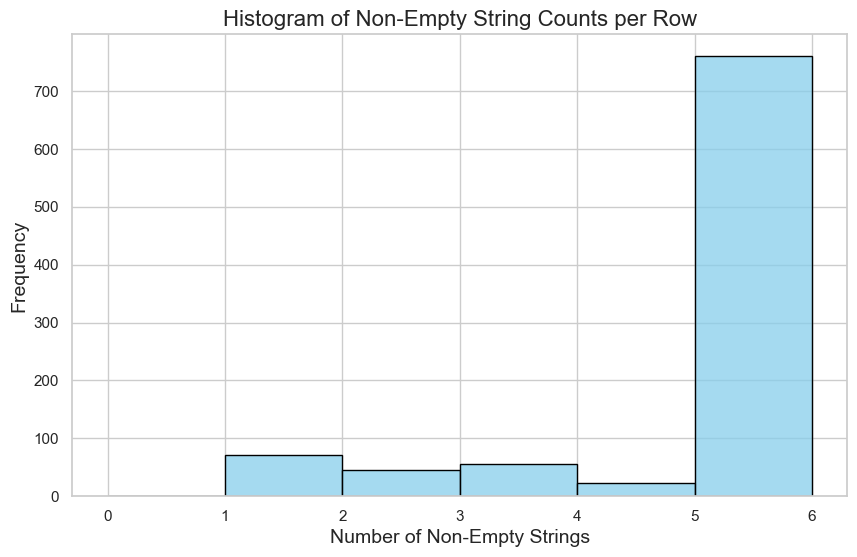

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_train['non_empty_count'] = df_train['text_series'].apply(
    lambda lst: sum(1 for item in lst if isinstance(item, str) and item.strip())
)

# Set the style for seaborn
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot the histogram using seaborn
sns.histplot(data=df_train, x='non_empty_count', bins=range(0, df_train['non_empty_count'].max() + 2), 
             kde=False, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Histogram of Non-Empty String Counts per Row', fontsize=16)
plt.xlabel('Number of Non-Empty Strings', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()


In [4]:
ts_df

,Date,Open,High,Low,Close,Adj Close,Volume,ticker,date
0,2019-12-31,72.482498,73.419998,72.379997,73.412498,71.520821,100805600,AAPL,2019-12-31
1,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152649,135480400,AAPL,2020-01-02
2,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441460,146322800,AAPL,2020-01-03
3,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018677,118387200,AAPL,2020-01-06
4,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675278,108872000,AAPL,2020-01-07
...,...,...,...,...,...,...,...,...,...
10170,2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,3703.060059,1883780000,^GSPC,2020-12-24
10171,2020-12-28,3723.030029,3740.510010,3723.030029,3735.360107,3735.360107,3535460000,^GSPC,2020-12-28
10172,2020-12-29,3750.010010,3756.120117,3723.310059,3727.040039,3727.040039,3393290000,^GSPC,2020-12-29
10173,2020-12-30,3736.189941,3744.629883,3730.209961,3732.040039,3732.040039,3154850000,^GSPC,2020-12-30


C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


torch.Size([2, 500])
torch.Size([2, 500])


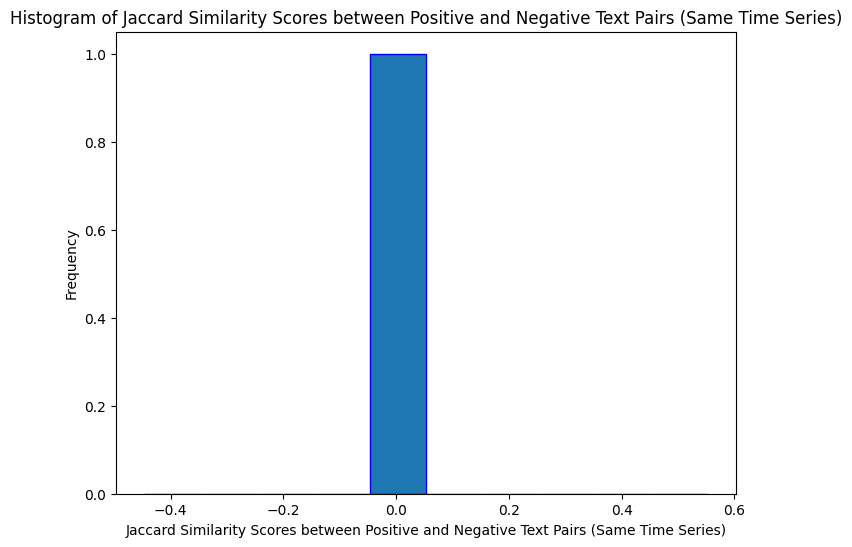

In [63]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from transformers import TimeSeriesTransformerModel, TimeSeriesTransformerConfig

def jaccard_similarity(list1, list2):
    set1 = set(" ".join(list1).split())
    set2 = set(" ".join(list2).split())
    return len(set1.intersection(set2)) / len(set1.union(set2))
i = 0

def plot_floats_as_hist(float_list, xlabel, title, colour):
    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(float_list, bins=10, edgecolor=colour)  # You can adjust 'bins' as needed

    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)

    # Show the plot
    plt.show()

def handle_tokenisation(time_series, text_series, past_time_features, tokenizer, label):
        #helper method reflecting the custom dataset class' input processing
        ts_data = [{
            "past_time_values": torch.tensor(time_series, dtype=torch.float32),
            "past_observed_mask": torch.ones(1, len(time_series), dtype=torch.long),
            "past_time_features": torch.tensor([past_time_features], dtype=torch.float32)
        }]

        #loop over all text and tokenize
        text_data = [tokenizer.text_tokenizer(text, return_tensors="pt", truncation=True, padding='max_length') for text in text_series]
        
        input_ids = torch.stack([item['input_ids'].squeeze(0) for item in text_data])  # Shape: [number_of_texts, length_of_text]
        attention_mask = torch.stack([item['attention_mask'].squeeze(0) for item in text_data])  # Shape: [number_of_texts, length_of_text]
        text_data = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

        label = torch.tensor(label, dtype=torch.long)
        return ts_data, text_data, label

def get_similarity_metrics(df, model, tokenizer, device):
    model.to(device)
    jaccard_similarities = []
    df = dh3.correct_negative_labels(df, negative_label=-1)
    i = 0
    for unique_ts_id in df['ts_id'].unique().tolist():
        
        #print(df[df["ts_id"] == unique_ts_id])
        positive_text = df[(df["ts_id"] == unique_ts_id) & (df["label"] == 1)]
        negative_text = df[(df["ts_id"] == unique_ts_id) & (df["label"] == -1)]
        
        #get jaccard similarity
        jaccard_similarity_score = jaccard_similarity(positive_text['text_series'].tolist()[0], negative_text['text_series'].tolist()[0])
        jaccard_similarities.append(jaccard_similarity_score)
        #get embedding similarity between pos and neg text pairs
        filtered_df = df[(df["ts_id"] == unique_ts_id)]

        #get embedding similarity between positive text / ts and negative text / ts
        data_loader = DataLoader(dh3.CustomDataset(df=filtered_df, text_tokenizer=tokenizer, ts_col='time_series', text_col='text_series', label_col='label'), batch_size=2, shuffle=False)
        
        for ts_data, text_data, labels in data_loader:
            ts_data = {
                "past_time_values": torch.stack([d['past_time_values'].squeeze(1) for d in ts_data], dim=0).to(device),
                "past_observed_mask": torch.stack([d['past_observed_mask'].squeeze(0) for d in ts_data], dim=0).to(device),
                "past_time_features": torch.stack([d['past_time_features'].squeeze(0) for d in ts_data], dim=0).to(device)
            }
            text_data['input_ids'] = text_data['input_ids'].to(device)
            text_data['attention_mask'] = text_data['attention_mask'].to(device)
            
            ts_embeddings, text_embeddings = model(ts_data, text_data)
            similarity = cosine_similarity(ts_embeddings, text_embeddings)
        #positive_ts_data, positive_text_data, positive_label = handle_tokenisation(time_series=positive_text['time_series'], 
        #                                                                           text_series=positive_text['text_series'],
        #                                                                           past_time_features=positive_text['past_time_features'], 
        #                                                                           tokenizer=tokenizer, 
        #                                                                           label=positive_text['label'])
        #negative_ts_data, negative_text_data, negative_label = handle_tokenisation(time_series=negative_text['time_series'], 
        #                                                                           text_series=negative_text['text_series'],
        #                                                                           past_time_features=negative_text['past_time_features'], 
        #                                                                           tokenizer=tokenizer, 
        #                                                                           label=negative_text['label'])
        

        

        i += 1
        if i > 0:
            break
    plot_floats_as_hist(float_list=jaccard_similarities, xlabel="Jaccard Similarity Scores between Positive and Negative Text Pairs (Same Time Series)", title="Histogram of Jaccard Similarity Scores between Positive and Negative Text Pairs (Same Time Series)", colour="blue")

model_param_grid = {
            "ts_encoder": [{"name": 'TimeSeriesTransformerModel'}],#{"name": 'AutoFormerModel'}, {"name": "InformerModel"}],
            "text_encoder": [{"name": 'bert-base-uncased'}, {"name": 'bert-base-cased'}],                                                                     
            "text_aggregation_method": ["mean", 'max'],                                                    
            "projection_dim": [500],  
        }

ts_encoder                  = model_param_grid["ts_encoder"][0]
ts_encoder['ts_window']     = 4
ts_encoder['context_length'] = 1
ts_encoder['prediction_length']= 0
ts_encoder['lags_sequence'] = [i + 1 for i in range(ts_window - 1)]
ts_encoder['num_features']  = 3
projection_dim = model_param_grid['projection_dim'][0]
text_encoder                = model_param_grid["text_encoder"][0]
text_aggregation = model_param_grid['text_aggregation_method'][0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(text_encoder['name'])
model = mh.get_model(ts_encoder_config=ts_encoder, text_encoder_config=text_encoder, projection_dim=projection_dim, ts_window=ts_window, text_aggregation=text_aggregation)
get_similarity_metrics(df=df, model=model, tokenizer=tokenizer, device=device)

In [6]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import TimeSeriesTransformerModel, TimeSeriesTransformerConfig
from torch.utils.data import DataLoader, Dataset

# Create time features (e.g., weekday)
def generate_time_features(df):
    df['weekday'] = df['Date'].dt.weekday  # Day of the week (0=Monday, ..., 6=Sunday)
    time_features = df[['weekday']].values
    return torch.tensor(time_features, dtype=torch.float32)

# Create observed mask (all ones since we assume no missing data)
def generate_observed_mask(df):
    observed_mask = torch.ones((len(df), context_length), dtype=torch.float32)
    return observed_mask
df = ts_df

# Parameters
context_length = 5  # Number of past days to consider
prediction_length = 1  # Predict the next day's value
is_multivariate = True  # Set to False for univariate

# Prepare dataset
class StockDataset(Dataset):
    def __init__(self, df, context_length, prediction_length, is_multivariate=True):
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.is_multivariate = is_multivariate
        
        if self.is_multivariate:
            self.features = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values
        else:
            self.features = df[['Close']].values
        
        self.targets = df['Close'].values
        self.time_features = generate_time_features(df)
        self.observed_mask = generate_observed_mask(df)

    def __len__(self):
        return max(0, len(self.features) - self.context_length - self.prediction_length + 1)

    def __getitem__(self, idx):
        x = self.features[idx:idx+self.context_length]
        y = self.targets[idx+self.context_length:idx+self.context_length+self.prediction_length]
        time_features = self.time_features[idx:idx+self.context_length]
        observed_mask = self.observed_mask[idx:idx+self.context_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), time_features, observed_mask


# Assuming df is your original dataframe
df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
df = df.sort_values('Date')  # Sort by Date to maintain the time sequence

# Define the split point based on the timestamp
split_date = '2020-03-15'  # This is just an example, adjust based on your data

# Split into train and test dataframes based on the split date
train_df = df[df['Date'] < split_date]
test_df = df[df['Date'] >= split_date]

print(f"Training set from {train_df['Date'].min()} to {train_df['Date'].max()}")
print(f"Test set from {test_df['Date'].min()} to {test_df['Date'].max()}")

# Example of setting up DataLoader
train_dataset = StockDataset(train_df, context_length, prediction_length, is_multivariate)
test_dataset = StockDataset(test_df, context_length, prediction_length, is_multivariate)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Define model
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=context_length,
    num_time_features=train_dataset[0][0].shape[1]  # Number of features per timestep
)

model = TimeSeriesTransformerModel(config)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()

# Training loop
def train_model(model, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y, time_features, observed_mask in train_loader:
            optimizer.zero_grad()
            outputs = model(
                past_values=x.unsqueeze(-1),
                past_time_features=time_features.unsqueeze(-1),  # Add time features
                past_observed_mask=observed_mask.unsqueeze(-1)   # Add observed mask
            ).last_hidden_state.squeeze(-1)
            
            loss = loss_fn(outputs[:, -prediction_length:], y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")


# Train the model
train_model(model, train_loader, epochs=10)

# Inference (Testing)
def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for x, y, time_features, observed_mask in test_loader:
            outputs = model(
                past_values=x.unsqueeze(-1),
                past_time_features=time_features.unsqueeze(-1),
                past_observed_mask=observed_mask.unsqueeze(-1)
            ).last_hidden_state.squeeze(-1)
            
            predictions.append(outputs[:, -prediction_length:].numpy())
    return predictions

predictions = predict(model, test_loader)
print("Predictions:", predictions)


Training set from 2019-12-31 00:00:00 to 2020-03-13 00:00:00
Test set from 2020-03-16 00:00:00 to 2020-12-31 00:00:00


C:\Users\eoinp\AppData\Local\Temp\ipykernel_31316\1083539468.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df['Date'].dt.weekday  # Day of the week (0=Monday, ..., 6=Sunday)
C:\Users\eoinp\AppData\Local\Temp\ipykernel_31316\1083539468.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df['Date'].dt.weekday  # Day of the week (0=Monday, ..., 6=Sunday)


RuntimeError: The size of tensor a (6) must match the size of tensor b (5) at non-singleton dimension 2

# Shannon Entropy Calculation
- Overall
- For each TS
- For the subset data
- Industry based
- Split based

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\models\bert\mod

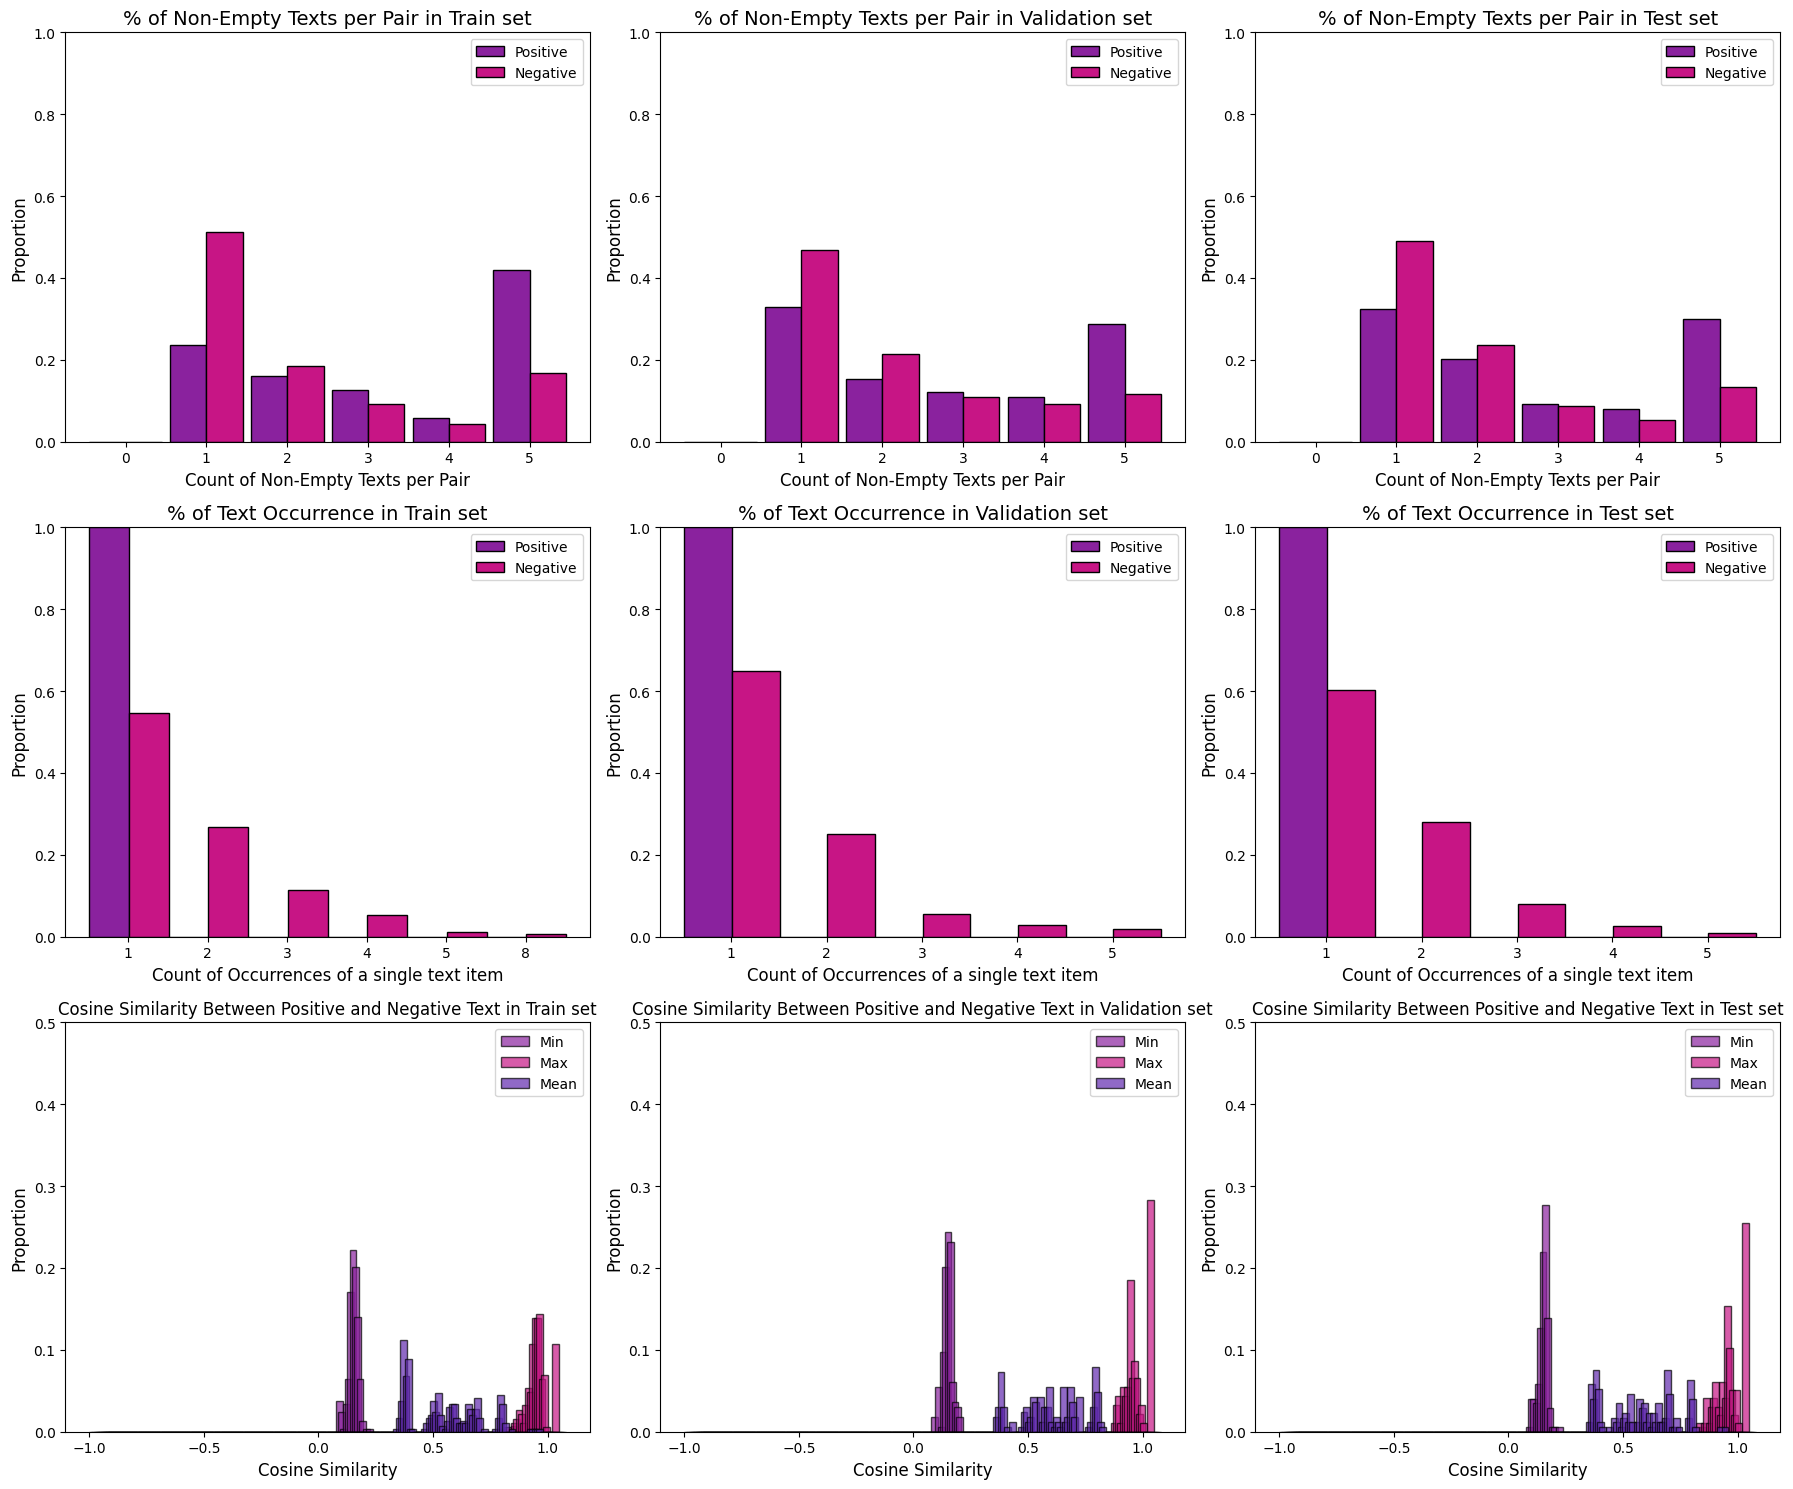

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData

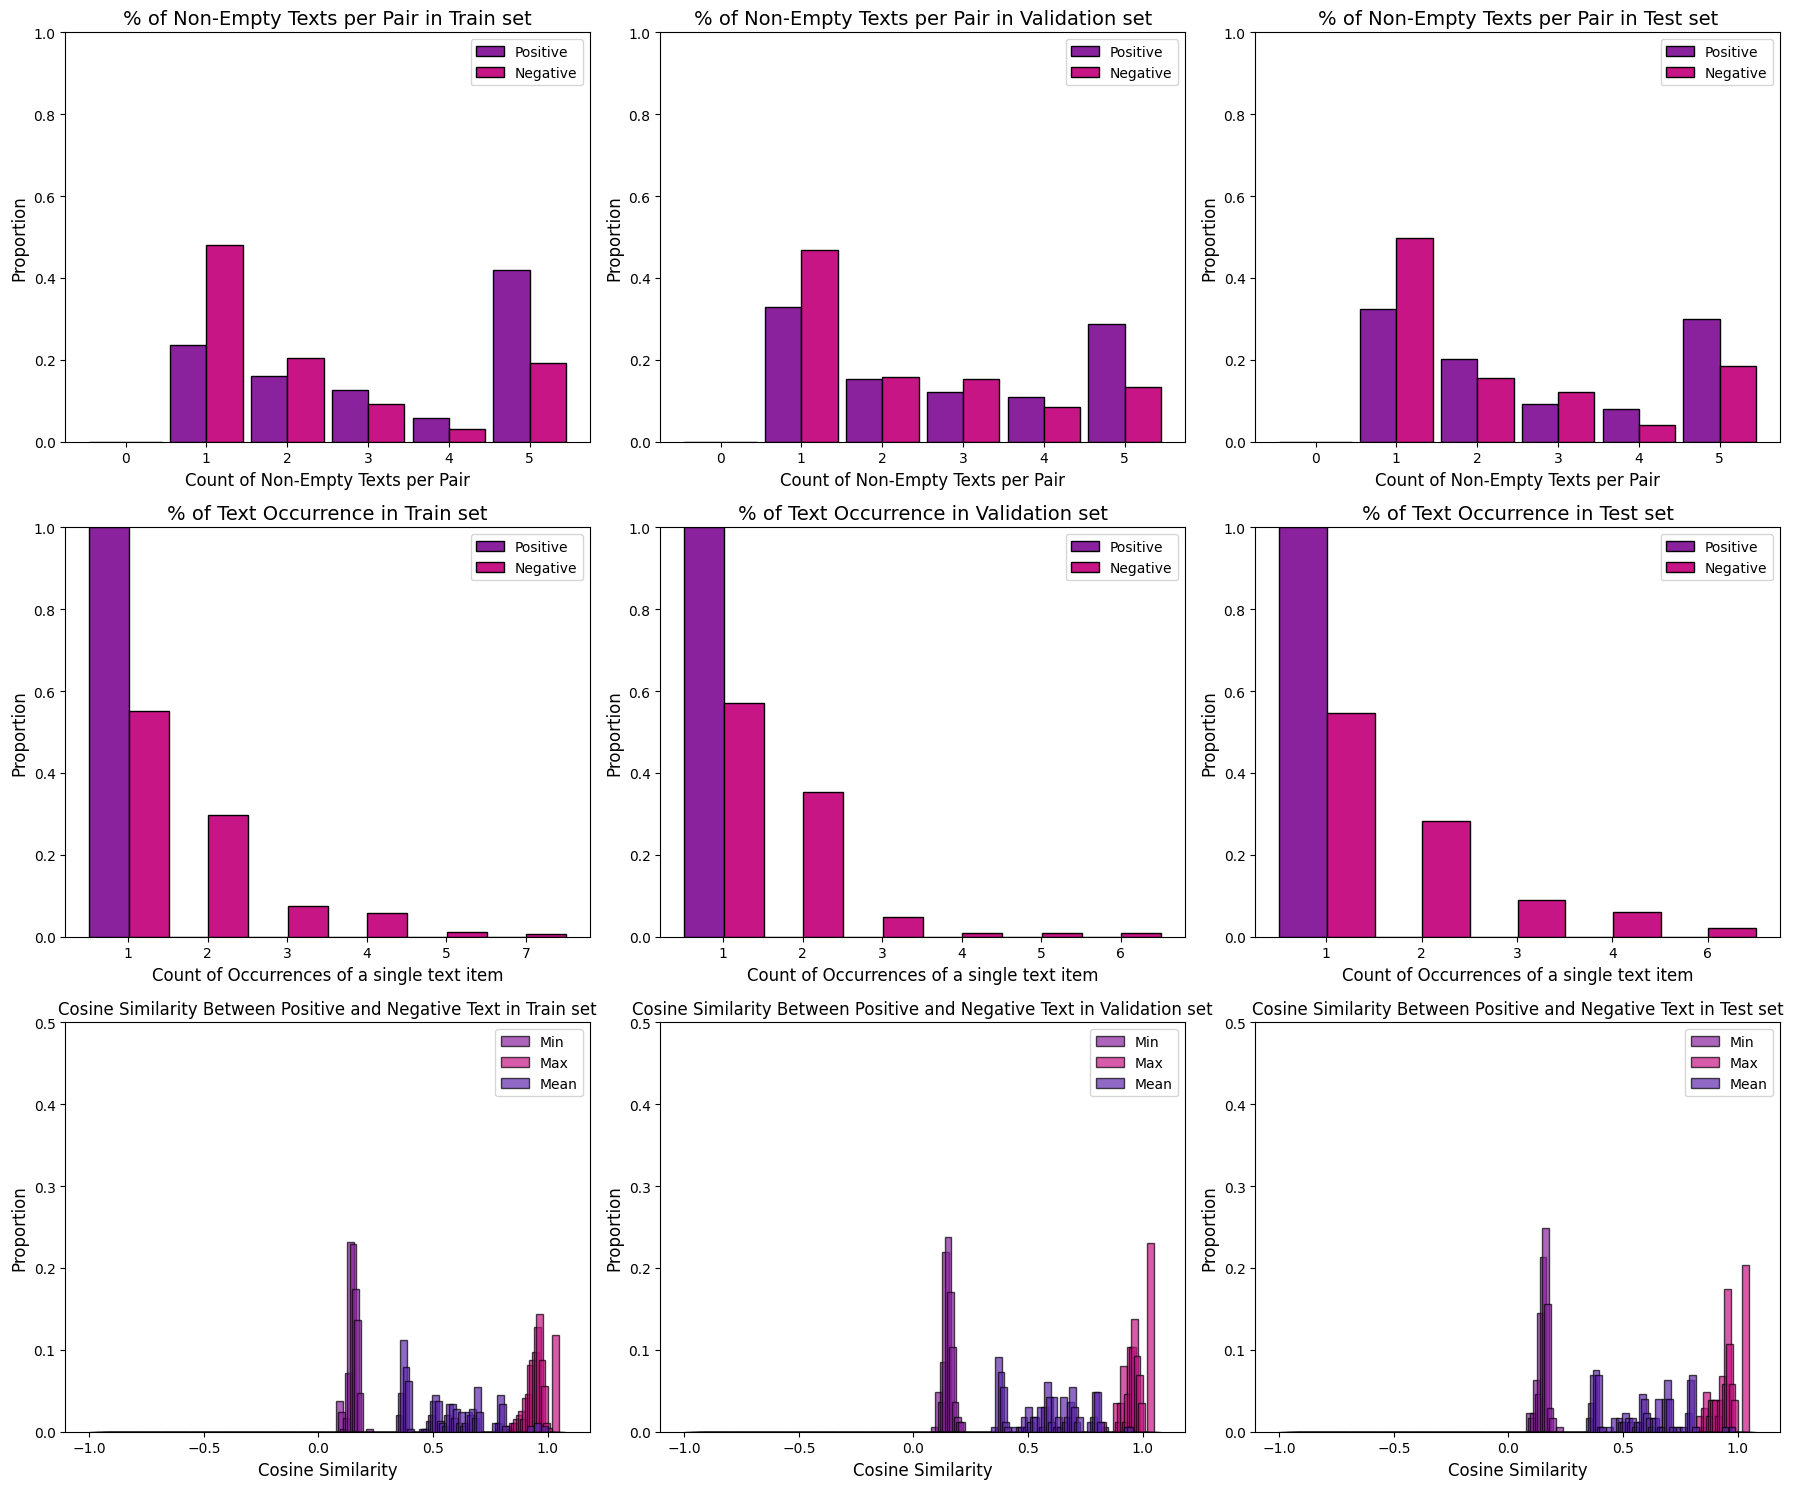

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transforme

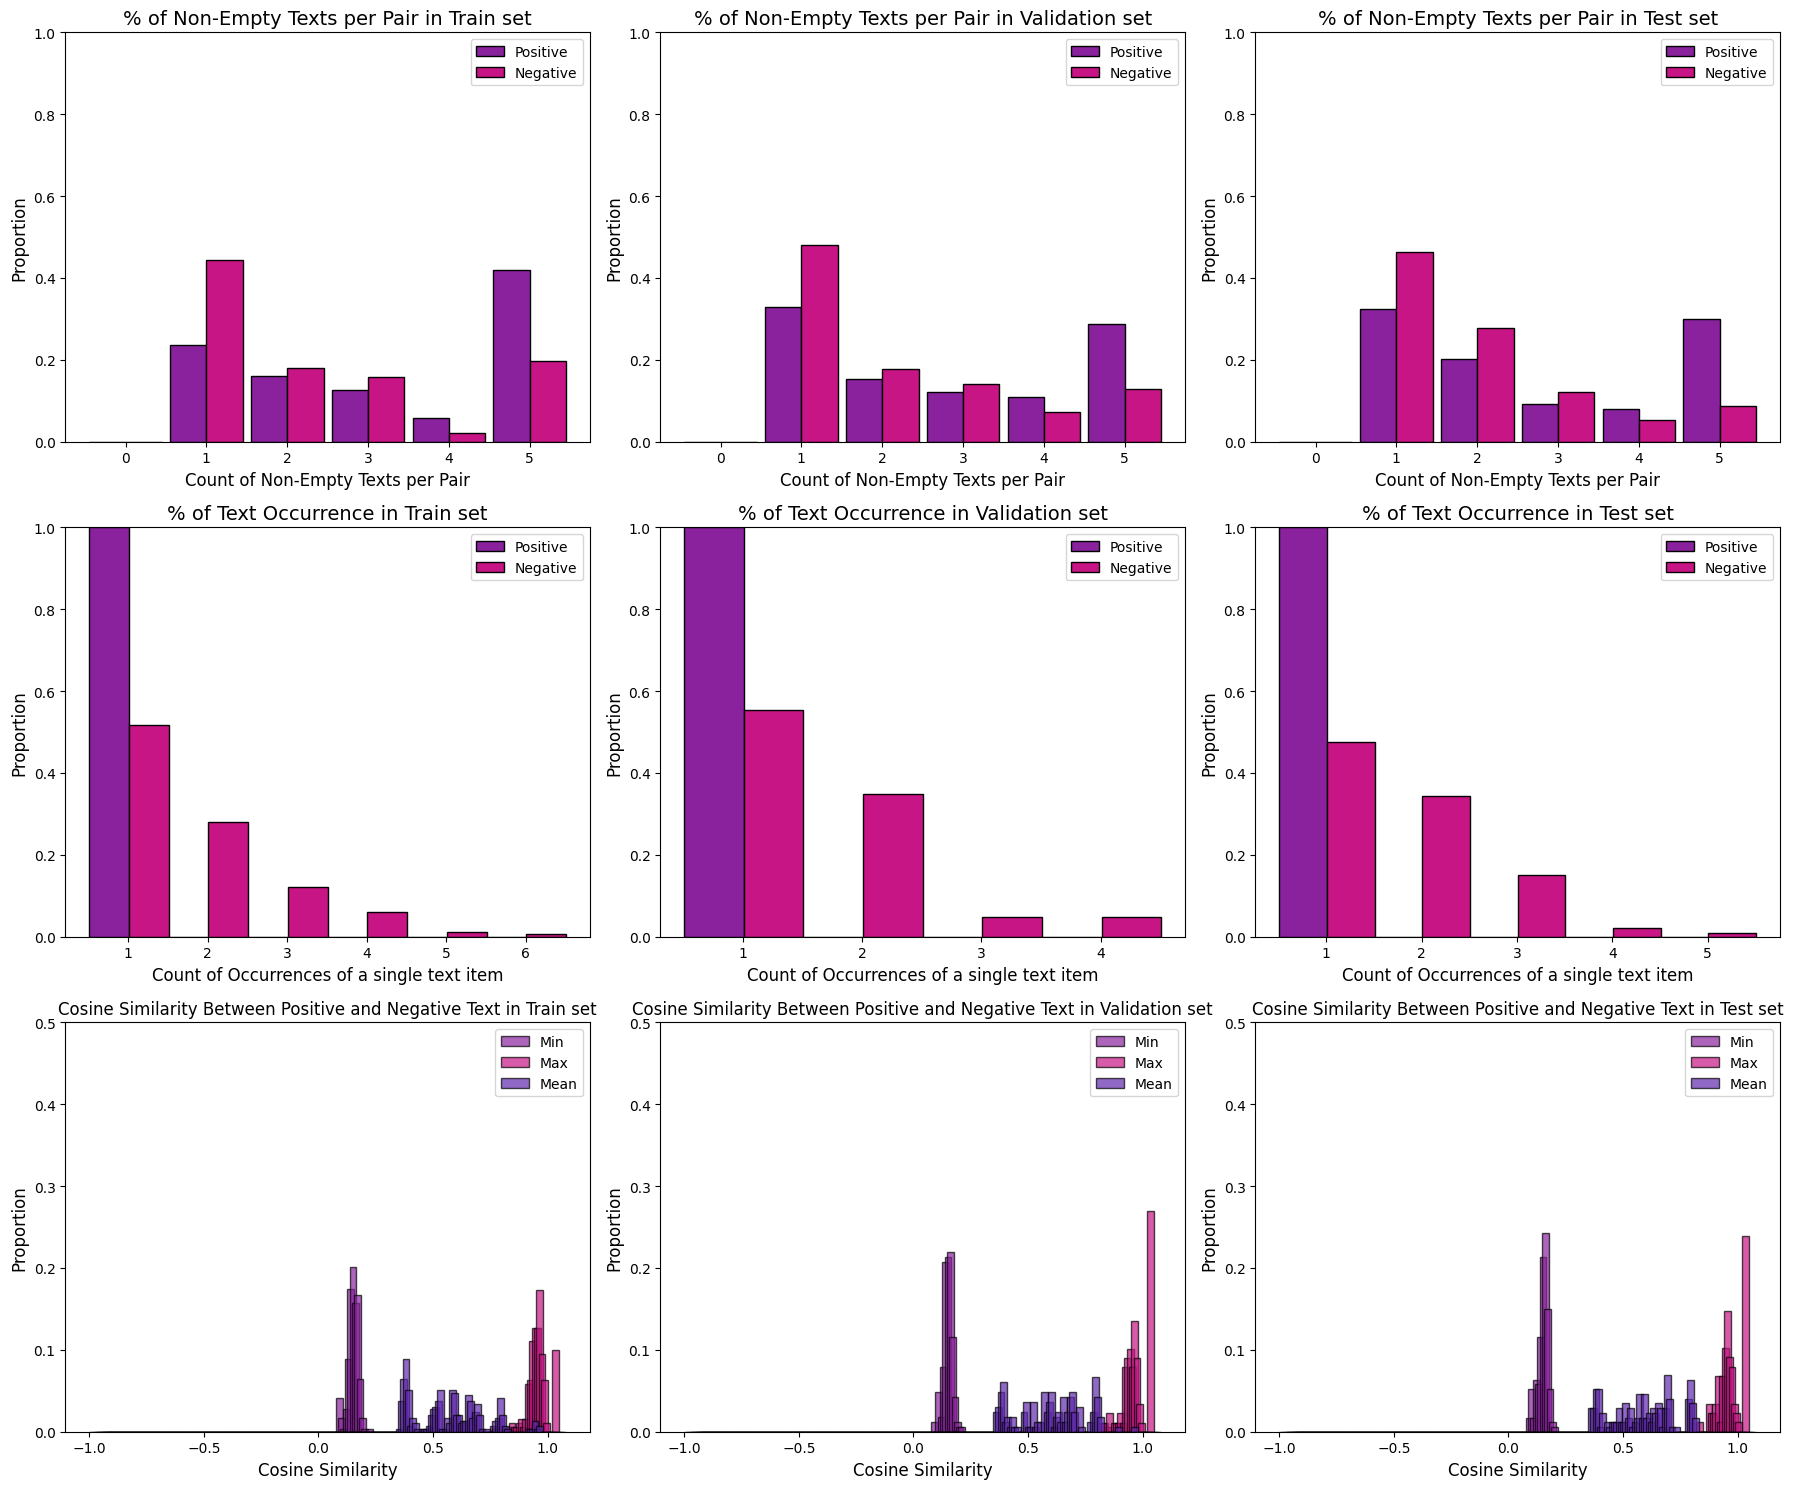

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData

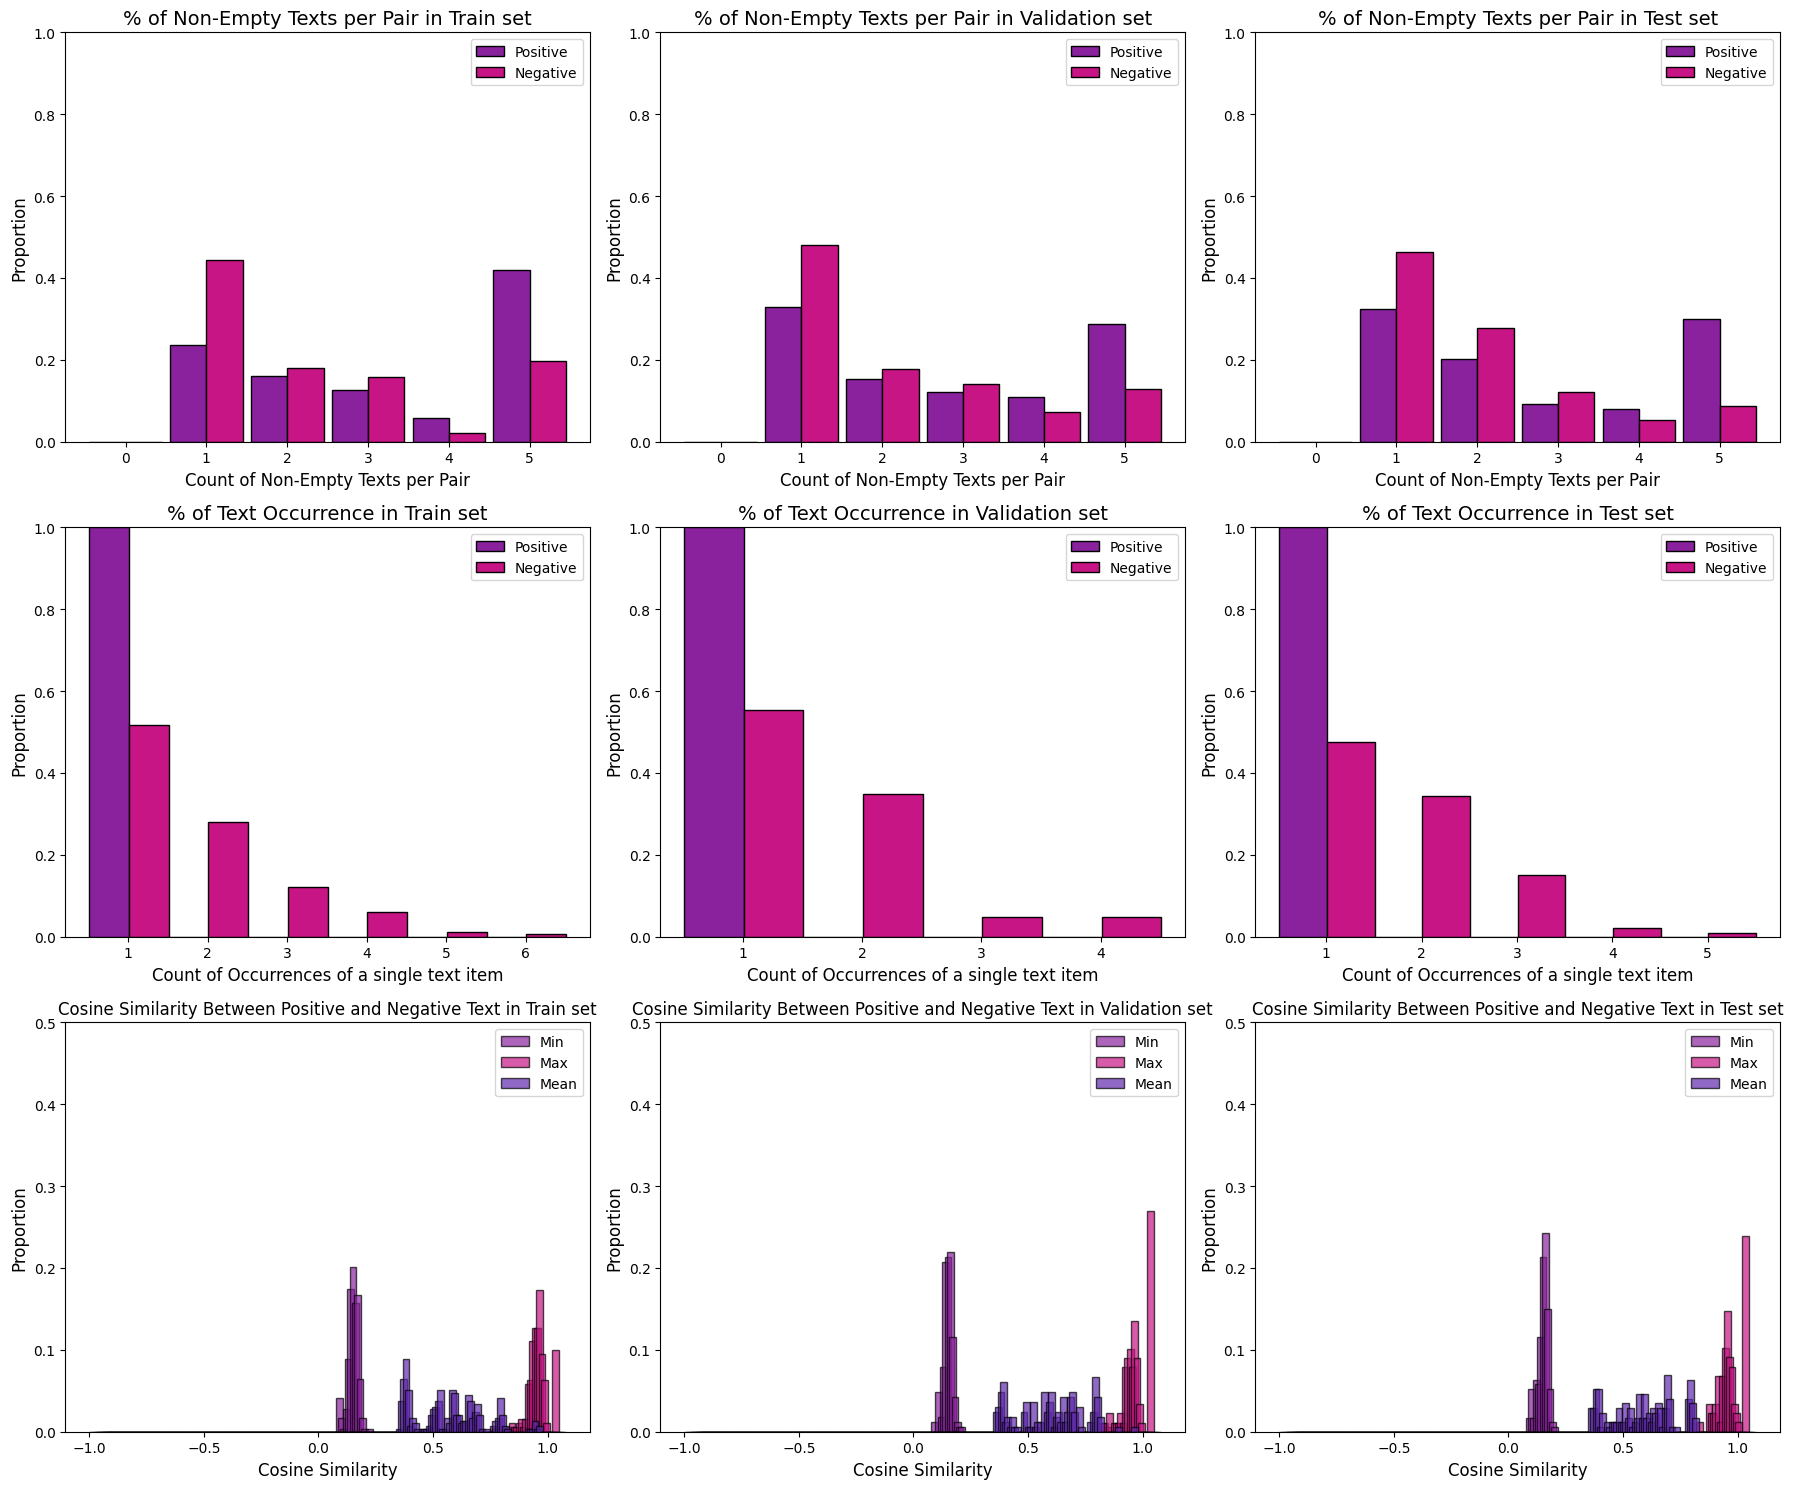

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


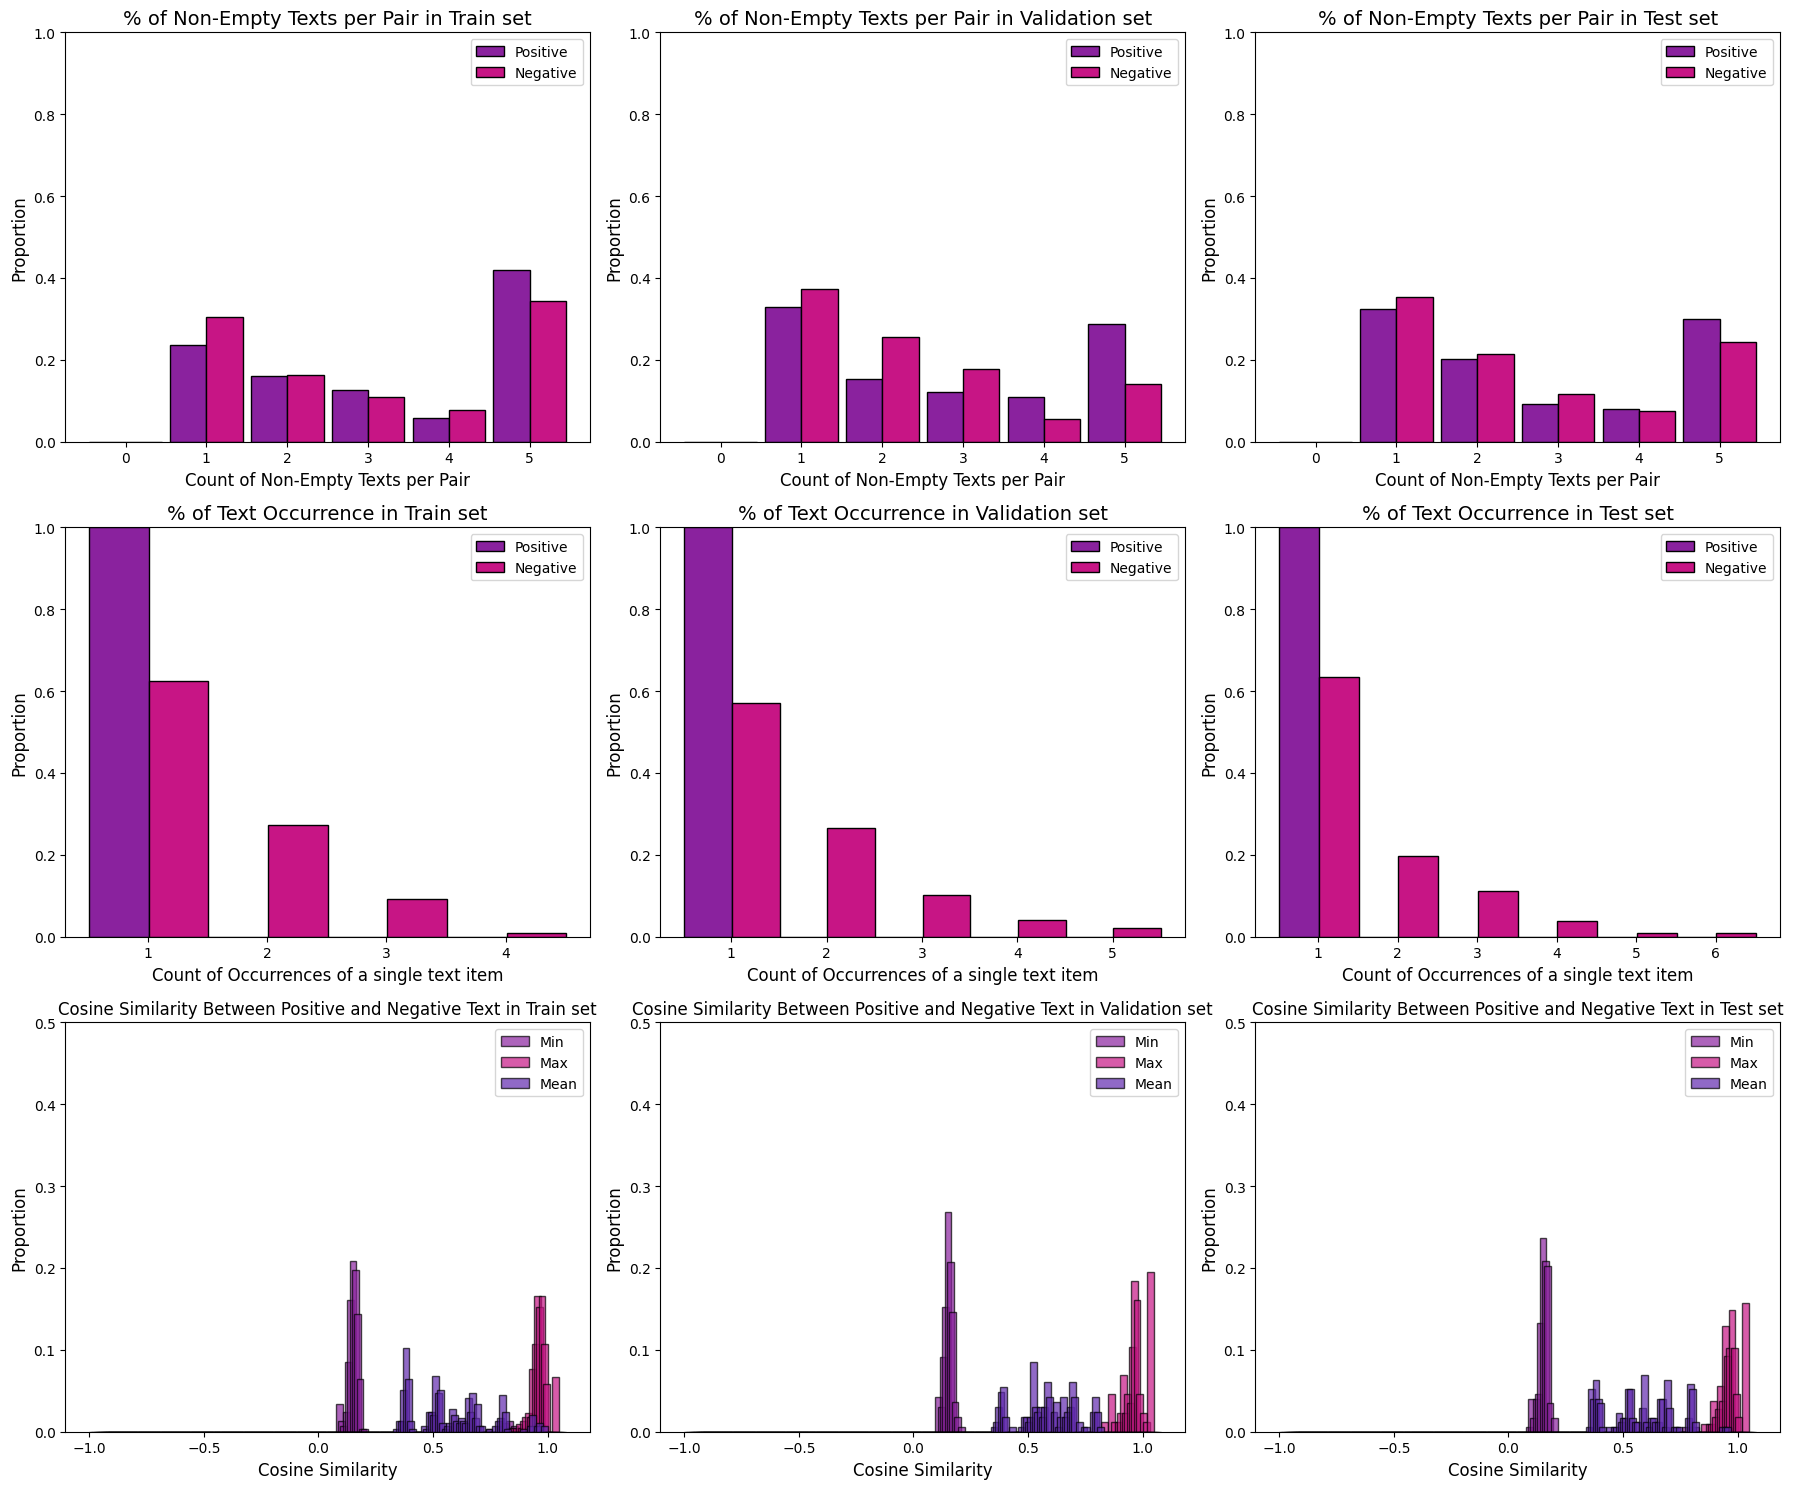

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData

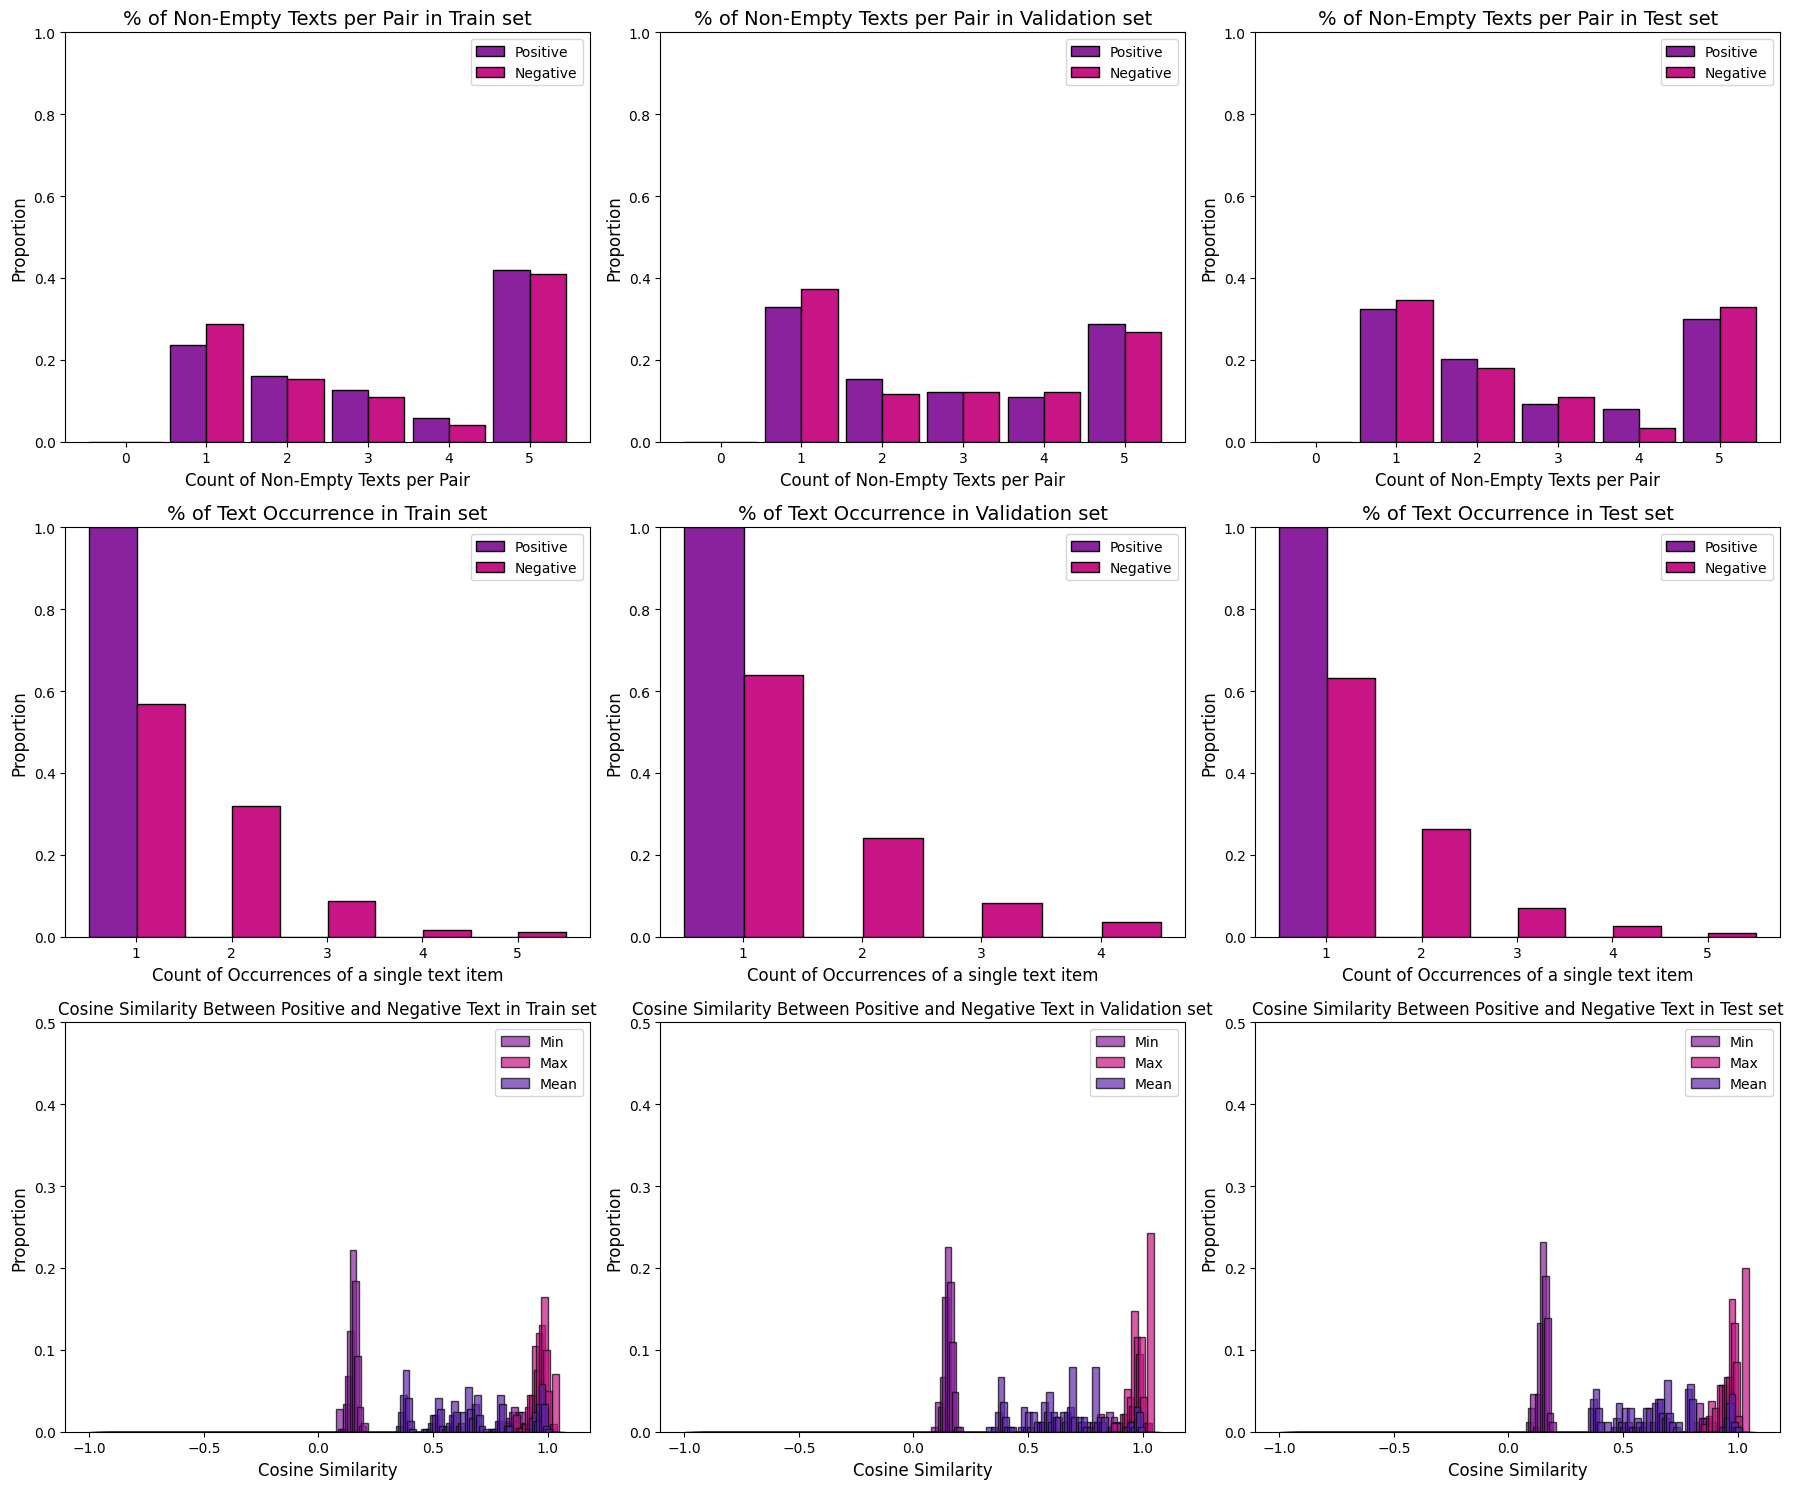

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData

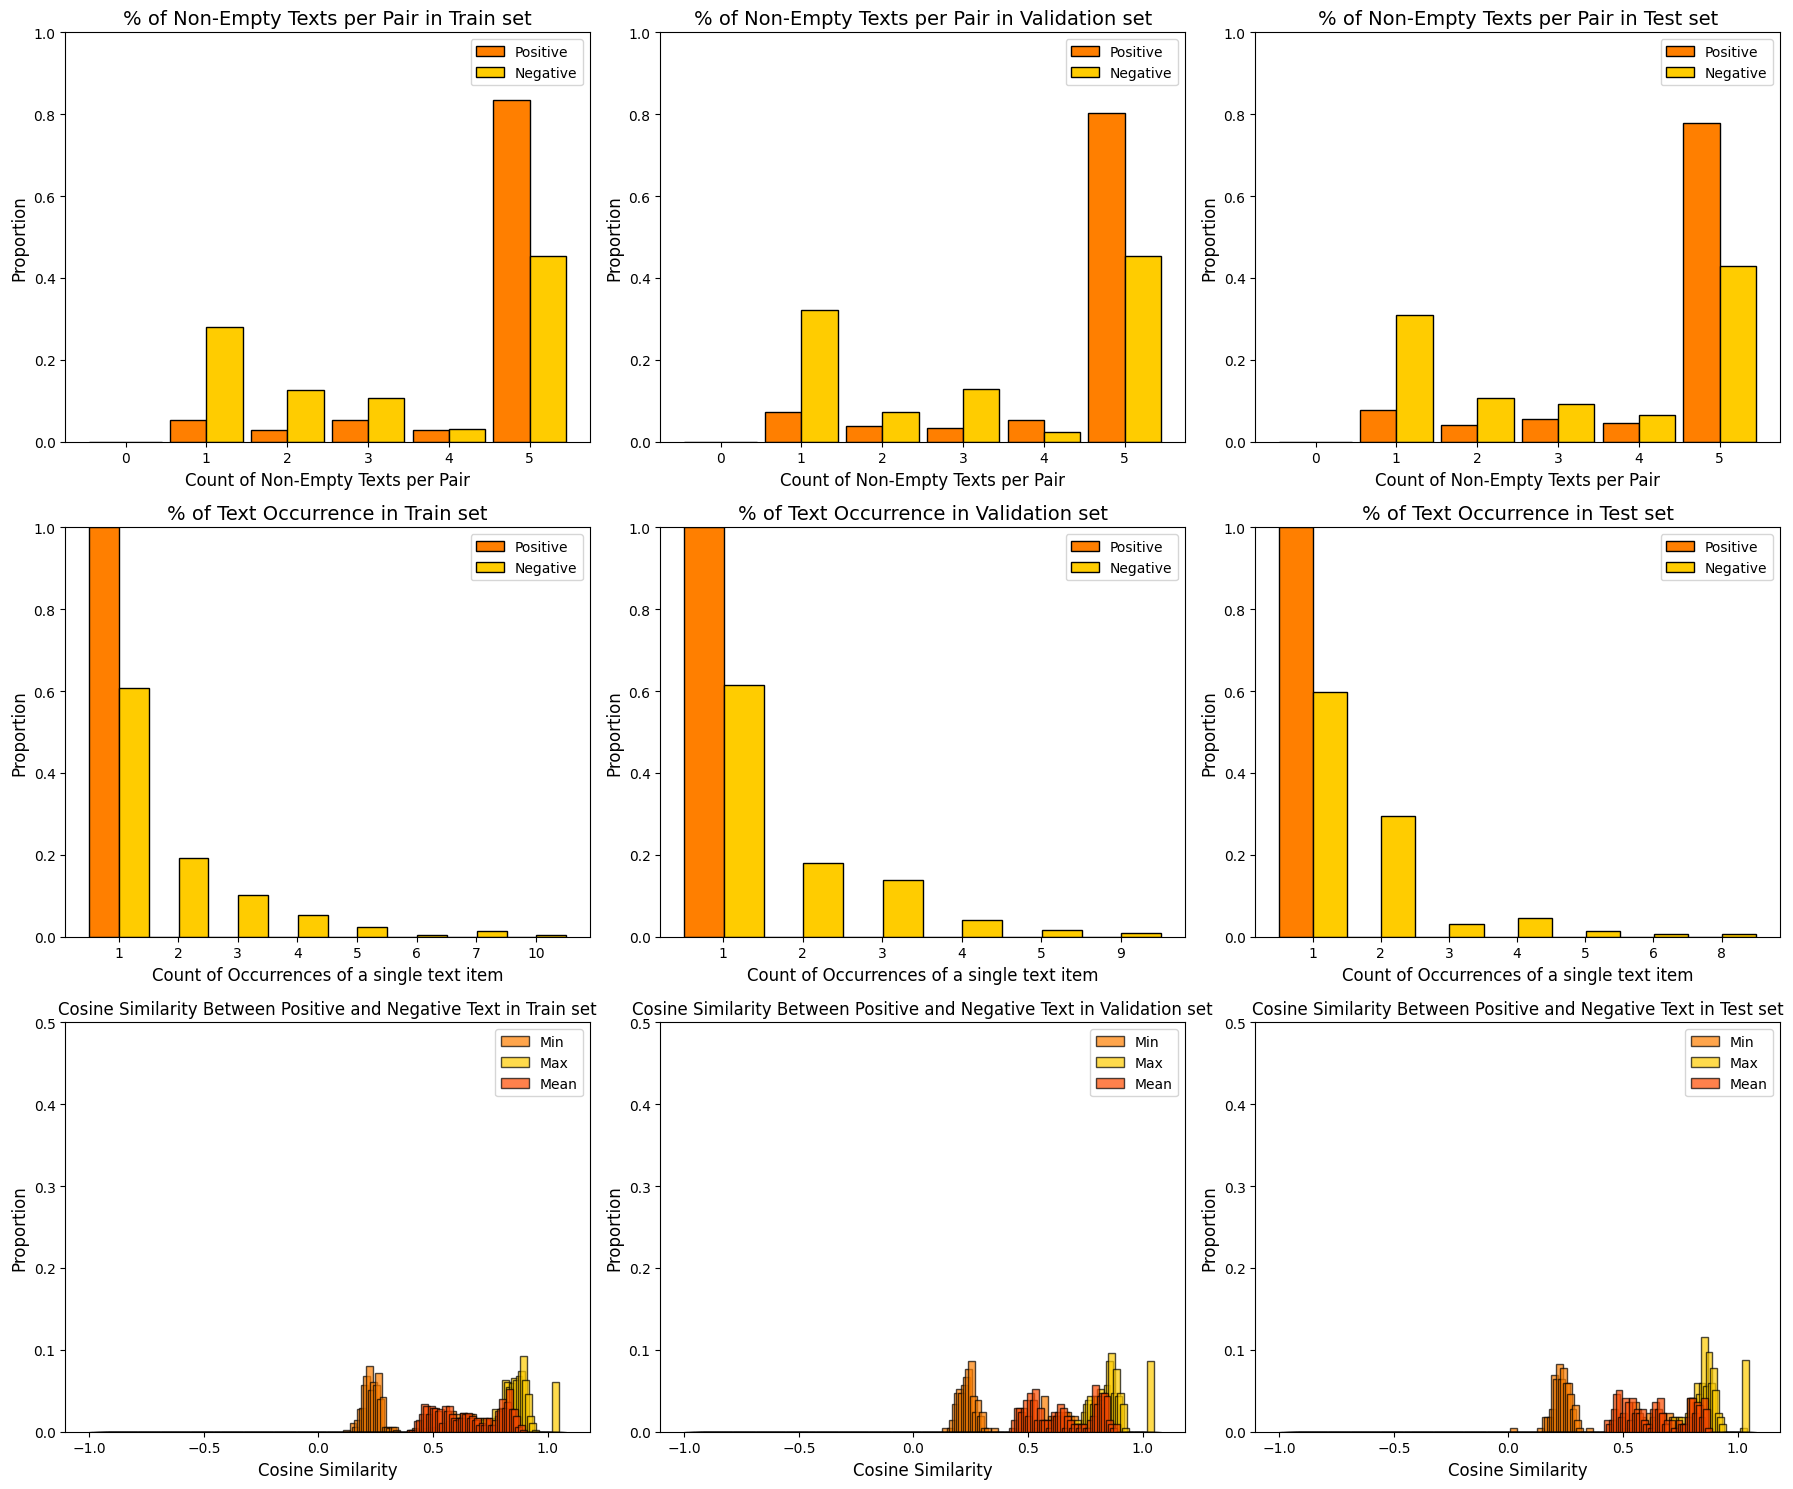

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData

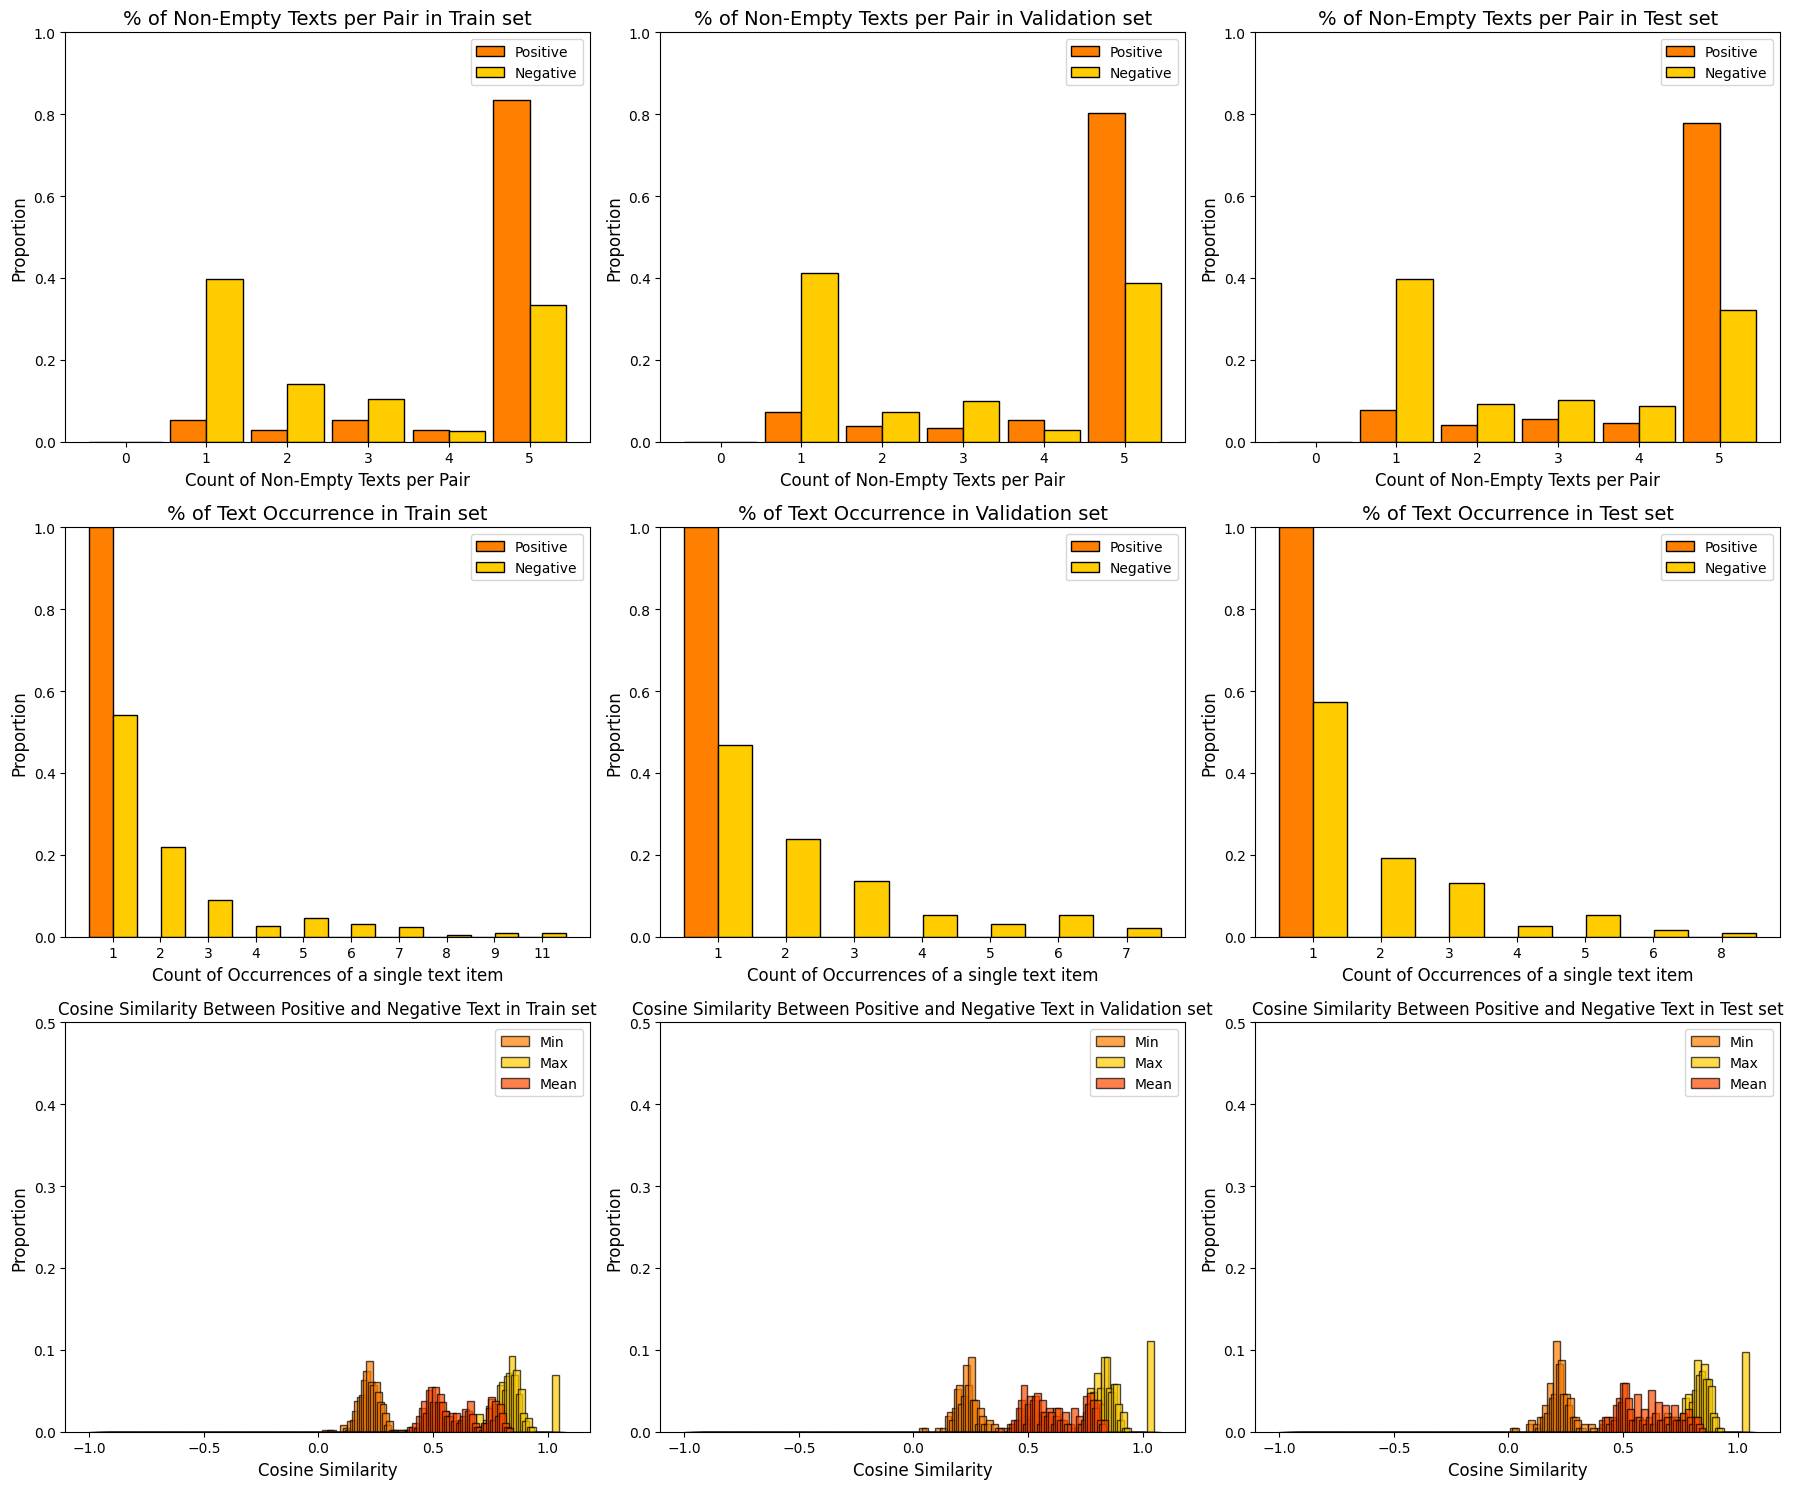

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 25/25 [00:00<00:00, 71.84it/s]
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transfor

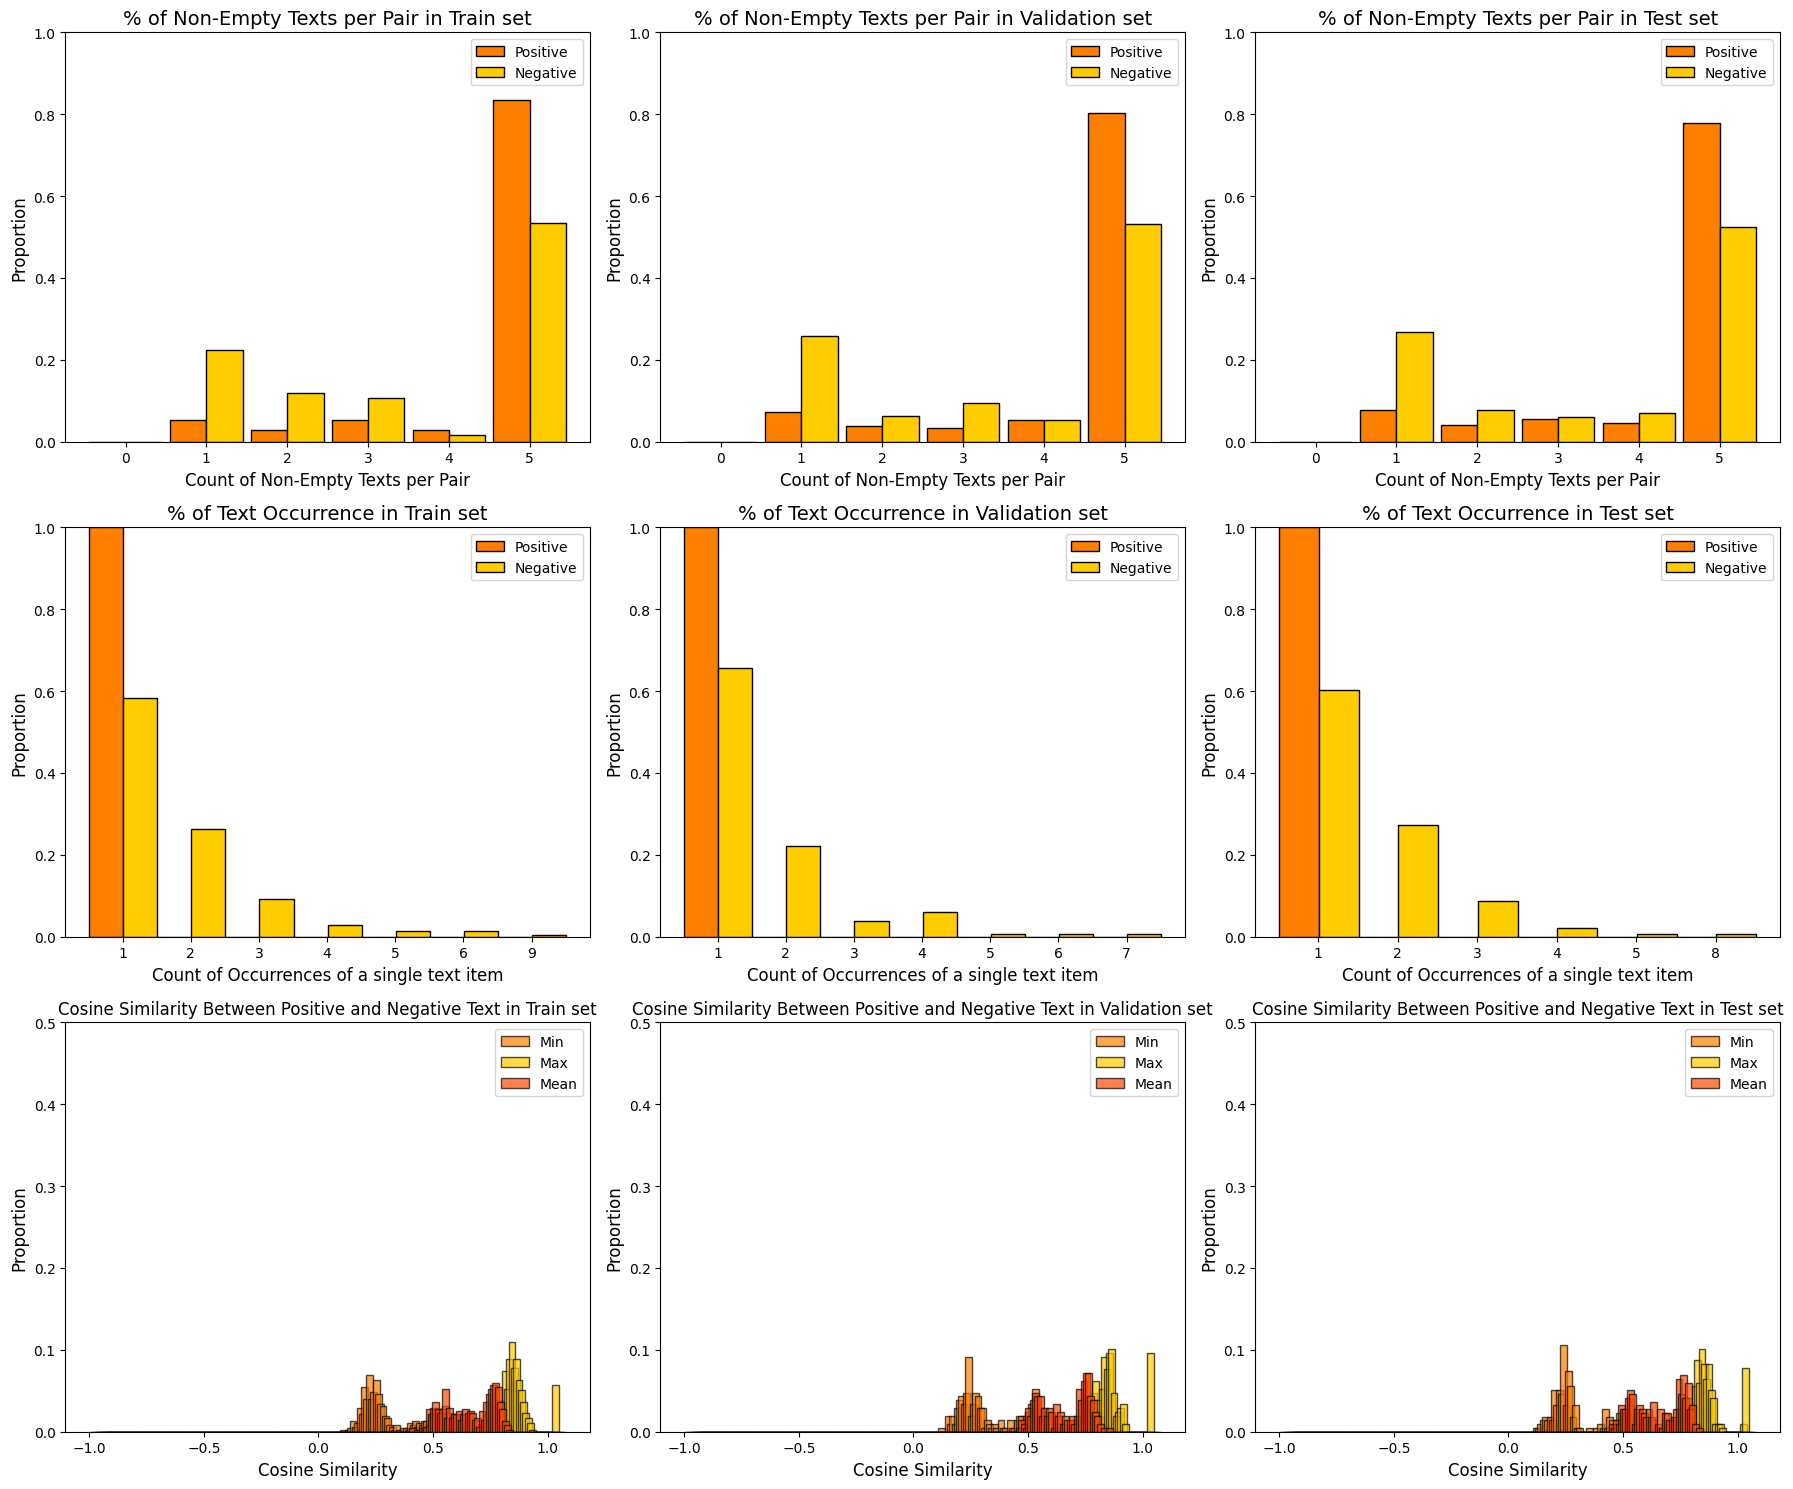

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData

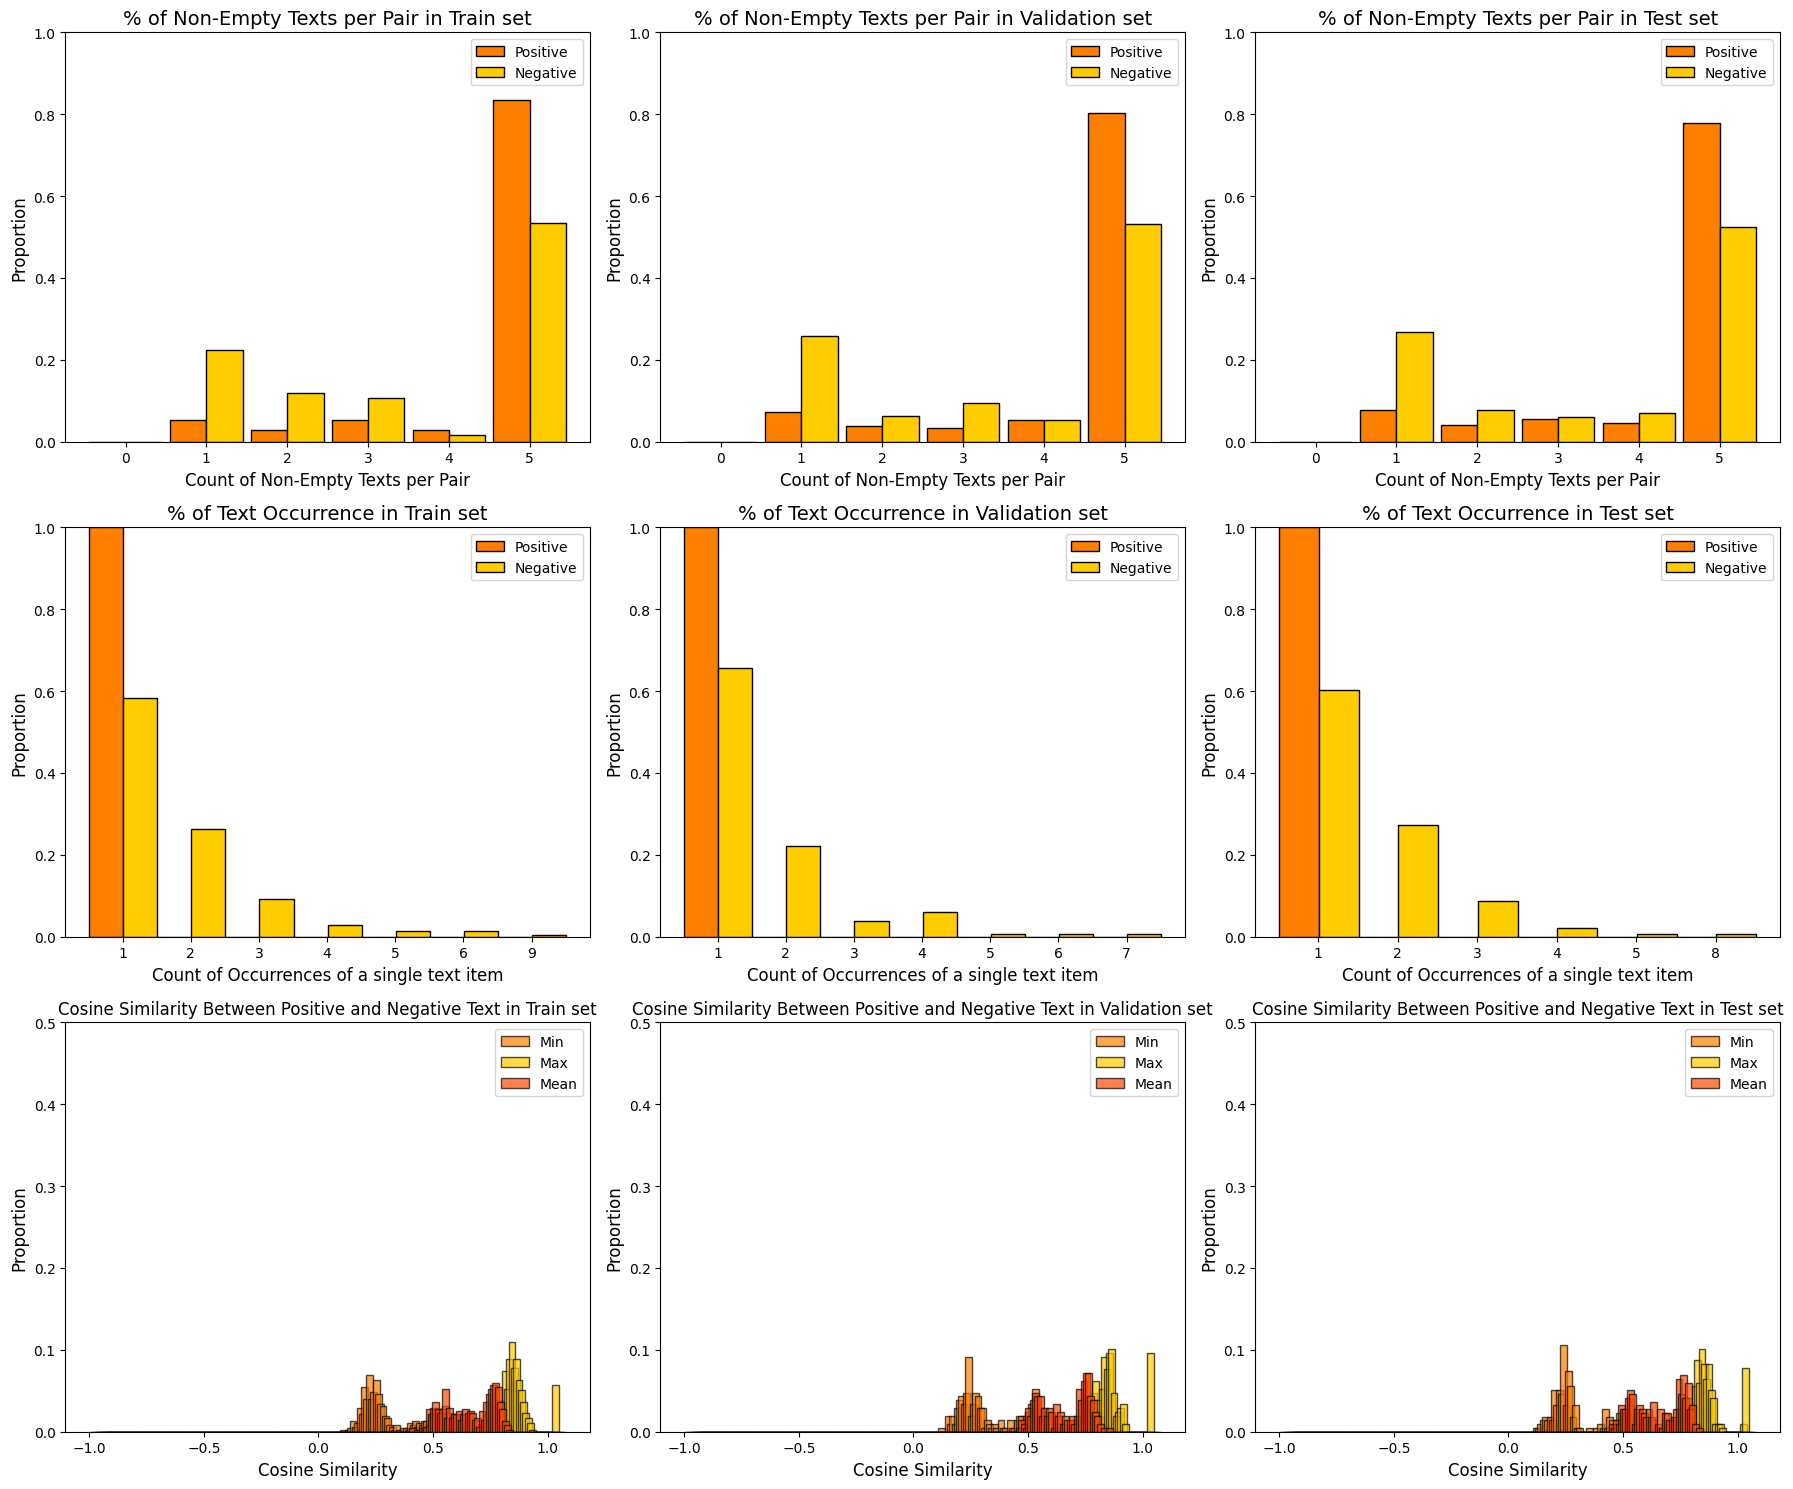

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


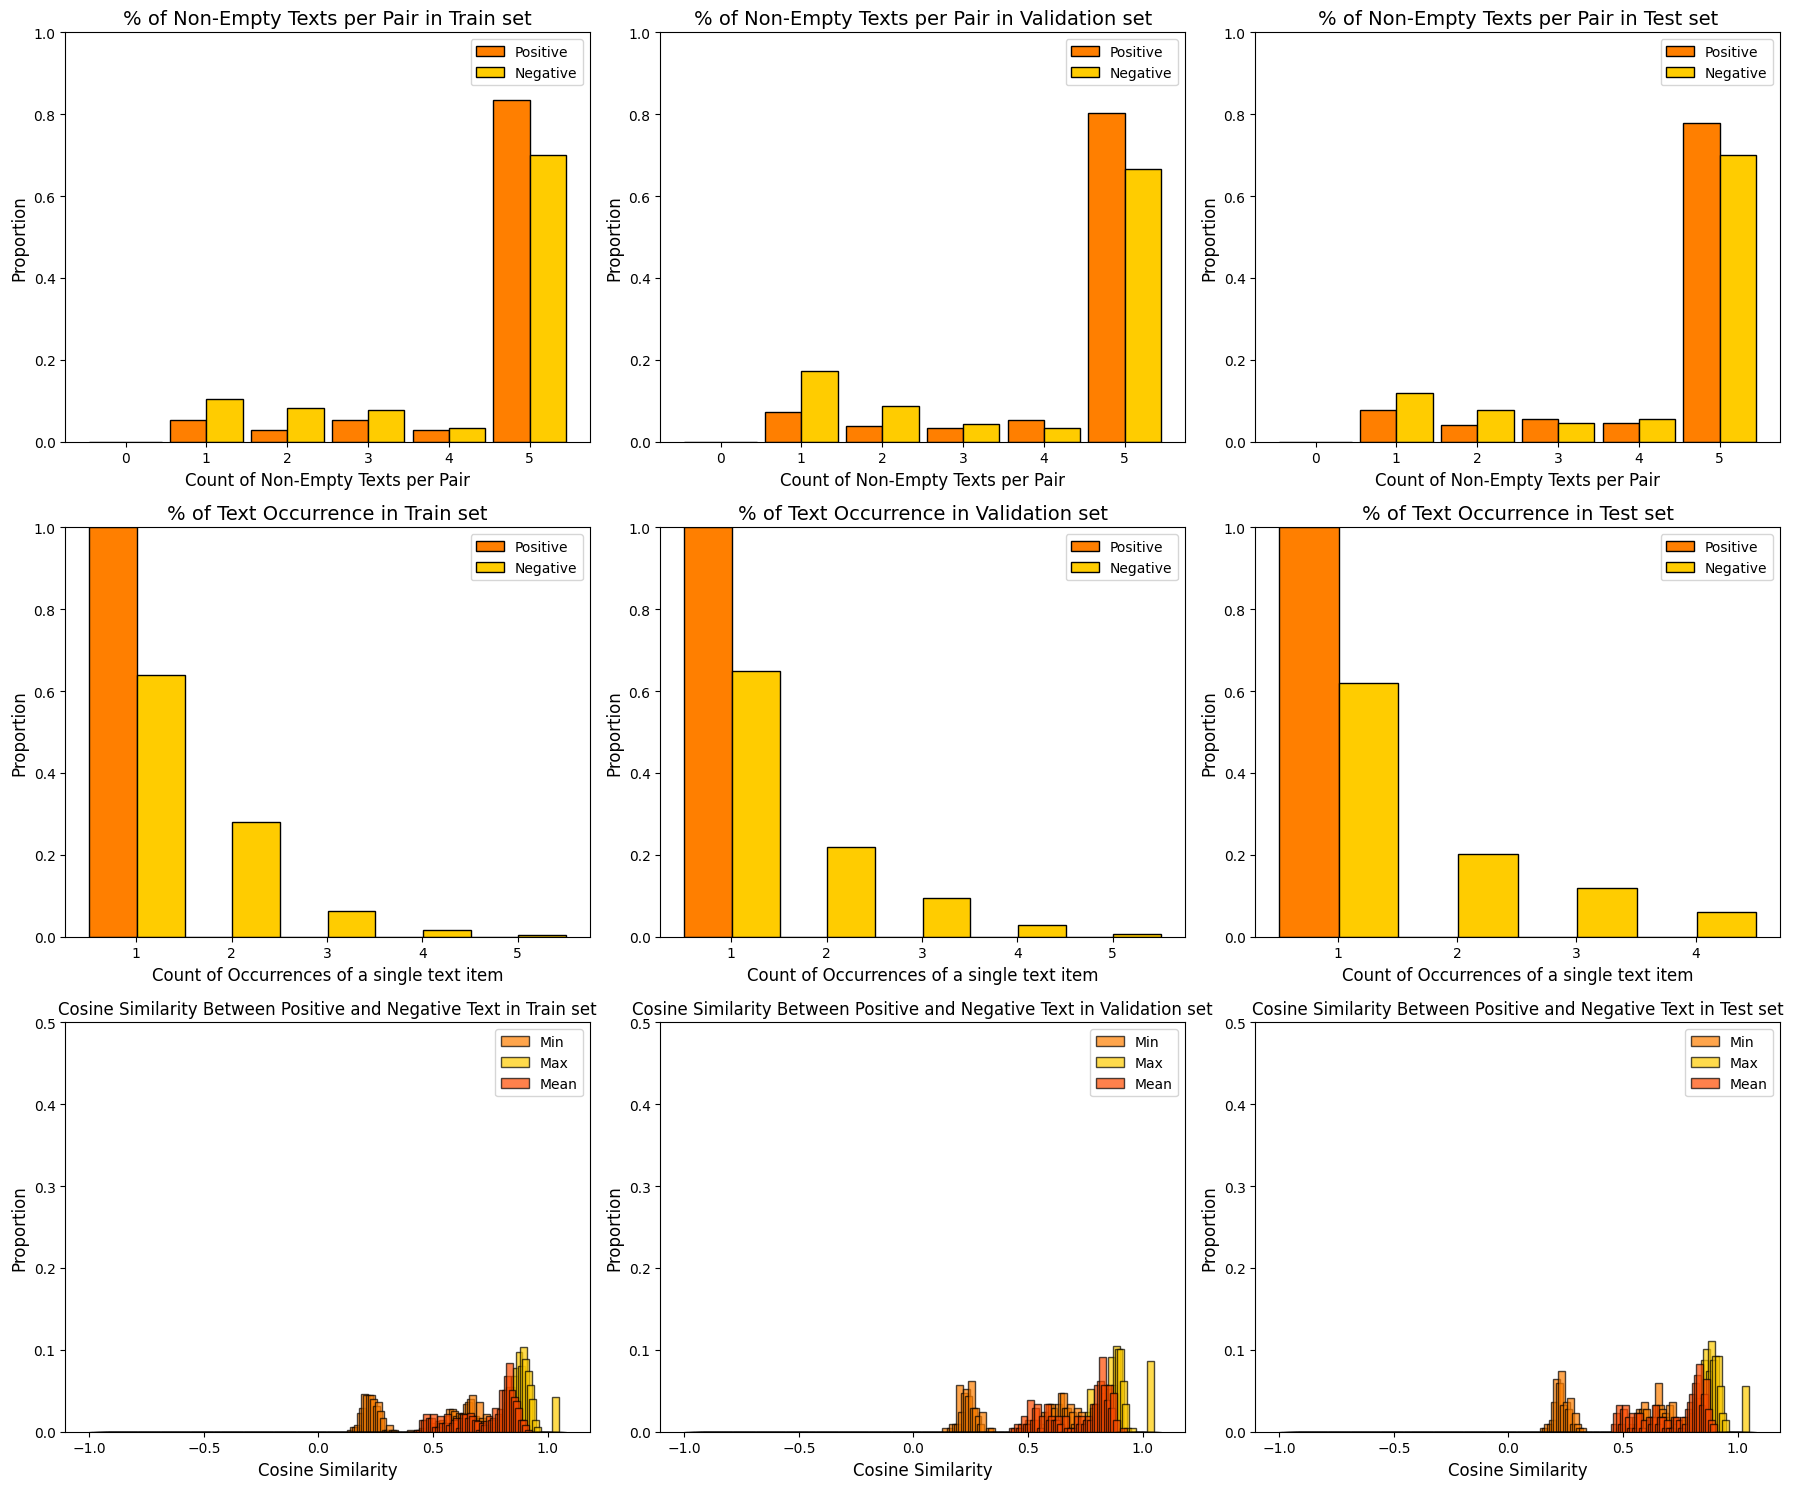

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData

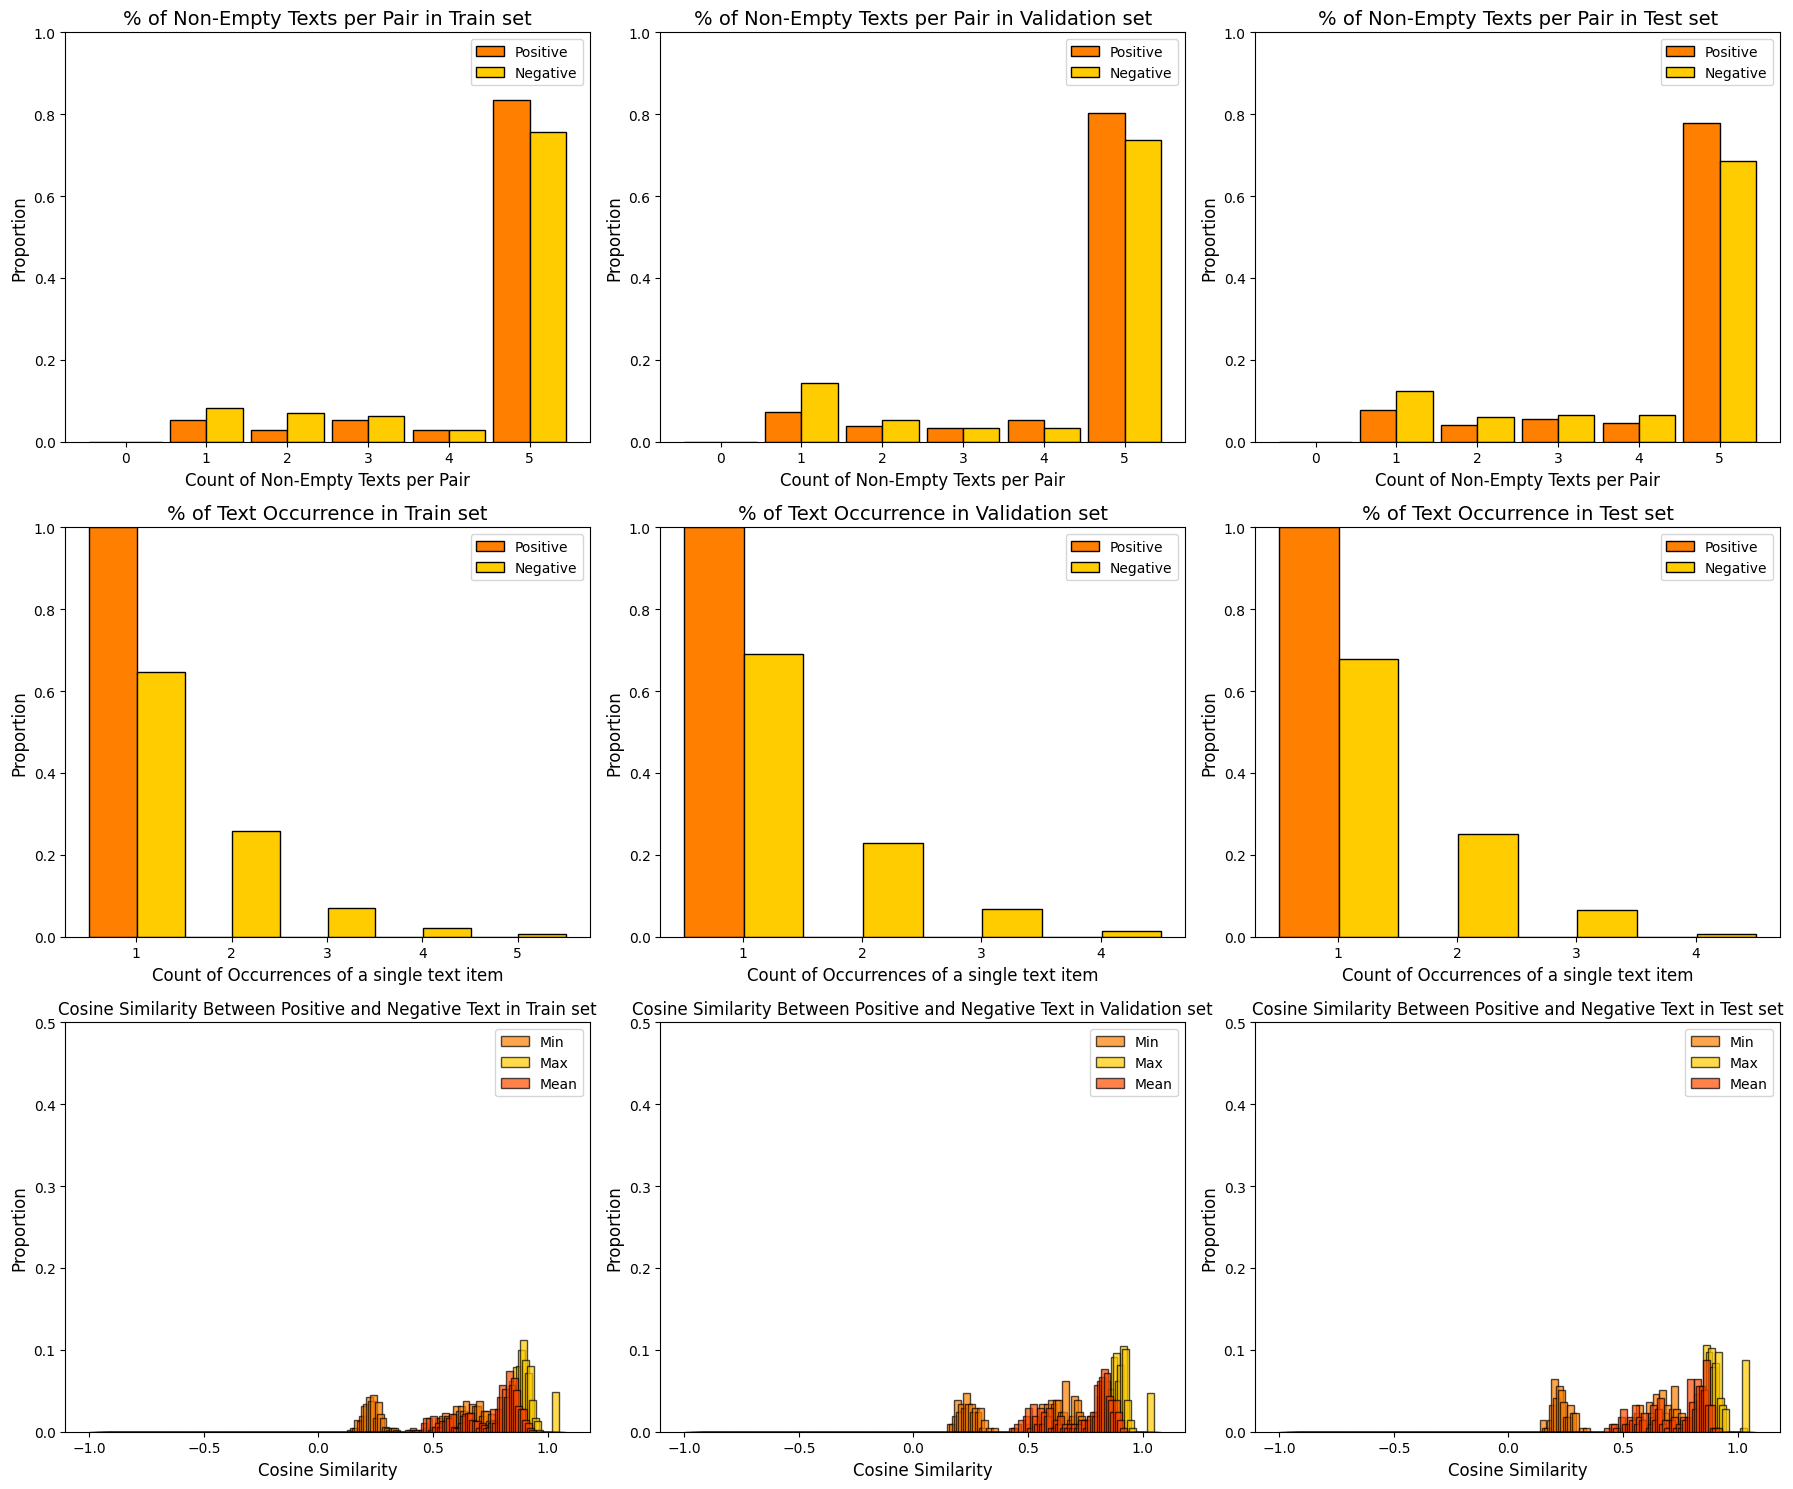

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData

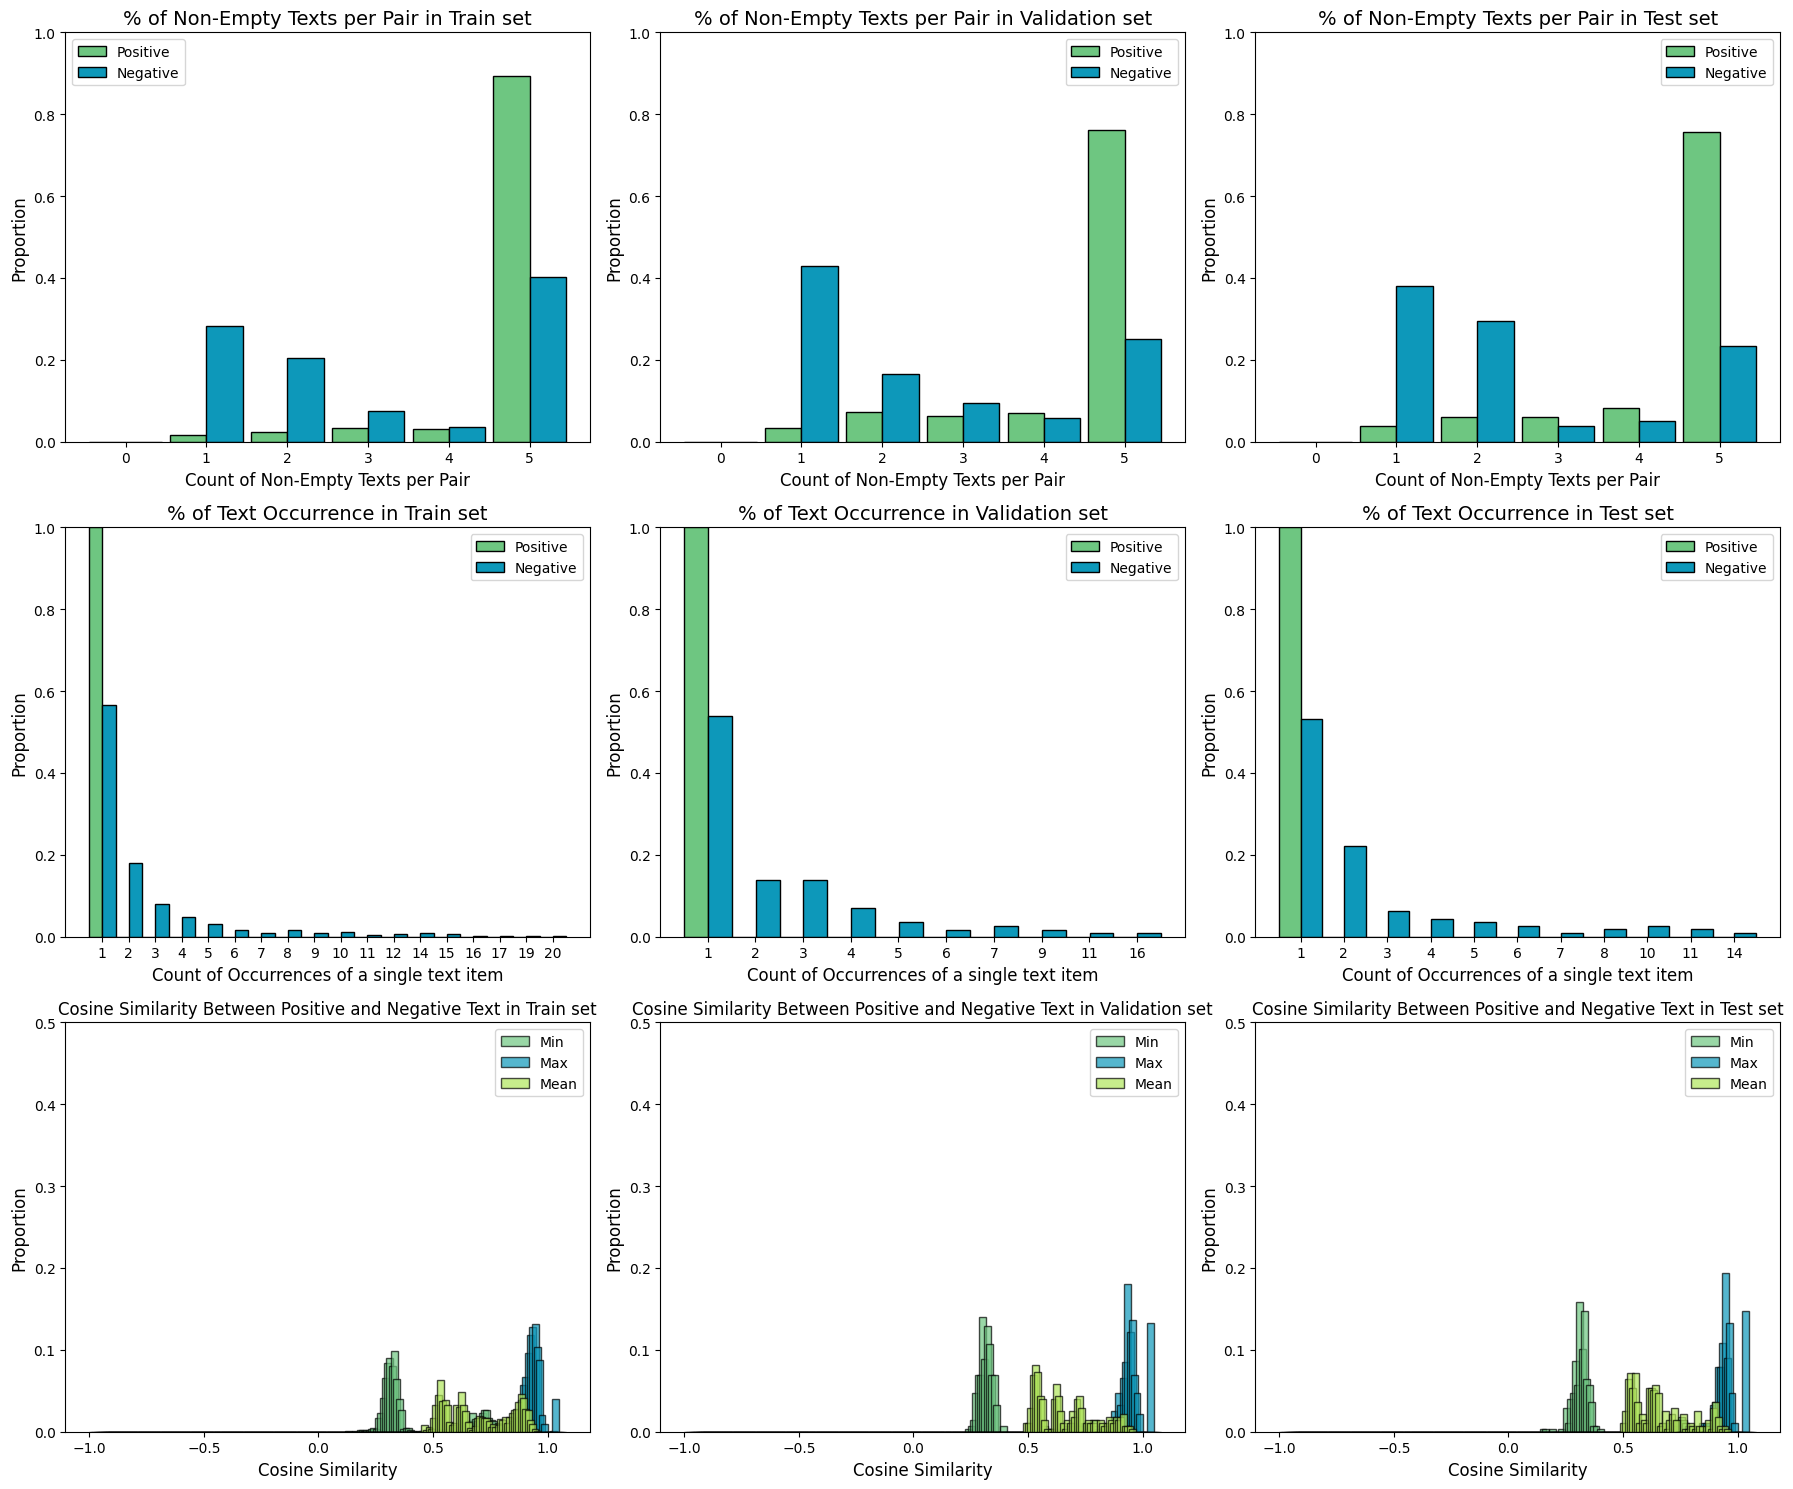

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData

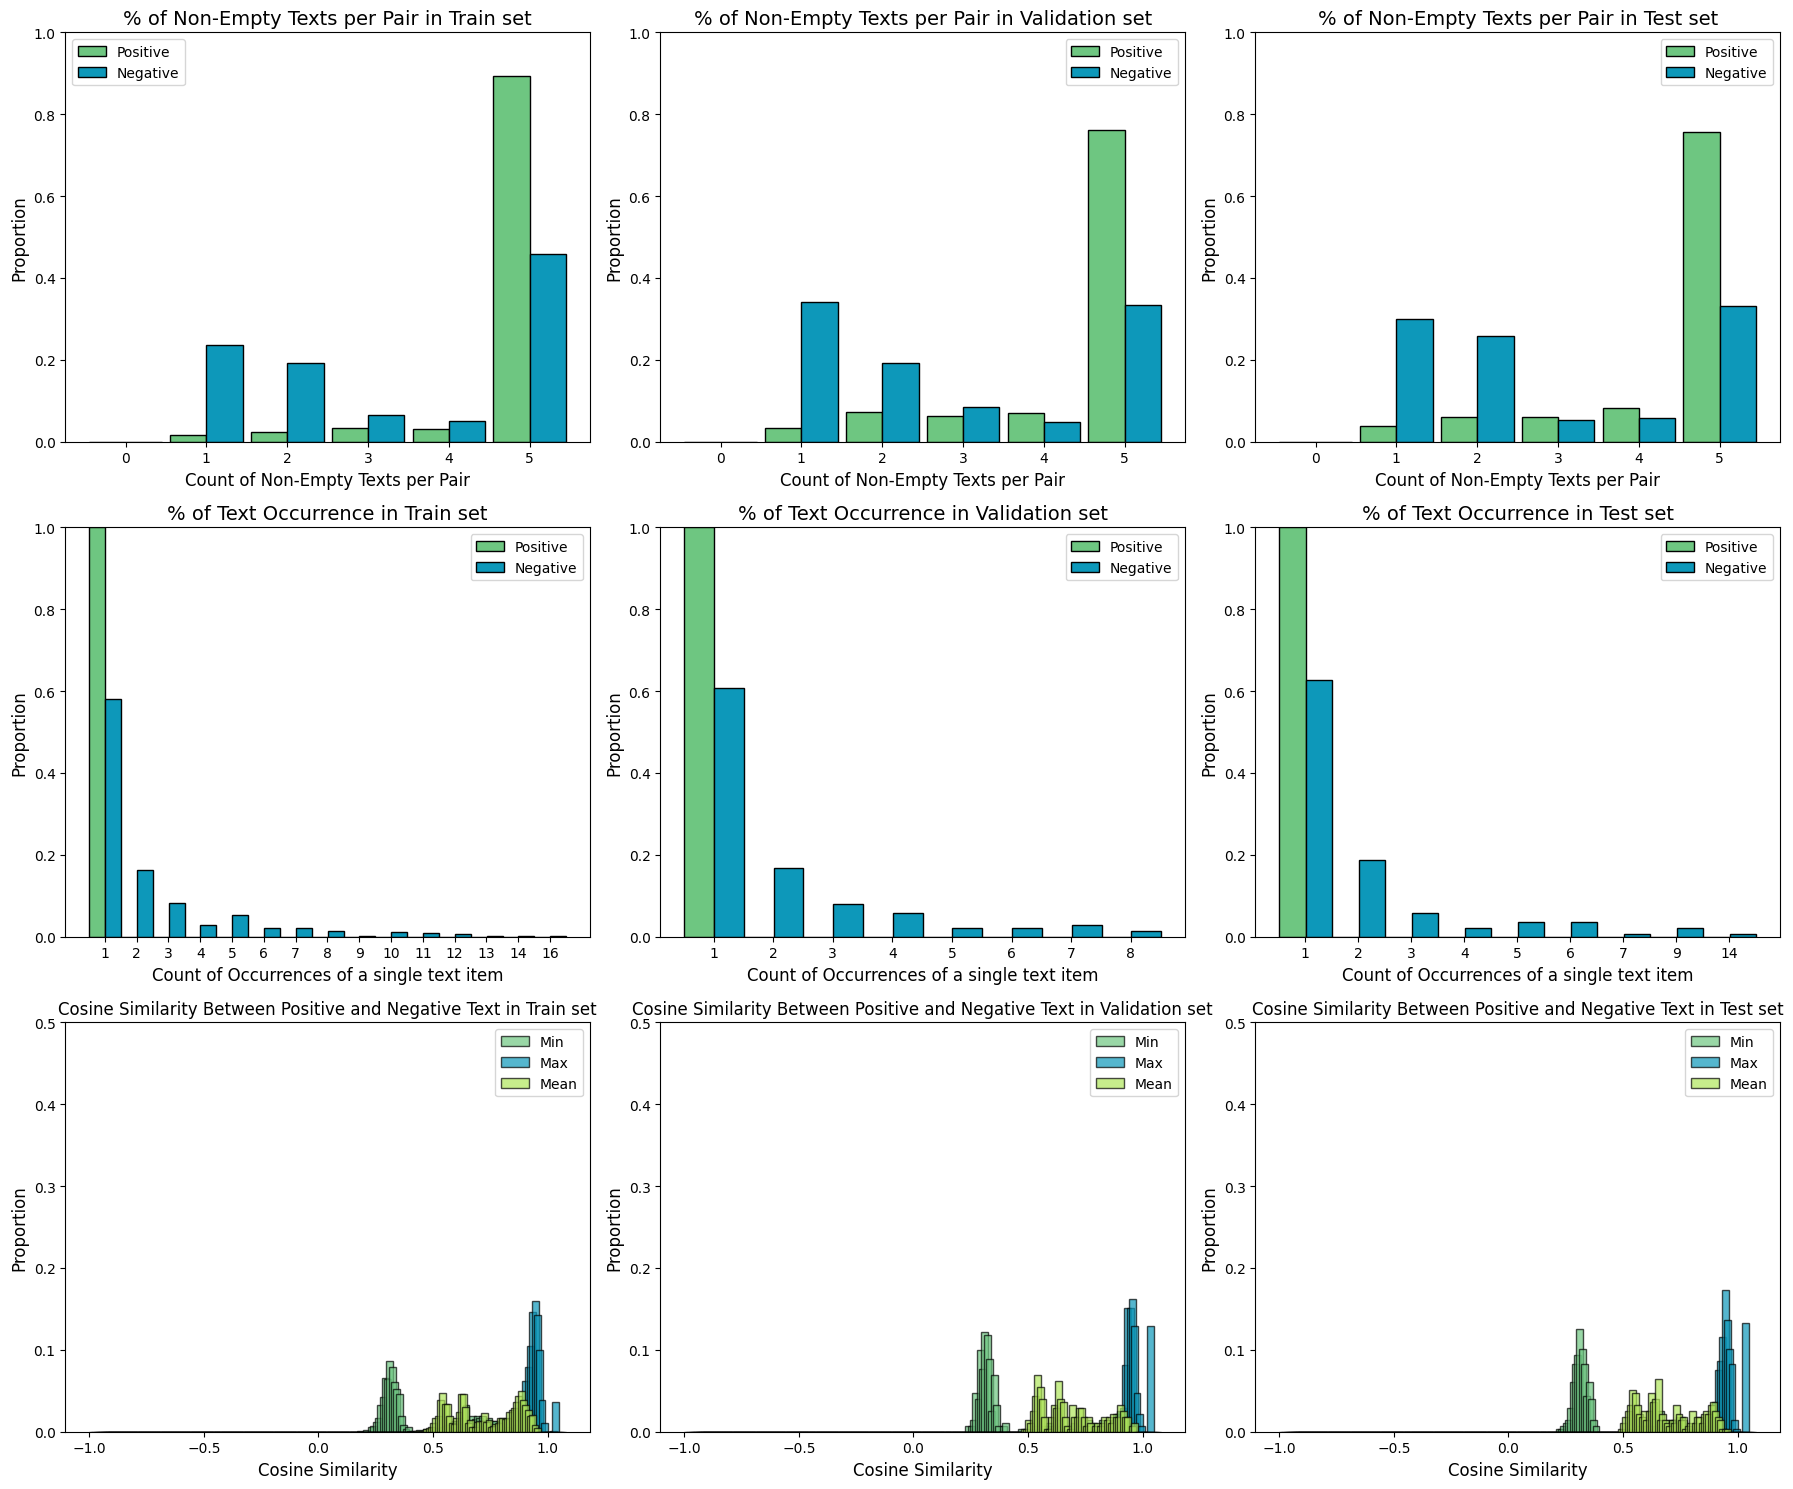

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 1/1 [00:00<00:00, 45.61it/s]
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transforme

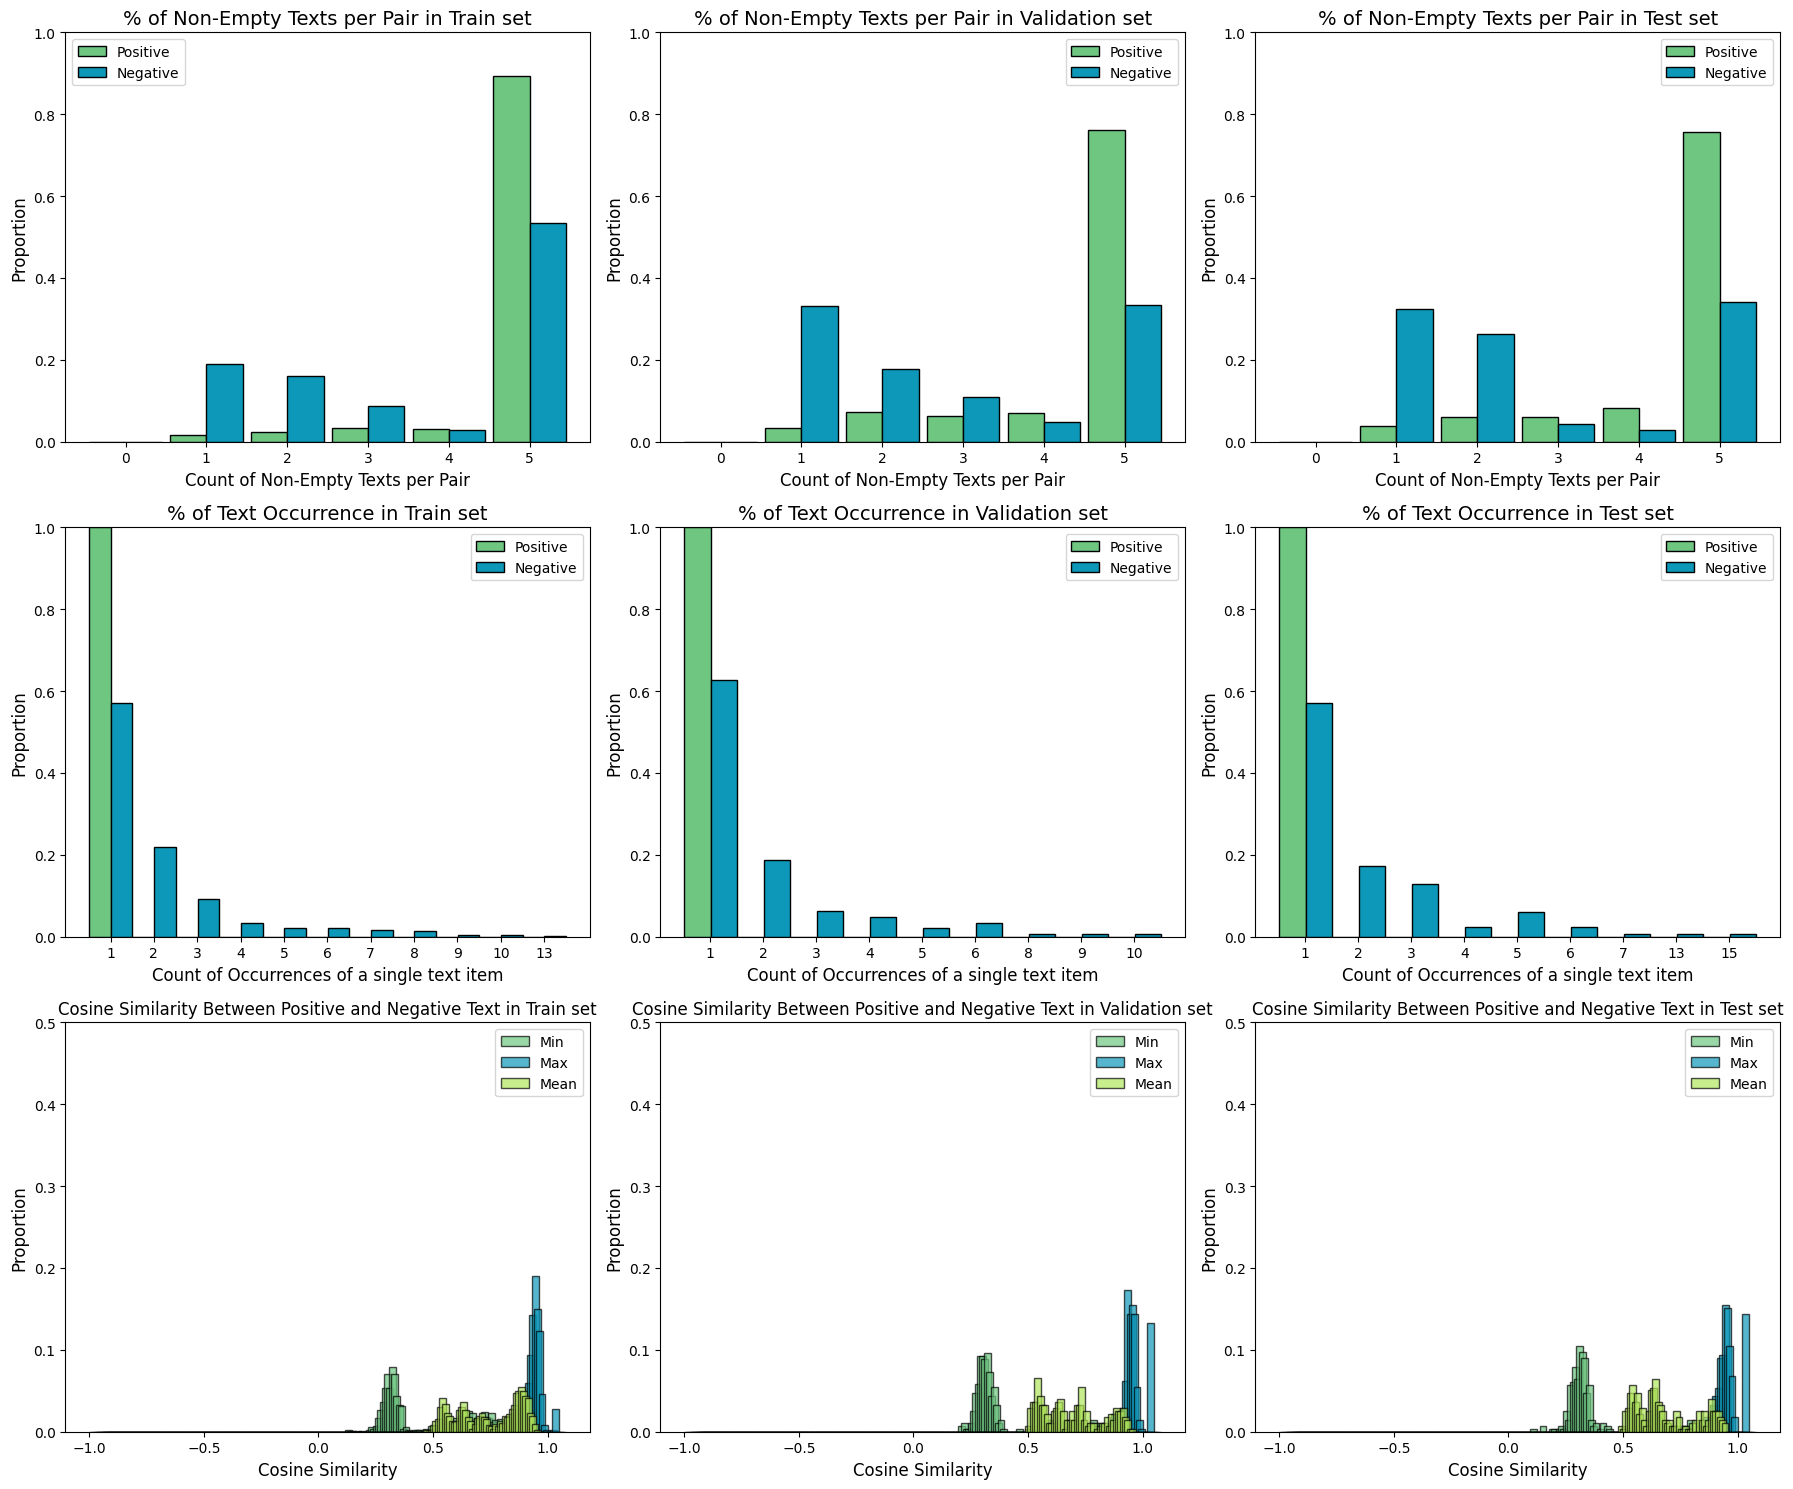

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData

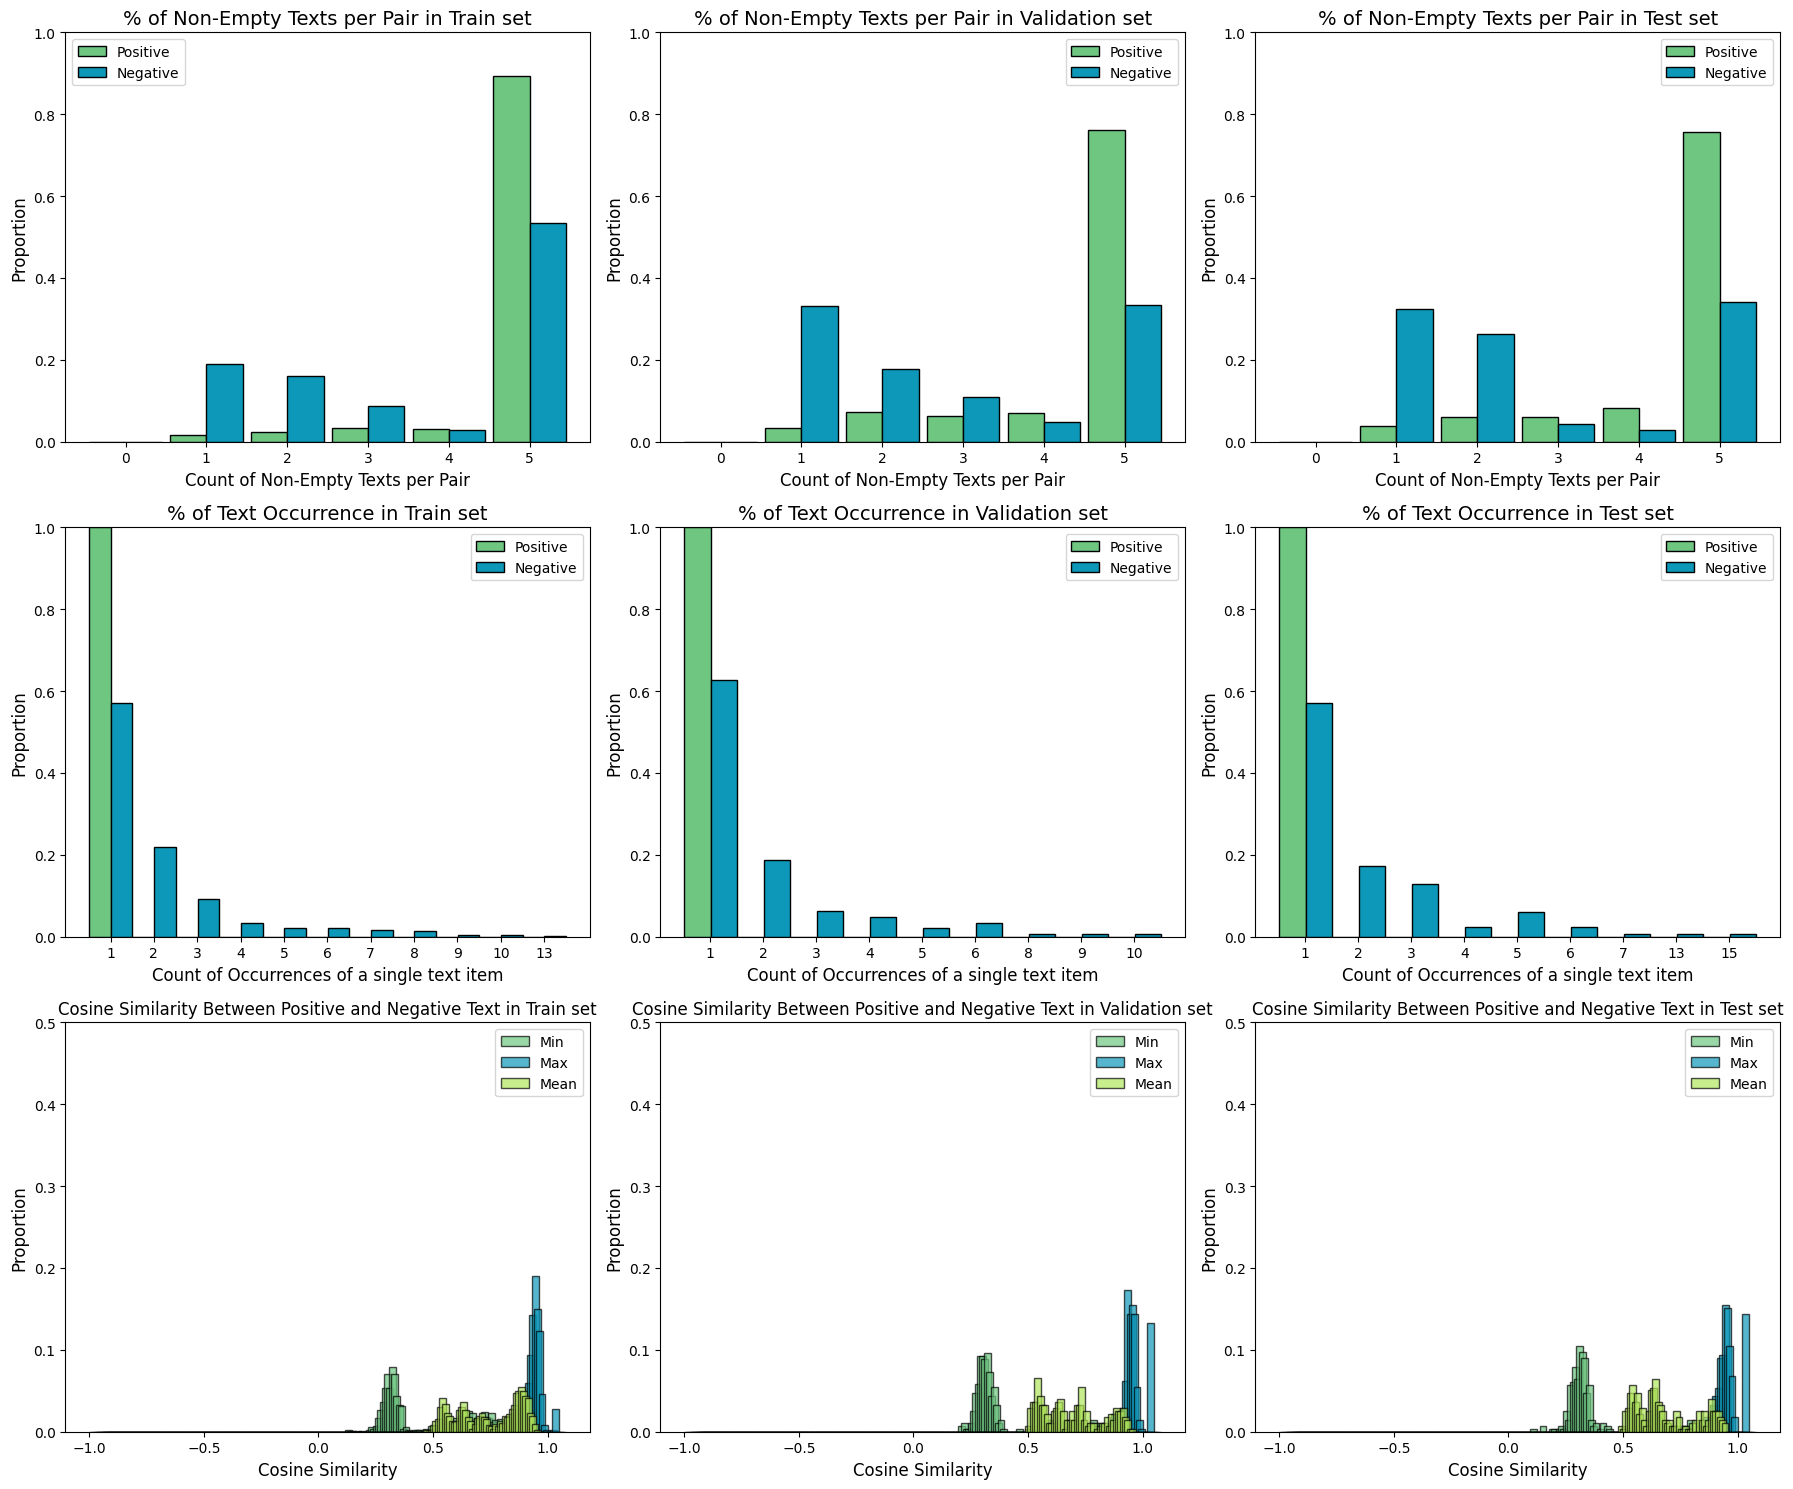

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


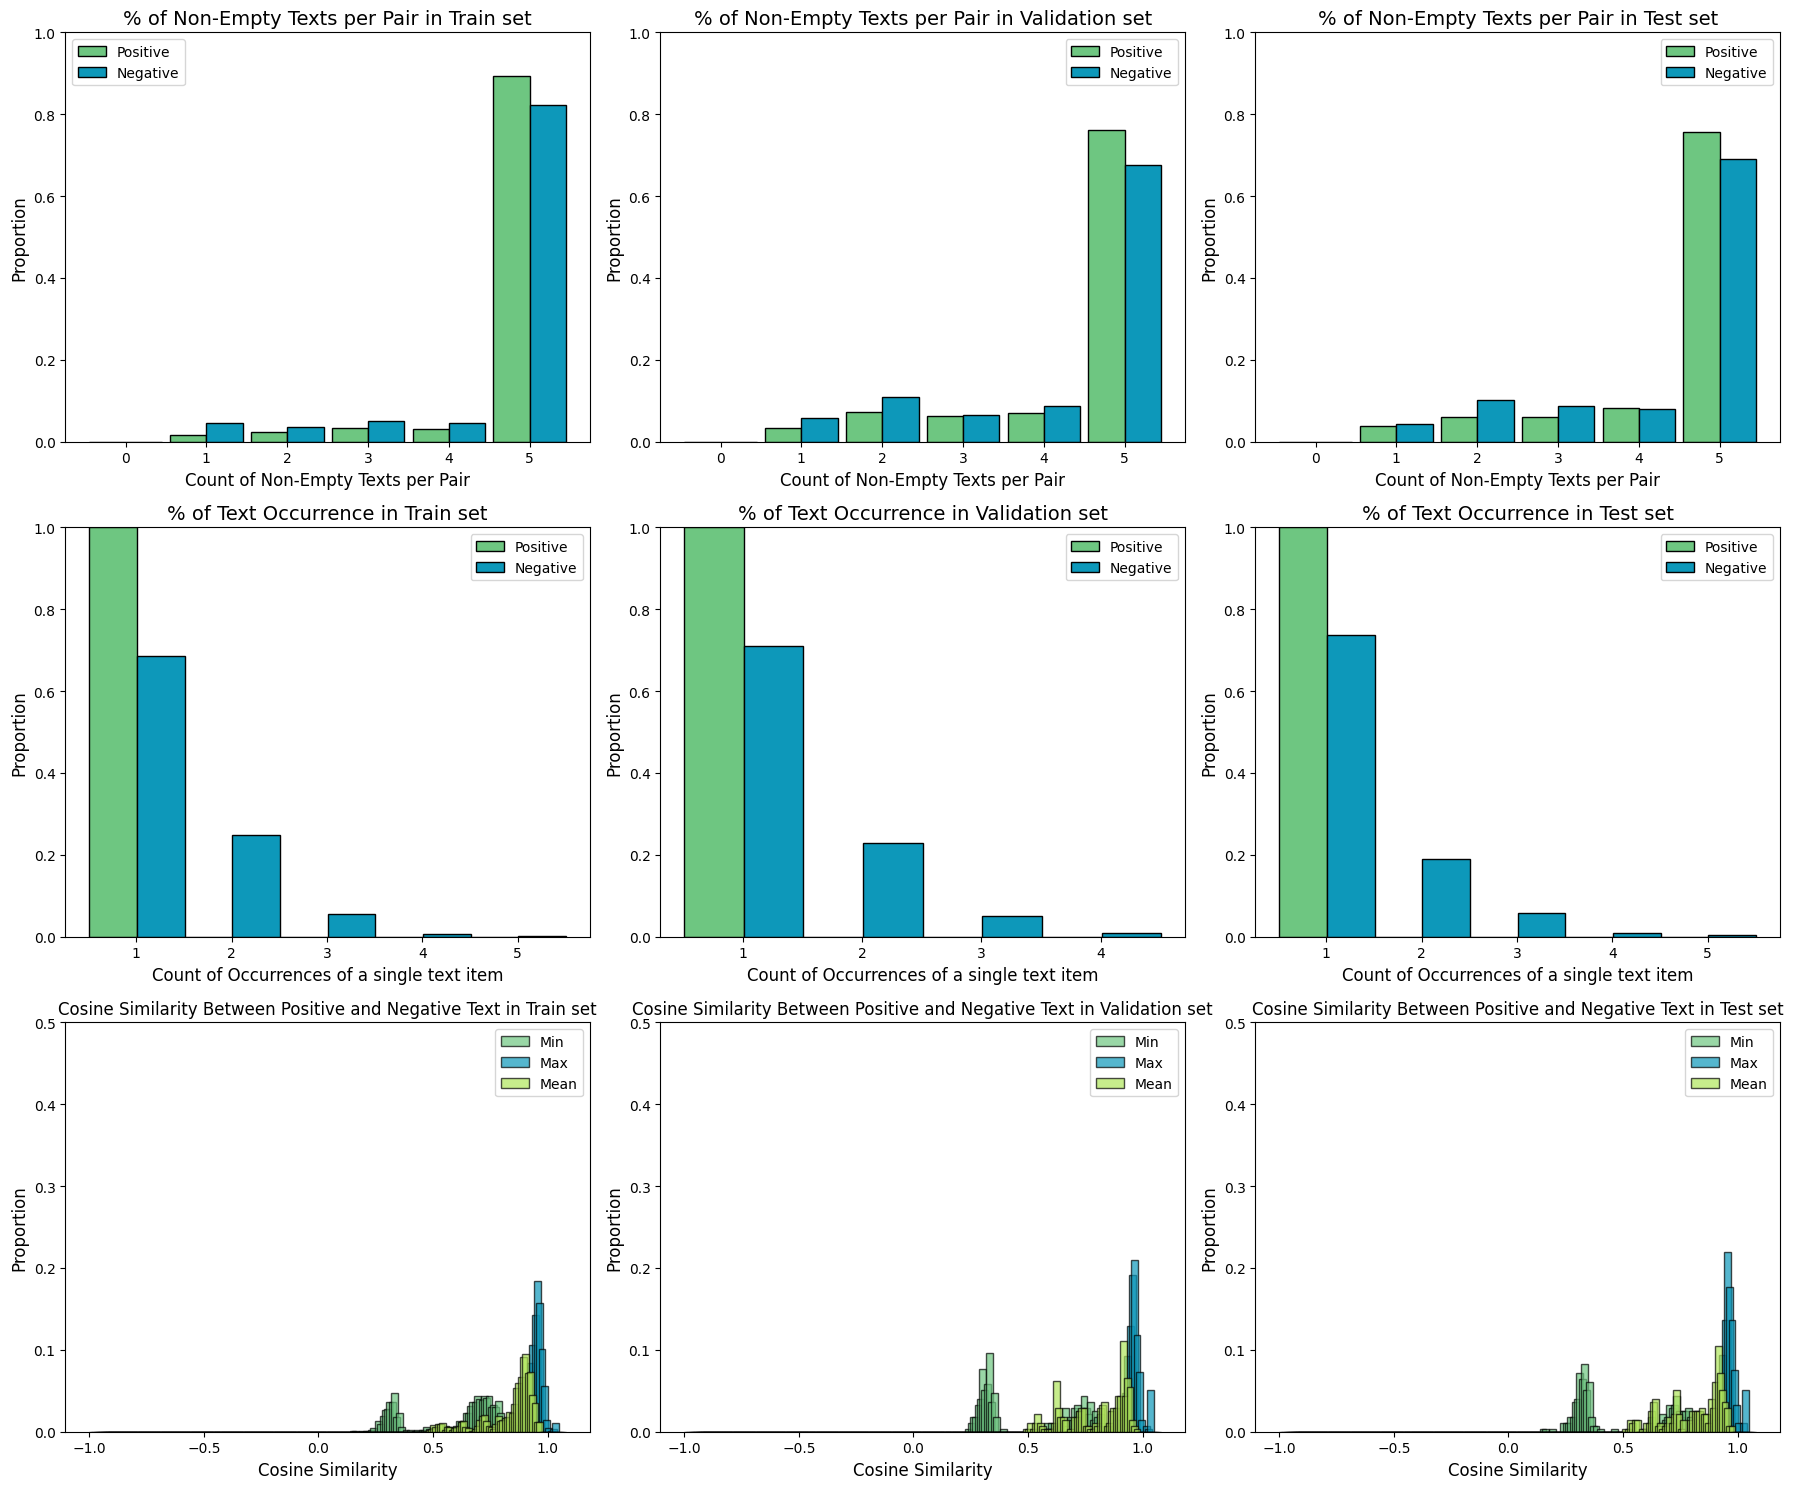

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\eoinp\AppData

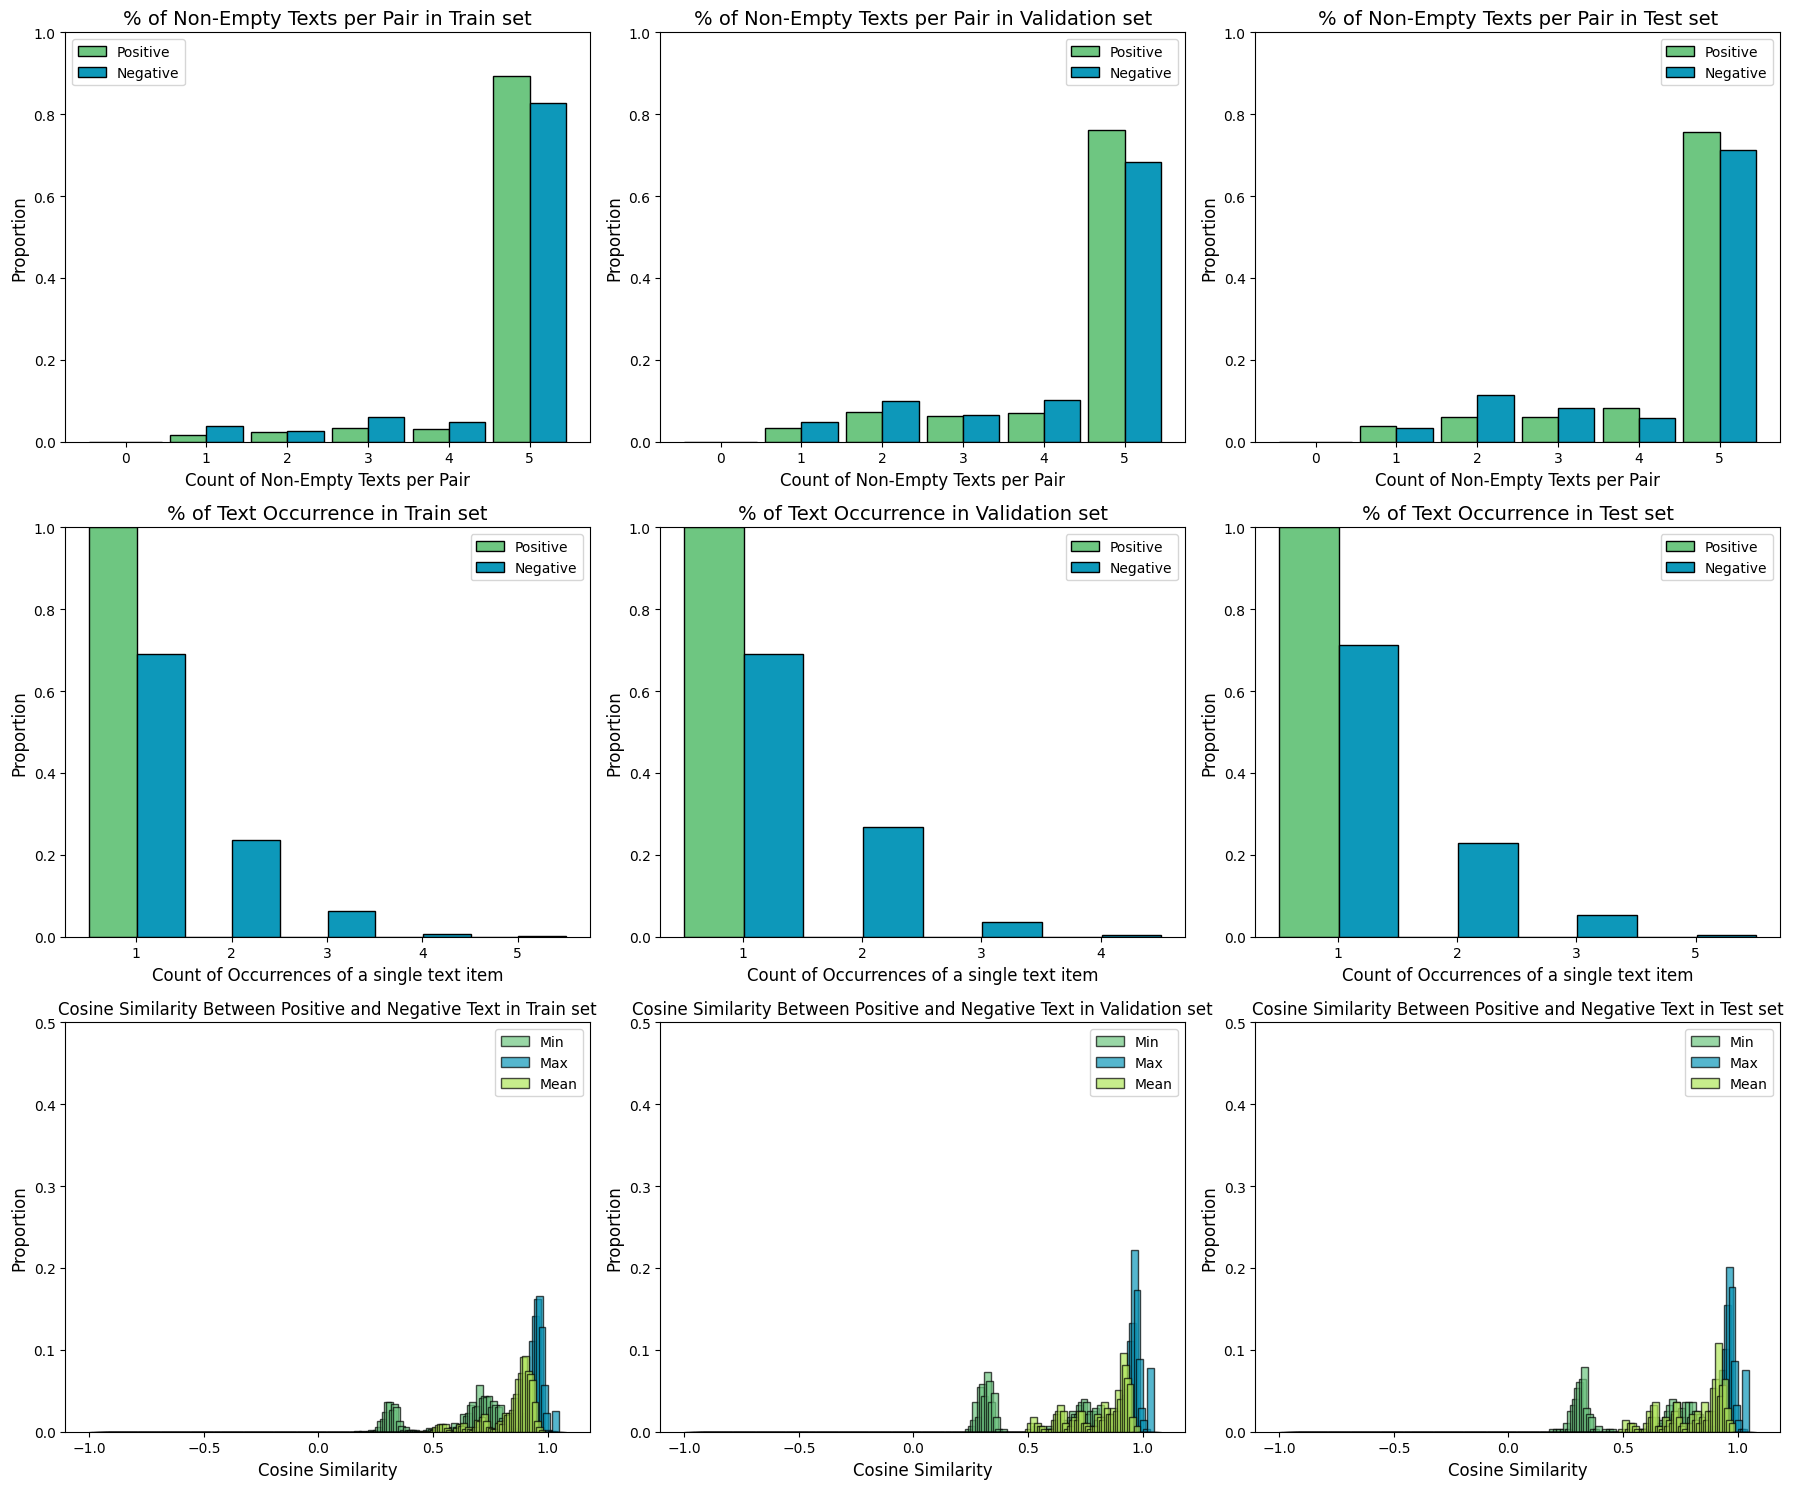

In [1]:
import data_helper_v3 as dh3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from collections import Counter, defaultdict
from transformers import AutoTokenizer, AutoModel
import torch

data_source = [{
            "name": "EDT",
            "name_visual": "EDT",
            "text_path": "./data/EDT/evaluate_news.json",
            "ts_path": "./data/stock_emotions/price/",
            "ts_date_col": 'Date',
            'text_date_col': 'date',
            'text_col': 'text',
            'plot_colour': '#8a229e',
            'plot_colours': ['#8a229e', '#c71585', '#612aaf', '#b2198d', '#9e1d96'],
            'subset_list': ['JNJ', 'BAC', 'MSFT'],
            'train_dates': '01/01/2020 - 03/09/2020',
            'test_dates': '04/09/2020 - 31/12/2020'
        },{
            "name": "stock_emotion",
            "name_visual": "Stock Emotion",
            "text_path": "./data/stock_emotions/tweet/processed_stockemo.csv",
            "ts_path": "./data/stock_emotions/price/",
            "ts_date_col": 'Date',
            'text_date_col': 'date',
            'text_col': 'text',
            'plot_colour': '#ff7f00',
            'plot_colours': ['#ff7f00',  '#ffcc00',  '#ff4c00', '#ff6600', '#ff9900'],
            'subset_list': ['AAPL', 'BA', 'TSLA'],
            'train_dates': '01/01/2020 - 03/09/2020',
            'test_dates': '04/09/2020 - 31/12/2020'
        },  {
            "name": "stock_net",
            "name_visual": "Stock Net",
            "text_path": "./data/stocknet/tweet/organised_tweet.csv",
            "ts_path": "./data/stocknet/price/raw/",
            "ts_date_col": 'Date',
            'text_date_col': 'created_at',
            'text_col': 'text',
            'plot_colour': '#6ec681',
            'plot_colours': ['#6ec681', '#0d98ba', '#b0e65b', '#2da7a7', '#4eb794'],
            'subset_list': ['AAPL', 'FB', 'GOOG'],
            'train_dates': '01/01/2014 - 01/08/2015',
            'test_dates': '01/08/2015 - 01/01/2016'
        }]

def calculate_shannon_entropy(df, bins=10000):
    """
    Calculates the Shannon entropy for each ticker based on daily returns from the Close column.
    Also includes the maximum possible entropy for each ticker.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing stock data with columns 
                           ['Date', 'Close', 'ticker'].
        bins (int): Number of bins to use for the histogram of returns.
    
    Returns:
        pd.DataFrame: A DataFrame with tickers, their entropy, and maximum possible entropy.
    """
    # Calculate daily returns grouped by ticker using the Close column
    #df['Close'] = df['Close'] + 1e-3 #add epsillon to avoid 0 divisions
    #df['Return'] = df.groupby('ticker')['Close'].pct_change()

    # Initialize a dictionary to store entropy values for each ticker
    entropy_dict = {}

    # Loop through each unique ticker
    for ticker in df['ticker'].unique():
        # Filter the returns for the current ticker and drop NaN values
        returns = df[df['ticker'] == ticker]['Close']
        
        # Calculate the histogram of returns (bins) to approximate probabilities
        counts, bin_edges = np.histogram(returns, bins=bins, density=True)
        
        # Filter out zero counts to avoid log(0) issues
        probabilities = counts[counts > 0] / np.sum(counts)
        
        # Calculate Shannon entropy
        entropy = -np.sum(probabilities * np.log2(probabilities))
        
        # Calculate the maximum possible entropy for the given number of bins
        max_entropy = np.log2(bins)

        # Store the result in the dictionary
        entropy_dict[ticker] = {'Entropy': entropy, 'Max_Entropy': max_entropy}

    # Convert the dictionary to a DataFrame for easy viewing
    entropy_df = pd.DataFrame.from_dict(entropy_dict, orient='index').reset_index()
    entropy_df.columns = ['Ticker', 'Entropy', 'Max_Entropy']
    
    return entropy_df

def compute_cosine_similarity_matrix(text_data):
    """
    Computes the cosine similarity matrix for the given list of texts.
    """
    # Load pre-trained Sentence-BERT model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Convert text data to embeddings
    embeddings = model.encode(text_data, convert_to_tensor=True)
    # Move tensor to CPU and convert to NumPy array
    embeddings = embeddings.cpu().numpy()
    # Compute cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(embeddings)

    return cosine_sim_matrix

def plot_similarity_distribution(similarity_matrix, color, title='Cosine Similarity Distribution'):
    """
    Plots the histogram distribution of the cosine similarity scores.
    """
    # Extract the upper triangle of the similarity matrix, excluding the diagonal
    similarity_scores = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]

    plt.figure(figsize=(8, 5))
    plt.hist(similarity_scores, bins=30, alpha=0.75, color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.show()

def plot_similarity_heatmap(similarity_matrix, title='Cosine Similarity Heatmap'):
    """
    Plots a heatmap of the cosine similarity matrix.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap='coolwarm', annot=False, cbar=True)
    plt.title(title)
    plt.show()

def analyze_text_similarity(df, color, per_ticker=False):
    """
    Main function to compute and plot similarity analysis.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the text data.
        per_ticker (bool): Whether to perform analysis per ticker or for all text data.
    """
    if per_ticker:
        unique_tickers = df['ticker'].unique()
        n_tickers = len(unique_tickers)

        # Create subplots: one histogram and one heatmap per ticker
        fig, axes = plt.subplots(n_tickers, 2, figsize=(15, 5 * n_tickers))

        for i, ticker in enumerate(unique_tickers):
            # Filter text data for the current ticker
            ticker_texts = df[df['ticker'] == ticker]['text'].tolist()[:500]

            # Compute cosine similarity matrix
            sim_matrix = compute_cosine_similarity_matrix(ticker_texts)

            # Plot similarity distribution
            plot_ax = axes[i, 0] if n_tickers > 1 else axes[0]
            plot_ax.hist(sim_matrix[np.triu_indices_from(sim_matrix, k=1)], bins=100, alpha=0.65, color=color, edgecolor='black')
            plot_ax.set_title(f'{ticker} - Cosine Similarity Distribution')
            plot_ax.set_xlabel('Cosine Similarity')
            plot_ax.set_ylabel('Frequency')

            # Plot heatmap
            sns.heatmap(sim_matrix, cmap='coolwarm', annot=False, ax=axes[i, 1] if n_tickers > 1 else axes[1])
            axes[i, 1].set_title(f'{ticker} - Cosine Similarity Heatmap')

        plt.tight_layout()
        plt.show()

    else:
        # Use all text data in the DataFrame
        all_texts = df['text'].tolist()

        # Compute cosine similarity matrix
        sim_matrix = compute_cosine_similarity_matrix(all_texts)

        # Plot histogram of cosine similarity scores
        plot_similarity_distribution(sim_matrix, color=color, title='All Texts - Cosine Similarity Distribution')

        # Plot heatmap of the similarity matrix
        plot_similarity_heatmap(sim_matrix, title='All Texts - Cosine Similarity Heatmap')

# Plotting the column graph for Entropy values
def plot_entropy_bar_chart(entropy_df, color, dataset_name):
    """
    Plots a bar chart where each ticker has its own column representing entropy.
    """
    max_entropy = entropy_df['Max_Entropy'].max()
    plt.figure(figsize=(10, 6))
    plt.bar(entropy_df['Ticker'], entropy_df['Entropy'], color=color, edgecolor='black')

    plt.title(f'Shannon Entropy per Ticker in {dataset_name}', fontsize=16)
    plt.xlabel('Ticker', fontsize=14)
    plt.ylabel('Entropy', fontsize=14)
    plt.ylim(0, max_entropy)  # Set y-axis limit to max entropy value
    plt.xticks(rotation=45)
    
    # Optional: Add entropy values on top of bars
    for i, val in enumerate(entropy_df['Entropy']):
        plt.text(i, val + 0.05, f'{val:.2f}', ha='center', fontsize=12)

    plt.show()
def plot_grouped_entropy_bars(dfs, df_names, dataset_name, colors):
    """
    Plots multiple Shannon entropy DataFrames as grouped bars with colors based on dataset.
    
    Parameters:
        dfs (list of pd.DataFrame): List of DataFrames containing 'Ticker' and 'Entropy' columns.
        df_names (list of str): List of names for each dataset (used for legend).
    """
    # Combine all tickers from all DataFrames to ensure alignment
    all_tickers = set().union(*[set(df['Ticker']) for df in dfs])
    all_tickers = sorted(all_tickers)  # Sort tickers for consistent order

    # Number of datasets and tickers
    num_dfs = len(dfs)
    num_tickers = len(all_tickers)
    

    # X positions for the groups of bars
    x = np.arange(num_tickers)  *0.08

    # Width of each bar within a group
    bar_width = 0.02

    # Set up the plot
    plt.figure(figsize=(12, 6))

    # Plot bars for each dataset
    for i, (df, name, color) in enumerate(zip(dfs, df_names, colors)):
        
        max_entropy = df['Max_Entropy'].max()
        # Align each DataFrame to the full list of tickers, filling missing tickers with NaN
        df = df.set_index('Ticker').reindex(all_tickers).reset_index()

        # Plot the bars for the current dataset
        plt.bar(
            x + i * bar_width, 
            df['Entropy'], 
            width=bar_width, 
            label=name, 
            color=color
        )

    plt.axhline(y=max_entropy, color='red', linestyle='--', linewidth=2, label='Max Entropy')

    # Formatting the plot
    plt.xlabel('Ticker', fontsize=18)
    plt.ylabel('Shannon Entropy', fontsize=18)
    plt.title(f'Comparison of Shannon Entropy For Each Ticker In {dataset_name}', fontsize=20)
    plt.xticks(x + bar_width * (num_dfs - 1) / 2, all_tickers, fontsize=16)  # Center tickers on x-axis
    plt.yticks(fontsize=16)
    #plt.ylim(0, max_entropy)  # Set y-axis limit to max entropy value
    plt.legend(title='Dataset Split', fontsize=18)
    plt.tight_layout()


    # Show the plot
    plt.show()
import pdb

def plot_cosine_similarity_histograms(df1, df2, colours):
    """
    For each ticker, calculates cosine similarities between text pairs using Sentence-BERT.
    Plots histograms showing cosine similarity distributions for each ticker from both DataFrames.
    
    Parameters:
        df1 (pd.DataFrame): First DataFrame with columns ['ticker', 'text'].
        df2 (pd.DataFrame): Second DataFrame with columns ['ticker', 'text'].
    """
    # Load the Sentence-BERT model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Find unique tickers in the DataFrames (assume they are the same in both DataFrames)
    tickers = df1['ticker'].unique()

    # Create subplots for each ticker
    n_tickers = len(tickers)
    fig, axes = plt.subplots(n_tickers, 1, figsize=(10, 6 * n_tickers), sharex=False)

    if n_tickers == 1:
        axes = [axes]  # Ensure axes is always a list for consistency

    # Loop through each ticker and calculate cosine similarities
    for i, ticker in enumerate(tickers):
        # Filter texts for the current ticker in both DataFrames
        texts1 = df1[df1['ticker'] == ticker]['text'].tolist()
        texts2 = df2[df2['ticker'] == ticker]['text'].tolist()

        # Calculate embeddings for the texts
        embeddings1 = model.encode(texts1, convert_to_tensor=True)
        embeddings2 = model.encode(texts2, convert_to_tensor=True)

        # Compute pairwise cosine similarities within each DataFrame
        sim_matrix1 = cosine_similarity(embeddings1.cpu().numpy())
        sim_matrix2 = cosine_similarity(embeddings2.cpu().numpy())

        # Extract upper triangle values (excluding diagonal) to avoid duplicate comparisons
        similarities1 = sim_matrix1[np.triu_indices_from(sim_matrix1, k=1)]
        similarities2 = sim_matrix2[np.triu_indices_from(sim_matrix2, k=1)]

        # Plot histograms for both DataFrames
        ax = axes[i]
        ax.hist(similarities1, bins=50, alpha=0.75, color=colours[0], label='Train', edgecolor='black', density=True)
        ax.hist(similarities2, bins=50, alpha=0.75, color=colours[1], label='Test', edgecolor='black', density=True)

        # Set title and labels
        ax.set_title(f'Cosine Similarity Distribution for {ticker}', fontsize=16)
        ax.set_xlabel('Cosine Similarity', fontsize=14)
        ax.set_ylabel('Percentage of Total', fontsize=14)
        ax.legend()

        #ax.set_xticks(np.linspace(0, 1, 11))  # Example: 0.0 to 1.0 with 11 ticks
        #ax.set_xticklabels([f'{x:.1f}' for x in np.linspace(0, 1, 11)], fontsize=12)

    plt.tight_layout()
    plt.show()

def get_data_analytics_pre_neg(data_source, subset_data=True):
    data_dictionary = dh3.get_data(text_tokenizer=None, data_source=data_source, subset_data=True, return_splits=True)
    colors = data_source['plot_colours']

    ts_dfs = [data_dictionary['train'][1], data_dictionary['test'][1]]
    text_dfs = [data_dictionary['train'][0], data_dictionary['test'][0]]

    #handle shannon entropy plots
    entropy_dfs = []

    for ts_df in ts_dfs:
        entropy_dfs.append(calculate_shannon_entropy(df=ts_df))

    plot_grouped_entropy_bars(dfs=entropy_dfs, df_names=['Train', "Test"], colors=colors, dataset_name=data_source['name_visual'])

    plot_cosine_similarity_histograms(text_dfs[0], text_dfs[1], colours=colors)
    
    
    return text_dfs[0], ts_dfs[0]

from transformers import AutoModel, AutoTokenizer
import torch

class TextEncoder:
    def __init__(self, aggregation='mean'):
        self.text_encoder = AutoModel.from_pretrained('bert-base-uncased')
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.text_aggregation = aggregation

    def encode_texts(self, raw_texts):
        # Tokenize the input texts
        text_data = self.tokenizer(
            raw_texts, 
            padding=True, 
            truncation=True, 
            return_tensors='pt'
        )

        input_ids = text_data['input_ids']
        attention_mask = text_data['attention_mask']

        # Check for empty texts (all padding tokens)
        empty_texts = (input_ids == self.tokenizer.pad_token_id).all(dim=-1)

        # Reshape inputs for batch processing
        batch_size, number_of_texts, embedding_dim = input_ids.size(0), input_ids.size(1), input_ids.size(-1)
        input_ids = input_ids.view(batch_size * number_of_texts, embedding_dim)
        attention_mask = attention_mask.view(batch_size * number_of_texts, embedding_dim)

        # Forward pass through the text encoder
        with torch.no_grad():
            model_output = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        
        # Extract the embeddings (use the mean of the last hidden state)
        text_embeddings = model_output.last_hidden_state.mean(dim=1)

        # Reshape the embeddings back to [batch_size, number_of_texts, embedding_dim]
        embedding_dim = text_embeddings.size(-1)  # Update embedding dimension after encoding
        text_embeddings = text_embeddings.view(batch_size, number_of_texts, embedding_dim)

        # Create a mask for non-empty texts
        non_empty_mask = ~empty_texts.unsqueeze(-1).expand_as(text_embeddings).float()

        # Perform aggregation: 'mean' or 'max' pooling
        if self.text_aggregation == 'mean':
            summed_embeddings = torch.sum(text_embeddings * non_empty_mask, dim=1)
            valid_counts = torch.sum(non_empty_mask, dim=1)  # Number of non-empty texts per batch
            final_text_embeddings = summed_embeddings / valid_counts.clamp(min=1)  # Avoid division by zero
        elif self.text_aggregation == 'max':
            masked_embeddings = text_embeddings.masked_fill(non_empty_mask == 0, float('-inf'))
            final_text_embeddings, _ = torch.max(masked_embeddings, dim=1)
        else:
            raise NotImplementedError("Text embedding aggregation must be 'mean' or 'max'.")

        return final_text_embeddings
def generate_combined_plots(dfs, colours):
    """
    Generates a grid of plots with 3 columns (one for each DataFrame) and multiple rows:
    1. Proportion of non-empty text counts per label.
    2. Proportion of text ID occurrences.
    3. Histogram of cosine similarity scores as proportions.
    """
    #SentenceTransformer('all-MiniLM-L6-v2')
    model = AutoModel.from_pretrained('bert-base-uncased')
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    def encode_texts(texts):
        inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state  # Shape: [batch_size, seq_length, hidden_dim]

        # Apply max pooling along the sequence length dimension (dim=1)
        embeddings = torch.mean(last_hidden_state, dim=1)
        return embeddings

    # Create a grid of subplots: 3 columns (one per DataFrame), and 3 rows for the different plots
    fig, axes = plt.subplots(3, len(dfs), figsize=(18, 15))  # 3 rows x n columns (n=len(dfs))
    df_names = ["Train", "Validation", "Test"]
    for i, df in enumerate(dfs):
        ### 1. Proportion of Non-Empty Text Counts per Label ###
        non_empty_counts = defaultdict(Counter)
        for _, row in df.iterrows():
            num_non_empty = sum([1 for text in row['text_series'] if text != ''])
            non_empty_counts[row['label']][num_non_empty] += 1

        max_count = max(
            max(non_empty_counts[1].keys(), default=0),
            max(non_empty_counts[-1].keys(), default=0)
        ) 
        x = np.arange(max_count + 1)

        # Convert counts to proportions
        total_pos = sum(non_empty_counts[1].values())
        total_neg = sum(non_empty_counts[-1].values())
        positive_props = [non_empty_counts[1].get(j, 0) / total_pos for j in x]
        negative_props = [non_empty_counts[-1].get(j, 0) / total_neg for j in x]

        ax1 = axes[0, i]  # Top row for non-empty text counts
        width = 0.45
        ax1.bar(x - width / 2, positive_props, width, label='Positive', color=colours[0], edgecolor='black')
        ax1.bar(x + width / 2, negative_props, width, label='Negative', color=colours[1], edgecolor='black')

        ax1.set_ylim(0, 1.0)

        ax1.set_title(f'% of Non-Empty Texts per Pair in {df_names[i]} set', fontsize=14)
        ax1.set_xlabel('Count of Non-Empty Texts per Pair', fontsize=12)
        ax1.set_ylabel('Proportion', fontsize=12)
        ax1.set_xticks(x)
        ax1.legend()

        ### 2. Proportion of Text ID Occurrences ###
        text_id_counts = defaultdict(Counter)
        for _, row in df.iterrows():
            text_id = row['text_id']
            text_id_counts[row['label']][text_id] += 1

        freq_counts = defaultdict(Counter)
        for label, counter in text_id_counts.items():
            for _, count in counter.items():
                freq_counts[label][count] += 1

        all_counts = sorted(set(count for counter in freq_counts.values() for count in counter))
        x_ticks = np.arange(len(all_counts) * 2) * 0.35

        # Convert counts to proportions
        total_pos = sum(freq_counts[1].values())
        total_neg = sum(freq_counts[-1].values())
        positive_props = [freq_counts[1].get(count, 0) / total_pos for count in all_counts]
        negative_props = [freq_counts[-1].get(count, 0) / total_neg for count in all_counts]

        ax2 = axes[1, i]  # Middle row for text ID occurrence frequency
        ax2.bar(x_ticks[::2], positive_props, width=0.35, label='Positive', color=colours[0], edgecolor='black')
        ax2.bar(x_ticks[1::2], negative_props, width=0.35, label='Negative', color=colours[1], edgecolor='black')

        ax2.set_ylim(0, 1.0)

        ax2.set_title(f'% of Text Occurrence in {df_names[i]} set', fontsize=14)
        ax2.set_xlabel('Count of Occurrences of a single text item', fontsize=12)
        ax2.set_ylabel('Proportion', fontsize=12)
        ax2.set_xticks(x_ticks[::2] + 0.17)
        ax2.set_xticklabels(all_counts)
        ax2.legend()

        ### 3. Histogram of Cosine Similarity as Proportions ###
        cosine_sims_min, cosine_sims_max, cosine_sims_mean = [], [], []

        grouped = df.groupby('ts_id')
        for ts_id, group in grouped:
            if len(group['label'].unique()) > 1:
                texts_pos = group[group['label'] == 1]['text_series'].values[0]
                texts_neg = group[group['label'] == -1]['text_series'].values[0]

                #embeddings_pos = model.encode(texts_pos, convert_to_tensor=True)
                #embeddings_neg = model.encode(texts_neg, convert_to_tensor=True)
                embeddings_pos = encode_texts(texts_pos)
                embeddings_neg = encode_texts(texts_neg)
                cosine_matrix = cosine_similarity(embeddings_pos.cpu().numpy(), embeddings_neg.cpu().numpy())

                cosine_sims_min.append(np.min(cosine_matrix))
                cosine_sims_max.append(np.max(cosine_matrix))
                cosine_sims_mean.append(np.mean(cosine_matrix))

        # Define consistent bins and convert to proportions
        bins = np.linspace(-1, 1, 200)
        min_counts, _ = np.histogram(cosine_sims_min, bins=bins)
        max_counts, _ = np.histogram(cosine_sims_max, bins=bins)
        mean_counts, _ = np.histogram(cosine_sims_mean, bins=bins)

        min_props = min_counts / min_counts.sum()
        max_props = max_counts / max_counts.sum()
        mean_props = mean_counts / mean_counts.sum()

        ax3 = axes[2, i]  # Bottom row for cosine similarity histograms
        width = 0.03  # Adjust bar width for better alignment
        ax3.bar(bins[:-1], min_props, width=width, label='Min', alpha=0.7, color=colours[0], edgecolor='black', align='edge')
        ax3.bar(bins[:-1] + width, max_props, width=width, label='Max', alpha=0.7, color=colours[1], edgecolor='black', align='edge')
        ax3.bar(bins[:-1] + 2 * width, mean_props, width=width, label='Mean', alpha=0.7, color=colours[2], edgecolor='black', align='edge')

        ax3.set_ylim(0, 0.5)

        ax3.set_title(f'Cosine Similarity Between Positive and Negative Text in {df_names[i]} set', fontsize=12)
        ax3.set_xlabel('Cosine Similarity', fontsize=12)
        ax3.set_ylabel('Proportion', fontsize=12)
        ax3.legend()

    plt.tight_layout()
    plt.show()

def get_data_analytics(data_source, subset_data=True):
    #('TFIDF', 5)],# ('vader_polarized', 5), ('vader_neutral', 5), ('TFIDF', 2), ('embedding_diversity', 5), ('embedding_diversity', 2), ('vader_neural', 2), ('vader_polarized', 2)
    dfs = dh3.get_data(text_tokenizer=None, data_source=data_source, subset_data=True, loaders=False, negatives_creation=("sentence_transformer_dissimilarity", "max"), text_window=5)#, text_selection_method=('embedding_diversity', 5))
    colors = data_source['plot_colours']
    generate_combined_plots(dfs, colours=colors)

    dfs = dh3.get_data(text_tokenizer=None, data_source=data_source, subset_data=True, loaders=False, negatives_creation=("sentence_transformer_dissimilarity", "max"), text_window=4)
    colors = data_source['plot_colours']
    generate_combined_plots(dfs, colours=colors)
    #dfs = dh3.get_data(text_tokenizer=None, data_source=data_source, subset_data=True, loaders=False, negatives_creation=("sentence_transformer_dissimilarity", "max"), text_selection_method=('embedding_diversity', 5))
    #colors = data_source['plot_colours']
    #generate_combined_plots(dfs, colours=colors)
    #fs = dh3.get_data(text_tokenizer=None, data_source=data_source, subset_data=True, loaders=False, negatives_creation=("sentence_transformer_dissimilarity", "max"), text_selection_method=('vader_neutral', 5))
    #colors = data_source['plot_colours']
    #generate_combined_plots(dfs, colours=colors)
    #dfs = dh3.get_data(text_tokenizer=None, data_source=data_source, subset_data=True, loaders=False)#, negatives_creation=("sentence_transformer_dissimilarity", "max"))#, text_selection_method=('embedding_diversity', 5))
    #colors = data_source['plot_colours']
    #generate_combined_plots(dfs, colours=colors)
    #dfs = dh3.get_data(text_tokenizer=None, data_source=data_source, subset_data=True, loaders=False, negatives_creation=("sentence_transformer_dissimilarity", "min"))#, text_selection_method=('embedding_diversity', 5))
    #colors = data_source['plot_colours']
    #generate_combined_plots(dfs, colours=colors)
    
get_data_analytics(data_source=data_source[0])
get_data_analytics(data_source=data_source[1])
get_data_analytics(data_source=data_source[2])